<h1> DYNAMIC MALWARE CLASSIFICATION</h1>

Supervised, classification, multi-class

# 0. Basic Set-Up and General info

Note: there are a lot of non-used imports (to be removed at the end)

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.ticker import MultipleLocator
import seaborn as sns
from scipy import stats

from scipy.stats import loguniform

from skopt.space import Real

import copy
import yaml

In [2]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import LinearSVC
from sklearn.svm import SVC
from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import StackingClassifier


In [3]:
from imblearn.over_sampling import SMOTENC
from boruta import BorutaPy

In [4]:
from library.utils.ownModels.majorityClassModel import MajorityClassClassifier # Importing self-developed model object
from library.utils.ownModels.neuralNets.feedForward import FeedForwardNeuralNetwork

In [5]:
import importlib

# Import your modules initially
import library.pipeline

# Reload the modules in case they were updated
importlib.reload(library.pipeline)

# Now you can import specific classes/functions
from library.pipeline.pipeline import Pipeline
from library.pipeline.pipeline_manager import PipelineManager

## Documentation Standarization
Follow the following guidelines to make sure our document is consistent and easier to undestand
- All constant should be writte in full capitall letters (e.g: MY_CONSTANT). Notebook-level constants should be written in the cell assigned to it (see below)
- Every new major section (EDA, Feature engineering) should be written with '# My title'#
- Subsequent sections should use '##', '###' or '####' hierarchacically
- At the beginning of each major section write a content index with the content included in that section (see 'feature engineering' section as an example)
- Please write paragraphs before and after each cell explain what u are about to do and the conclusions, correspondingly. Do not assume they are too obvious.
- Avoid excessive ChatGPT-originated comments
- Avoid writing more than 20 lines per code cell (exceptions for subroutines, which should be written in utilitied_functions.py)
- Ideally, add a "Questions" and "Things to be done" section in each major sections where u write about futher iterations u want to do (while sharing in with the rest)


## Set-up

In [6]:
variables = yaml.load(open("library/configurations.yaml"), Loader=yaml.FullLoader)


We start off with a pipeline for all the models. Then at some moment, whenever we think the pipelines will diverge, we remove the by-object-refrence (that we will create in the next cell), and create a new copy with our modifications ready.

## Pipeline Selection
We will having pipelines for:
- ensembled_models (random forest, gradient boosting)
- tree-based (decision trees)
- support vectors machines (non-linear*)
- naive bayes (gaussian naive bayes)
- stacking (stacking models)


* We originally conceived to add linear for the sake of model diversity. While the theory already pointed us out that the linear SVM wont be able to find the separating hyperplane (i.e., model is able to fit), we wanted to see if by setting

In [7]:
default_pipeline = ensembled_pipeline = tree_pipeline = supportVectorsMachine_pipeline = baseline_pipeline = naiveBayes_pipeline = stacking_pipeline = feedForwardNN_pipeline = example = Pipeline(
                        dataset_path=variables["PIPELINE_RUNNER"]["dataset_path"], 
                        model_results_path="results/model_evaluation/results.csv",
                        model_task="classification")

In [8]:
pipelines = {
            "not_baseline": {
                  "ensembled": ensembled_pipeline,
                  "tree_based": tree_pipeline,
                  "support_vector_machine": supportVectorsMachine_pipeline,
                  "naive_bayes": naiveBayes_pipeline,
                  "feed_forward_neural_network": feedForwardNN_pipeline,
                  "stacking": stacking_pipeline,
                  }, 
            "baseline": {
                  "baselines": baseline_pipeline, 
                  "example":  example               
            }
}
pipeline_manager = PipelineManager(pipelines)

Here I show an example of how we will be working with by-object-reference.

In [9]:
baseline_pipeline.dataset.example_attribute = "1"

In [10]:
default_pipeline.dataset.example_attribute

'1'

However, if we do a (deep) copy:
Note that the difference between a deep and a shallow copy is that the former copies all the objects that are inside the class. We need that.
We will overwrite the prior attribute and show is this is not propagated to the other results anymore

In [11]:
new_pipeline = copy.deepcopy(default_pipeline)
new_pipeline.dataset.example_attribute = "2"

In [12]:
default_pipeline.dataset.example_attribute

'1'

It may also be of interest for you to propagate the same method's invokation to all the pipelines within the pipeline manager. For instance, after a divergence in, lets say, feature scaling, you may need to fit all the models in the corresponding pipelines. You would want to avoid reduntandly calling the same method with the same parameters for all the Pipeline class instances. In order to do so, we present an example that avoids such annoyance

In [13]:
pipeline_manager.create_pipeline_divergence(category="baseline", pipelineName="example", print_results=True)

Pipeline example in category baseline has diverged
 Pipeline schema is now: {'not_baseline': {'ensembled': <library.pipeline.pipeline.Pipeline object at 0x285158a10>, 'tree_based': <library.pipeline.pipeline.Pipeline object at 0x285158a10>, 'support_vector_machine': <library.pipeline.pipeline.Pipeline object at 0x285158a10>, 'naive_bayes': <library.pipeline.pipeline.Pipeline object at 0x285158a10>, 'feed_forward_neural_network': <library.pipeline.pipeline.Pipeline object at 0x285158a10>, 'stacking': <library.pipeline.pipeline.Pipeline object at 0x285158a10>}, 'baseline': {'baselines': <library.pipeline.pipeline.Pipeline object at 0x285158a10>, 'example': <library.pipeline.pipeline.Pipeline object at 0x15570b250>}}


In [14]:
pipeline_manager.pipelines["baseline"]["example"].feature_analysis.feature_selection.automatic_feature_selection.speak("Whats goooddd")

Whats goooddd from 5728453776. You are at automatic feature selection!


In [15]:
pipeline_manager.all_pipelines_execute(methodName="speak", message="Hello, world!")

Hello, world! from 10822715920
Hello, world! from 5728416336


{'not_baseline': {'ensembled': None}, 'baseline': {'example': None}}

A method present deeper down the class:

Instead of doing:
'pipeline_manager.pipelines["baseline"]["logistic"].feature_analysis.feature_selection.automatic_feature_selection.speak("Whats goooddd") for all objects'

we can do:

In [16]:
pipeline_manager.all_pipelines_execute(methodName="feature_analysis.feature_selection.automatic_feature_selection.speak", message="Whats good")

Whats good from 10822716816. You are at automatic feature selection!Whats good from 5728453776. You are at automatic feature selection!



{'not_baseline': {'ensembled': None}, 'baseline': {'example': None}}

In [17]:
# lets delete the example obj
del new_pipeline 
del pipeline_manager.pipelines["baseline"]["example"]

In [18]:
pipeline_manager.pipelines

{'not_baseline': {'ensembled': <library.pipeline.pipeline.Pipeline at 0x285158a10>,
  'tree_based': <library.pipeline.pipeline.Pipeline at 0x285158a10>,
  'support_vector_machine': <library.pipeline.pipeline.Pipeline at 0x285158a10>,
  'naive_bayes': <library.pipeline.pipeline.Pipeline at 0x285158a10>,
  'feed_forward_neural_network': <library.pipeline.pipeline.Pipeline at 0x285158a10>,
  'stacking': <library.pipeline.pipeline.Pipeline at 0x285158a10>},
 'baseline': {'baselines': <library.pipeline.pipeline.Pipeline at 0x285158a10>}}

<hr>

# Start Of The Pipeline

In [19]:
default_pipeline.dataset.df.head()

Memory_PssTotal  Memory_PssClean  Memory_SharedDirty  Memory_PrivateDirty  \
0            31053             2448               14044                23472   
1           107787            21976               11852                74548   
2            86584            18460               12284                59992   
3            41248              924               10328                36280   
4            38621             5080               12392                27388   

   Memory_SharedClean  Memory_PrivateClean  Memory_SwapPssDirty  \
0               74824                 2452                    0   
1               69052                23152                    0   
2               91548                19376                    0   
3               55768                  928                    0   
4               71048                 5088                    0   

   Memory_HeapSize  Memory_HeapAlloc  Memory_HeapFree  ...  Logcat_error  \
0             8919              4786             4132  ...          1635   
1            25341             20965             4375  ...          1816   
2            24500             21378             3121  ...          2244   
3            10082              7281             2800  ...           974   
4             9077              5750             3326  ...           936   

   Logcat_warning  Logcat_debug  Logcat_verbose  Logcat_total  Process_total  \
0            2351          3285            1551         11221            193   
1             826          1544            2045          8457            189   
2            3406          1565            2819         10780            195   
3            4134          3138            1556         11739            191   
4            2298          3752            1992         10488            188   

                                                Hash    Category    Family  \
0  f460abb8f2e4e3fb689966ddaea6d6babbd1738bb691c7...  Trojan_SMS    opfake   
1  556c238536d837007e647543eaf3ea95ae9aaf1c1a52d0...  Trojan_SMS    opfake   
2  398322f94b5bfa2a9e7b3756a4cf409764595003280c48...  Trojan_SMS  fakeinst   
3  4a9c14872b2c66165599a969a1a8654bb6887d7a18ab6d...  Trojan_SMS  fakeinst   
4  6b37b9b9c170727f706b69731e64da4bbca2638b4237a7...  Trojan_SMS  fakeinst   

   Reboot  
0  before  
1  before  
2  before  
3  before  
4  before  

[5 rows x 145 columns]

In [20]:
for col in default_pipeline.dataset.df.columns.to_list():
    print(col)

Memory_PssTotal
Memory_PssClean
Memory_SharedDirty
Memory_PrivateDirty
Memory_SharedClean
Memory_PrivateClean
Memory_SwapPssDirty
Memory_HeapSize
Memory_HeapAlloc
Memory_HeapFree
Memory_Views
Memory_ViewRootImpl
Memory_AppContexts
Memory_Activities
Memory_Assets
Memory_AssetManagers
Memory_LocalBinders
Memory_ProxyBinders
Memory_ParcelMemory
Memory_ParcelCount
Memory_DeathRecipients
Memory_OpenSSLSockets
Memory_WebViews
API_Process_android.os.Process_start
API_Process_android.app.ActivityManager_killBackgroundProcesses
API_Process_android.os.Process_killProcess
API_Command_java.lang.Runtime_exec
API_Command_java.lang.ProcessBuilder_start
API_JavaNativeInterface_java.lang.Runtime_loadLibrary
API_JavaNativeInterface_java.lang.Runtime_load
API_WebView_android.webkit.WebView_loadUrl
API_WebView_android.webkit.WebView_loadData
API_WebView_android.webkit.WebView_loadDataWithBaseURL
API_WebView_android.webkit.WebView_addJavascriptInterface
API_WebView_android.webkit.WebView_evaluateJavascript

In [21]:
default_pipeline.dataset.df["Category"].value_counts()

Category
Riskware          14053
Adware            10980
Trojan             8437
Zero_Day           4475
Ransomware         3411
Trojan_Spy         2840
Trojan_SMS         1939
No_Category        1932
Trojan_Dropper     1570
PUA                1290
Backdoor           1137
Scareware           886
FileInfector        248
Trojan_Banker       241
Name: count, dtype: int64

In [22]:
default_pipeline.dataset.df.rename(columns={"reboot": "Reboot"}, inplace=True) # consistency with other features' names
default_pipeline.dataset.df.drop(columns=["Family", "Hash"], inplace=True) # We have decided to use only category as target variable; Hash is temporary while im debugging (it will be deleted in EDA)

We also have to delete all the records with categories zero day and no category"

In [23]:
default_pipeline.dataset.df.shape[0]

53439

In [24]:
default_pipeline.dataset.df.drop(default_pipeline.dataset.df[default_pipeline.dataset.df["Category"] == "Zero_Day"].index, inplace=True)
default_pipeline.dataset.df.drop(default_pipeline.dataset.df[default_pipeline.dataset.df["Category"] == "No_Category"].index, inplace=True)
default_pipeline.dataset.df["Category"].value_counts()


Category
Riskware          14053
Adware            10980
Trojan             8437
Ransomware         3411
Trojan_Spy         2840
Trojan_SMS         1939
Trojan_Dropper     1570
PUA                1290
Backdoor           1137
Scareware           886
FileInfector        248
Trojan_Banker       241
Name: count, dtype: int64

In [25]:
default_pipeline.dataset.df.shape[0]

47032

### Description of our features

For each of our entries in the dataset we have a feature describing the state of the (operating) system under which the malware was running. Here is an intial description for each of them.
Please access this document for a complete problem context description: https://docs.google.com/document/d/1yH9gvnJVSH9GLv9ATQ5JQWA2z8Jy4umxxRfMF-y2fiU/edit?usp=sharing

# 1. EDA

This section below shall be deleted

In [26]:
default_pipeline.data_preprocessing.remove_duplicates()

No duplicates found in the dataset


In [27]:
default_pipeline.data_preprocessing.get_missing_values()

No missing values found in the dataset


In this section, we conduct an Exploratory Data Analysis (EDA) on the dynamic malware dataset to gain initial insights into the structure, distribution, and quality of the data prior to modeling. The dataset includes behavioral features extracted from Android applications, along with labels indicating their respective malware categories. Understanding the composition of the dataset, such as class imbalance, feature correlations, and the presence of outliers, is crucial to ensure robust preprocessing, informed feature engineering, and  the success of machine learning classifiers.


### SUGGESTIONS FOR IMPROVEMENTS
- Cluster analysis

<hr>

# 2. DATA SPLITTING
### TO BE DONE
- Statistical analysis of this
- Make sure they follow the same distributions

### Data Splitting: Category as target variable
Originally, we will focus only on category

Lets first get the X and y extracted from our dataset

Also object!
Lets get back to the splitting!

Before, we split the dataset lets observe the SE of accuracy variation based on our choice of split. 
Brief explanation: we can model accuracy via a Binomial distribution. We know each event in a binomial distribution can be modelled through a bernoulli distribution, where the outcome represents the probability predicting the correct class or not. We make the assumption that each classification error is independent from each other. For:
$$
\text{Bin} \sim (n, p)
$$
 let us assume that the parameter of this distribution is p = .85 and n is given by the choice of sample split for the test set. The SE of the sample proportion can be modeled via: 
$$
\text{SE}_{\hat{p}} = \sqrt{\frac{p(1 - p)}{n}}

$$

Before we continue to assess all possible choices of split based on a variant n, also note that that choice of evenly distributed split (e.g: 10% for each hold-out set) between hold-out sets is arbitrary. Proper choice is that which guarantees an equivalent distribution at each hold-out sets, which may not neccesarily be the equivalent split. This brings a new choice of tradeoff between certainity of prediction accuracy (higher test size, smaller validaiton set) but possibly less space for proper hyperparemter optimization or the inverse (higher validation size, smaller set set). As with other tradeoffs, the priority for a given option is rooted in the model's application (which may come derived from a client/employer). For our case, we dont favor either option of the tradeoof, thus we will keep the even hold-out distribution.

Finally, also note that that choice of evenly distributed split between hold-out sets is arbitrary. Proper choice is that which guarantees an equivalent distribution at each hold-out sets, which may not neccesarily be the equivalent split. This brings a new choice of tradeoff between certainity of prediction accuracy (higher test size, smaller validaiton set) but possibly less space for proper hyperparemter optimization or the inverse (higher validation size, smaller set set). As with other tradeoffs, the priority for a given option is rooted in the model's application (which may come derived from a client/employer). For our case, we dont favor either option of the tradeoof, thus we will keep the even hold-out distribution.


In [28]:
default_pipeline.dataset.split.asses_split_classifier(p=.85,
                                                      step=.05, 
                                                      save_plots=False,
                                                      save_path=None)

/Users/javierdominguezsegura/Academics/College/Courses/2nd year/ML/finalProject/ml-final-project/library/phases/phases_implementation/dataset/split/strategies/noTimeSeries.py:120: RuntimeWarning: divide by zero encountered in scalar divide
  differenceToPriorSE_percentage = (currentSE - priorSE) /  priorSE


train_size (%)  train_size_count  validation_size (%)  \
0            0.95           44680.0                0.025   
1            0.90           42329.0                0.050   
2            0.85           39977.0                0.075   
3            0.80           37626.0                0.100   
4            0.75           35274.0                0.125   
5            0.70           32922.0                0.150   
6            0.65           30571.0                0.175   
7            0.60           28219.0                0.200   
8            0.55           25868.0                0.225   
9            0.50           23516.0                0.250   

   validation_size_count  test_size (%)  test_size_coount  currentSE  \
0                 1176.0          0.025            1176.0   0.010412   
1                 2352.0          0.050            2352.0   0.007363   
2                 3527.0          0.075            3527.0   0.006012   
3                 4703.0          0.100            4703.0   0.005207   
4                 5879.0          0.125            5879.0   0.004657   
5                 7055.0          0.150            7055.0   0.004251   
6                 8231.0          0.175            8231.0   0.003936   
7                 9406.0          0.200            9406.0   0.003682   
8                10582.0          0.225           10582.0   0.003471   
9                11758.0          0.250           11758.0   0.003293   

   differenceToPriorSE  differenceToPriorSE (%)  
0             0.010412                      inf  
1            -0.003050                -0.292893  
2            -0.001350                -0.183388  
3            -0.000806                -0.134005  
4            -0.000550                -0.105592  
5            -0.000406                -0.087142  
6            -0.000315                -0.074189  
7            -0.000254                -0.064543  
8            -0.000211                -0.057202  
9            -0.000178                -0.051326

[We can see a diminishing-returns class graph](https://en.wikipedia.org/wiki/Knee_of_a_curve). The more we decline the training set percentage the slower and more steadier the current SE varies as well as the difference to prior SE, in percentage. We can see that the knee in the curve is between 80 and 90 training set percentage. This represents the area where when you start going below the lower bound, no **significant** improve appears. Given the fact that our criteria for choice of split percentage is to keep as much training possible while increasing hold-out sets size only if the decrease in SE is significant **we are going to select 80% for the training set**.

In [29]:
default_pipeline.dataset.split.split_data(y_column="Category",
                                   train_size=.8, 
                                   validation_size=.1,
                                   test_size=.1, 
                                   save_plots=False,
                                   save_path=None)

X_train: (37625, 142)
X_val: (4703, 142)
X_test: (4704, 142)
y_train: (37625,)
y_val: (4703,)
y_test: (4704,)


{'Memory_PssTotal': {6520: 43041,
  2425: 125178,
  44969: 43428,
  50354: 34651,
  21242: 80981},
 'Memory_PssClean': {6520: 6544,
  2425: 31456,
  44969: 2288,
  50354: 804,
  21242: 32356},
 'Memory_SharedDirty': {6520: 12304,
  2425: 12704,
  44969: 10748,
  50354: 11008,
  21242: 10760},
 'Memory_PrivateDirty': {6520: 28616,
  2425: 84372,
  44969: 32624,
  50354: 29224,
  21242: 37032},
 'Memory_SharedClean': {6520: 93928,
  2425: 85144,
  44969: 84988,
  50354: 73772,
  21242: 92240},
 'Memory_PrivateClean': {6520: 6556,
  2425: 32908,
  44969: 4792,
  50354: 812,
  21242: 33756},
 'Memory_SwapPssDirty': {6520: 0, 2425: 0, 44969: 0, 50354: 0, 21242: 0},
 'Memory_HeapSize': {6520: 14237,
  2425: 36882,
  44969: 19668,
  50354: 8070,
  21242: 10749},
 'Memory_HeapAlloc': {6520: 12368,
  2425: 29212,
  44969: 16381,
  50354: 6645,
  21242: 9088},
 'Memory_HeapFree': {6520: 1868,
  2425: 7669,
  44969: 3286,
  50354: 1424,
  21242: 1660},
 'Memory_Views': {6520: 7, 2425: 62, 44969: 

In [30]:
default_pipeline.dataset.X_train.shape, default_pipeline.dataset.X_val.shape, default_pipeline.dataset.X_test.shape, default_pipeline.dataset.y_train.shape, default_pipeline.dataset.y_val.shape, default_pipeline.dataset.y_test.shape

((37625, 142), (4703, 142), (4704, 142), (37625,), (4703,), (4704,))

<hr>

# 3. DATA PREPROCESSING

<hr>

This section below shall be properly written. It is set now for early debugging

## !> Pipeline example
Let us show an example of the pipeline divergence. We will create a divergence for the baseline pipeline. We will exempt it from being scaled. This specific example is not meant to be kept, but rather show the purpose of the corresponding functions.

In [31]:
baseline_pipeline = pipeline_manager.create_pipeline_divergence(category="baseline", pipelineName="baselines")

In [32]:
default_pipeline.dataset.X_train.describe()

Memory_PssTotal  Memory_PssClean  Memory_SharedDirty  \
count     37625.000000     37625.000000        37625.000000   
mean      70153.719176     12697.300412        10858.503123   
std       35162.829319     12939.597602         2446.916325   
min        4506.000000         0.000000         7036.000000   
25%       46037.000000      3948.000000        10544.000000   
50%       60586.000000      6256.000000        10728.000000   
75%       91082.000000     19920.000000        11132.000000   
max      829169.000000    106360.000000       446548.000000   

       Memory_PrivateDirty  Memory_SharedClean  Memory_PrivateClean  \
count         37625.000000        37625.000000         37625.000000   
mean          46858.141555        87977.942326         14308.457993   
std           28439.241727        15974.198541         13503.280387   
min              12.000000        11556.000000             0.000000   
25%           31912.000000        76488.000000          5000.000000   
50%           41140.000000        89684.000000          8148.000000   
75%           54744.000000        99176.000000         21524.000000   
max          826672.000000       183600.000000        110336.000000   

       Memory_SwapPssDirty  Memory_HeapSize  Memory_HeapAlloc  \
count              37625.0     37625.000000      37625.000000   
mean                   0.0     21872.868917      17200.493661   
std                    0.0     12263.865113      10211.678366   
min                    0.0      5113.000000       3249.000000   
25%                    0.0     13243.000000      10359.000000   
50%                    0.0     20113.000000      16369.000000   
75%                    0.0     27892.000000      22329.000000   
max                    0.0    310155.000000     253856.000000   

       Memory_HeapFree  ...  Network_TotalTransmittedPackets  \
count     37625.000000  ...                     37625.000000   
mean       4671.382724  ...                       470.696957   
std        2942.255679  ...                      3736.841179   
min         983.000000  ...                         0.000000   
25%        2979.000000  ...                         0.000000   
50%        4006.000000  ...                        20.000000   
75%        5749.000000  ...                       121.000000   
max       88630.000000  ...                     85873.000000   

       Battery_wakelock  Battery_service    Logcat_info   Logcat_error  \
count      37625.000000     37625.000000   37625.000000   37625.000000   
mean           3.423575         0.749103    2335.807920    2306.541821   
std            1.573729         0.988203    2216.110182    2769.099934   
min            0.000000         0.000000       6.000000      40.000000   
25%            2.000000         0.000000    1165.000000    1099.000000   
50%            3.000000         0.000000    2049.000000    2018.000000   
75%            4.000000         1.000000    3055.000000    3033.000000   
max           11.000000        10.000000  219143.000000  254169.000000   

       Logcat_warning  Logcat_debug  Logcat_verbose   Logcat_total  \
count    37625.000000  37625.000000    37625.000000   37625.000000   
mean      2292.672505   2299.571641     2295.387189   11529.981076   
std       2211.143940   1987.486272     1888.520479    4451.374418   
min         36.000000     40.000000       33.000000    3121.000000   
25%       1106.000000   1104.000000     1143.000000    9424.000000   
50%       2003.000000   2029.000000     2011.000000   10990.000000   
75%       3025.000000   3029.000000     3035.000000   13006.000000   
max     142010.000000  89456.000000    90060.000000  264600.000000   

       Process_total  
count   37625.000000  
mean      190.136877  
std         2.828460  
min       172.000000  
25%       188.000000  
50%       190.000000  
75%       192.000000  
max       214.000000  

[8 rows x 141 columns]

In [33]:
default_pipeline.data_preprocessing.scale_features(scaler="robust",
                                      columnsToScale=default_pipeline.dataset.X_train.select_dtypes(include=["number"]).columns)

In [34]:
default_pipeline.dataset.X_train.describe()

Memory_PssTotal  Memory_PssClean  Memory_SharedDirty  \
count     37625.000000     37625.000000        37625.000000   
mean          0.212404         0.403287            0.221944   
std           0.780616         0.810143            4.161422   
min          -1.244977        -0.391685           -6.278912   
25%          -0.322988        -0.144503           -0.312925   
50%           0.000000         0.000000            0.000000   
75%           0.677012         0.855497            0.687075   
max          17.062560         6.267468          741.190476   

       Memory_PrivateDirty  Memory_SharedClean  Memory_PrivateClean  \
count         37625.000000        37625.000000         37625.000000   
mean              0.250444           -0.075196             0.372819   
std               1.245587            0.704081             0.817192   
min              -1.801331           -3.443583            -0.493101   
25%              -0.404170           -0.581629            -0.190511   
50%               0.000000            0.000000             0.000000   
75%               0.595830            0.418371             0.809489   
max              34.404870            4.139457             6.184217   

       Memory_SwapPssDirty  Memory_HeapSize  Memory_HeapAlloc  \
count              37625.0     37625.000000      37625.000000   
mean                   0.0         0.120136          0.069465   
std                    0.0         0.837181          0.853106   
min                    0.0        -1.023961         -1.096074   
25%                    0.0        -0.468974         -0.502089   
50%                    0.0         0.000000          0.000000   
75%                    0.0         0.531026          0.497911   
max                    0.0        19.799440         19.840184   

       Memory_HeapFree  ...  Network_TotalTransmittedPackets  \
count     37625.000000  ...                     37625.000000   
mean          0.240210  ...                         3.724768   
std           1.062186  ...                        30.882985   
min          -1.091336  ...                        -0.165289   
25%          -0.370758  ...                        -0.165289   
50%           0.000000  ...                         0.000000   
75%           0.629242  ...                         0.834711   
max          30.550181  ...                       709.528926   

       Battery_wakelock  Battery_service   Logcat_info  Logcat_error  \
count      37625.000000     37625.000000  37625.000000  37625.000000   
mean           0.211787         0.749103      0.151750      0.149194   
std            0.786865         0.988203      1.172545      1.431799   
min           -1.500000         0.000000     -1.080952     -1.022751   
25%           -0.500000         0.000000     -0.467725     -0.475181   
50%            0.000000         0.000000      0.000000      0.000000   
75%            0.500000         1.000000      0.532275      0.524819   
max            4.000000        10.000000    114.864550    130.377973   

       Logcat_warning  Logcat_debug  Logcat_verbose  Logcat_total  \
count    37625.000000  37625.000000    37625.000000  37625.000000   
mean         0.150950      0.140557        0.150310      0.150748   
std          1.152238      1.032460        0.998161      1.242706   
min         -1.025013     -1.033247       -1.045455     -2.196817   
25%         -0.467431     -0.480519       -0.458774     -0.437186   
50%          0.000000      0.000000        0.000000      0.000000   
75%          0.532569      0.519481        0.541226      0.562814   
max         72.958312     45.416623       46.537526     70.801228   

       Process_total  
count   37625.000000  
mean        0.034219  
std         0.707115  
min        -4.500000  
25%        -0.500000  
50%         0.000000  
75%         0.500000  
max         6.000000  

[8 rows x 141 columns]

In [35]:
default_pipeline.dataset.X_train.describe()

Memory_PssTotal  Memory_PssClean  Memory_SharedDirty  \
count     37625.000000     37625.000000        37625.000000   
mean          0.212404         0.403287            0.221944   
std           0.780616         0.810143            4.161422   
min          -1.244977        -0.391685           -6.278912   
25%          -0.322988        -0.144503           -0.312925   
50%           0.000000         0.000000            0.000000   
75%           0.677012         0.855497            0.687075   
max          17.062560         6.267468          741.190476   

       Memory_PrivateDirty  Memory_SharedClean  Memory_PrivateClean  \
count         37625.000000        37625.000000         37625.000000   
mean              0.250444           -0.075196             0.372819   
std               1.245587            0.704081             0.817192   
min              -1.801331           -3.443583            -0.493101   
25%              -0.404170           -0.581629            -0.190511   
50%               0.000000            0.000000             0.000000   
75%               0.595830            0.418371             0.809489   
max              34.404870            4.139457             6.184217   

       Memory_SwapPssDirty  Memory_HeapSize  Memory_HeapAlloc  \
count              37625.0     37625.000000      37625.000000   
mean                   0.0         0.120136          0.069465   
std                    0.0         0.837181          0.853106   
min                    0.0        -1.023961         -1.096074   
25%                    0.0        -0.468974         -0.502089   
50%                    0.0         0.000000          0.000000   
75%                    0.0         0.531026          0.497911   
max                    0.0        19.799440         19.840184   

       Memory_HeapFree  ...  Network_TotalTransmittedPackets  \
count     37625.000000  ...                     37625.000000   
mean          0.240210  ...                         3.724768   
std           1.062186  ...                        30.882985   
min          -1.091336  ...                        -0.165289   
25%          -0.370758  ...                        -0.165289   
50%           0.000000  ...                         0.000000   
75%           0.629242  ...                         0.834711   
max          30.550181  ...                       709.528926   

       Battery_wakelock  Battery_service   Logcat_info  Logcat_error  \
count      37625.000000     37625.000000  37625.000000  37625.000000   
mean           0.211787         0.749103      0.151750      0.149194   
std            0.786865         0.988203      1.172545      1.431799   
min           -1.500000         0.000000     -1.080952     -1.022751   
25%           -0.500000         0.000000     -0.467725     -0.475181   
50%            0.000000         0.000000      0.000000      0.000000   
75%            0.500000         1.000000      0.532275      0.524819   
max            4.000000        10.000000    114.864550    130.377973   

       Logcat_warning  Logcat_debug  Logcat_verbose  Logcat_total  \
count    37625.000000  37625.000000    37625.000000  37625.000000   
mean         0.150950      0.140557        0.150310      0.150748   
std          1.152238      1.032460        0.998161      1.242706   
min         -1.025013     -1.033247       -1.045455     -2.196817   
25%         -0.467431     -0.480519       -0.458774     -0.437186   
50%          0.000000      0.000000        0.000000      0.000000   
75%          0.532569      0.519481        0.541226      0.562814   
max         72.958312     45.416623       46.537526     70.801228   

       Process_total  
count   37625.000000  
mean        0.034219  
std         0.707115  
min        -4.500000  
25%        -0.500000  
50%         0.000000  
75%         0.500000  
max         6.000000  

[8 rows x 141 columns]

In [36]:
# This is not updated (as expected)
baseline_pipeline.dataset.X_train.describe()

Memory_PssTotal  Memory_PssClean  Memory_SharedDirty  \
count     37625.000000     37625.000000        37625.000000   
mean      70153.719176     12697.300412        10858.503123   
std       35162.829319     12939.597602         2446.916325   
min        4506.000000         0.000000         7036.000000   
25%       46037.000000      3948.000000        10544.000000   
50%       60586.000000      6256.000000        10728.000000   
75%       91082.000000     19920.000000        11132.000000   
max      829169.000000    106360.000000       446548.000000   

       Memory_PrivateDirty  Memory_SharedClean  Memory_PrivateClean  \
count         37625.000000        37625.000000         37625.000000   
mean          46858.141555        87977.942326         14308.457993   
std           28439.241727        15974.198541         13503.280387   
min              12.000000        11556.000000             0.000000   
25%           31912.000000        76488.000000          5000.000000   
50%           41140.000000        89684.000000          8148.000000   
75%           54744.000000        99176.000000         21524.000000   
max          826672.000000       183600.000000        110336.000000   

       Memory_SwapPssDirty  Memory_HeapSize  Memory_HeapAlloc  \
count              37625.0     37625.000000      37625.000000   
mean                   0.0     21872.868917      17200.493661   
std                    0.0     12263.865113      10211.678366   
min                    0.0      5113.000000       3249.000000   
25%                    0.0     13243.000000      10359.000000   
50%                    0.0     20113.000000      16369.000000   
75%                    0.0     27892.000000      22329.000000   
max                    0.0    310155.000000     253856.000000   

       Memory_HeapFree  ...  Network_TotalTransmittedPackets  \
count     37625.000000  ...                     37625.000000   
mean       4671.382724  ...                       470.696957   
std        2942.255679  ...                      3736.841179   
min         983.000000  ...                         0.000000   
25%        2979.000000  ...                         0.000000   
50%        4006.000000  ...                        20.000000   
75%        5749.000000  ...                       121.000000   
max       88630.000000  ...                     85873.000000   

       Battery_wakelock  Battery_service    Logcat_info   Logcat_error  \
count      37625.000000     37625.000000   37625.000000   37625.000000   
mean           3.423575         0.749103    2335.807920    2306.541821   
std            1.573729         0.988203    2216.110182    2769.099934   
min            0.000000         0.000000       6.000000      40.000000   
25%            2.000000         0.000000    1165.000000    1099.000000   
50%            3.000000         0.000000    2049.000000    2018.000000   
75%            4.000000         1.000000    3055.000000    3033.000000   
max           11.000000        10.000000  219143.000000  254169.000000   

       Logcat_warning  Logcat_debug  Logcat_verbose   Logcat_total  \
count    37625.000000  37625.000000    37625.000000   37625.000000   
mean      2292.672505   2299.571641     2295.387189   11529.981076   
std       2211.143940   1987.486272     1888.520479    4451.374418   
min         36.000000     40.000000       33.000000    3121.000000   
25%       1106.000000   1104.000000     1143.000000    9424.000000   
50%       2003.000000   2029.000000     2011.000000   10990.000000   
75%       3025.000000   3029.000000     3035.000000   13006.000000   
max     142010.000000  89456.000000    90060.000000  264600.000000   

       Process_total  
count   37625.000000  
mean      190.136877  
std         2.828460  
min       172.000000  
25%       188.000000  
50%       190.000000  
75%       192.000000  
max       214.000000  

[8 rows x 141 columns]

### Outliers 

In [37]:
#models_pipeline.preprocessing.get_outliers_df(plot=True)

<hr>

# 4. FEATURE ANALYSIS

Here we will take adjust the features that compose the learning inputs to our model. The correctness of this section is pivotal for proper learning by the model


## FEATURE ENGINEERING
- Domain-specific features
- Binning
- Interaction terms


In [38]:
featuresToEncode = ["Reboot"]

In [39]:
encoded_maps_perPipeline = pipeline_manager.all_pipelines_execute(methodName="feature_analysis.feature_transformation.get_categorical_features_encoded", verbose=True, features=featuresToEncode, encode_y=True)
encoded_maps_perPipeline

Pipeline baselines in category baseline has executed feature_analysis.feature_transformation.get_categorical_features_encoded. Result is: {'Adware': 0, 'Backdoor': 1, 'FileInfector': 2, 'PUA': 3, 'Ransomware': 4, 'Riskware': 5, 'Scareware': 6, 'Trojan': 7, 'Trojan_Banker': 8, 'Trojan_Dropper': 9, 'Trojan_SMS': 10, 'Trojan_Spy': 11}
Pipeline ensembled in category not_baseline has executed feature_analysis.feature_transformation.get_categorical_features_encoded. Result is: {'Adware': 0, 'Backdoor': 1, 'FileInfector': 2, 'PUA': 3, 'Ransomware': 4, 'Riskware': 5, 'Scareware': 6, 'Trojan': 7, 'Trojan_Banker': 8, 'Trojan_Dropper': 9, 'Trojan_SMS': 10, 'Trojan_Spy': 11}


{'not_baseline': {'ensembled': {'Adware': 0,
   'Backdoor': 1,
   'FileInfector': 2,
   'PUA': 3,
   'Ransomware': 4,
   'Riskware': 5,
   'Scareware': 6,
   'Trojan': 7,
   'Trojan_Banker': 8,
   'Trojan_Dropper': 9,
   'Trojan_SMS': 10,
   'Trojan_Spy': 11}},
 'baseline': {'baselines': {'Adware': 0,
   'Backdoor': 1,
   'FileInfector': 2,
   'PUA': 3,
   'Ransomware': 4,
   'Riskware': 5,
   'Scareware': 6,
   'Trojan': 7,
   'Trojan_Banker': 8,
   'Trojan_Dropper': 9,
   'Trojan_SMS': 10,
   'Trojan_Spy': 11}}}

In [40]:
pipeline_manager.pipelines_analysis.encoded_map = encoded_maps_perPipeline["baseline"]["baselines"] # setting baseline as an arbitrary example (all are the same as for now)

Lets visualize the results of the encoding...

In [41]:
default_pipeline.dataset.X_train

Memory_PssTotal  Memory_PssClean  Memory_SharedDirty  \
6520         -0.389499         0.018032            2.680272   
2425          1.433944         1.577761            3.360544   
44969        -0.380908        -0.248435            0.034014   
50354        -0.575758        -0.341347            0.476190   
21242         0.452769         1.634110            0.054422   
...                ...              ...                 ...   
49104         0.440937        -0.236664           -0.639456   
42415        -0.352448        -0.059604            1.435374   
52672         0.643778        -0.324568            0.258503   
24471        -0.344900         0.083396            2.761905   
35720         0.050394        -0.145254           -0.061224   

       Memory_PrivateDirty  Memory_SharedClean  Memory_PrivateClean  \
6520             -0.548528            0.187059            -0.096345   
2425              1.893483           -0.200106             1.498427   
44969            -0.372985           -0.206982            -0.203099   
50354            -0.521899           -0.701340            -0.443960   
21242            -0.179923            0.112659             1.549746   
...                    ...                 ...                  ...   
49104             1.278381           -1.381876            -0.229000   
42415            -0.469692           -0.999647            -0.171145   
52672             1.818676           -0.240127            -0.427499   
24471            -0.542747           -0.139810            -0.032438   
35720             0.220042            0.255994             0.121036   

       Memory_SwapPssDirty  Memory_HeapSize  Memory_HeapAlloc  \
6520                   0.0        -0.401120         -0.334252   
2425                   0.0         1.144720          1.072932   
44969                  0.0        -0.030378          0.001003   
50354                  0.0        -0.822104         -0.812364   
21242                  0.0        -0.639225         -0.608271   
...                    ...              ...               ...   
49104                  0.0         1.118302          1.131078   
42415                  0.0        -0.830364         -0.904261   
52672                  0.0         0.437436          0.483208   
24471                  0.0        -0.469452         -0.500585   
35720                  0.0         0.367056          0.224227   

       Memory_HeapFree  ...  Battery_wakelock  Battery_service  Logcat_info  \
6520         -0.771841  ...               0.0              2.0     0.515873   
2425          1.322383  ...               0.0              0.0    -0.171958   
44969        -0.259928  ...               0.0              0.0    -0.356085   
50354        -0.932130  ...               0.5              1.0    -0.307407   
21242        -0.846931  ...               0.5              1.0    -0.411640   
...                ...  ...               ...              ...          ...   
49104         0.931408  ...               0.5              1.0    -0.263492   
42415        -0.578700  ...              -0.5              0.0     0.634921   
52672         0.130325  ...              -0.5              0.0    -0.049206   
24471        -0.414440  ...               1.5              2.0    -0.264021   
35720         0.877256  ...               0.0              0.0    -1.021164   

       Logcat_error  Logcat_warning  Logcat_debug  Logcat_verbose  \
6520       1.402275       -0.256905     -0.468571        1.482030   
2425       0.143226       -0.651902      4.741818       -0.262685   
44969     -0.707859       -0.273580      0.047792       -0.159619   
50354     -0.802482        1.472121     -0.350130       -0.264271   
21242      1.028438        0.648254     -0.074805        1.533827   
...             ...             ...           ...             ...   
49104     -0.076525       -0.635748      0.431169        0.150634   
42415     -0.432782        2.757686     -0.207273        0.469873   
52672     -0.535677        0.307452      0.369

In [42]:
default_pipeline.dataset.y_train

6520      0
2425      0
44969     7
50354     1
21242     5
         ..
49104     4
42415    11
52672     3
24471     5
35720     5
Length: 37625, dtype: int64

In [43]:
baseline_pipeline.dataset.X_train

Memory_PssTotal  Memory_PssClean  Memory_SharedDirty  \
6520             43041             6544               12304   
2425            125178            31456               12704   
44969            43428             2288               10748   
50354            34651              804               11008   
21242            80981            32356               10760   
...                ...              ...                 ...   
49104            80448             2476               10352   
42415            44710             5304               11572   
52672            89585             1072               10880   
24471            45050             7588               12352   
35720            62856             3936               10692   

       Memory_PrivateDirty  Memory_SharedClean  Memory_PrivateClean  \
6520                 28616               93928                 6556   
2425                 84372               85144                32908   
44969                32624               84988                 4792   
50354                29224               73772                  812   
21242                37032               92240                33756   
...                    ...                 ...                  ...   
49104                70328               58332                 4364   
42415                30416               67004                 5320   
52672                82664               84236                 1084   
24471                28748               86512                 7612   
35720                46164               95492                10148   

       Memory_SwapPssDirty  Memory_HeapSize  Memory_HeapAlloc  \
6520                     0            14237             12368   
2425                     0            36882             29212   
44969                    0            19668             16381   
50354                    0             8070              6645   
21242                    0            10749              9088   
...                    ...              ...               ...   
49104                    0            36495             29908   
42415                    0             7949              5545   
52672                    0            26521             22153   
24471                    0            13236             10377   
35720                    0            25490             19053   

       Memory_HeapFree  ...  Battery_wakelock  Battery_service  Logcat_info  \
6520              1868  ...                 3                2         3024   
2425              7669  ...                 3                0         1724   
44969             3286  ...                 3                0         1376   
50354             1424  ...                 4                1         1468   
21242             1660  ...                 4                1         1271   
...                ...  ...               ...              ...          ...   
49104             6586  ...                 4                1         1551   
42415             2403  ...                 2                0         3249   
52672             4367  ...                 2                0         1956   
24471             2858  ...                 6                2         1550   
35720             6436  ...                 3                0          119   

       Logcat_error  Logcat_warning  Logcat_debug  Logcat_verbose  \
6520           4730            1510          1127            4815   
2425           2295             752         11157            1514   
44969           649            1478          2121            1709   
50354           466            4828          1355            1511   
21242          4007            3247          1885            4913   
...             ...             ...           ...             ...   
49104          1870             783          2859            2296   
42415          1181            7295          1630            2900   
52672           982            2593          2

In [44]:
baseline_pipeline.dataset.y_train

6520      0
2425      0
44969     7
50354     1
21242     5
         ..
49104     4
42415    11
52672     3
24471     5
35720     5
Length: 37625, dtype: int64

## FEATURE SELECTION
- Analyze correlation and low-variances


## Feature selection 
As explained before, we now proceed to carefully reduce the present high-dimensionality. High-dimensionality increases the chances of the model overfitting (capturing noise from irrelevant features; increasing variance and reducing bias), as well as introducing a significant computational overhead. We match this high-dimensionality with a highly filtering models_pipeline of feature selection.
The most extensive cut comes given at the first level, with the mutual information threshold-based cut. This metric captures the level of uncertainity between the feature and the target variable (cnt). In marked contrast with pearson coefficeint (correlation), it is able to model non-linear and linea relationships altoghther. 
This feature-selectin models_pipeline is compromised of five (3 as of the final models_pipeline) cuts:
 - mutual information
 - low variance
 - multicolinearity analysis
 - PCA
 - Boruta and/or Lasso

The different thresholds for each of this cuts have been altered over the different models_pipeline iterations. Specifically, in the bias-variance tradeoff (to be elaborated in further detail later), I increased all the thresholds in order to avoid por performance.

#### Feature to target variable mutual information

In [45]:
# models_pipeline.feature_analysis.feature_selection.manual_feature_selection.fit(type="MutualInformation", threshold=.2, delete_features=True, plot=True)

#### Eliminating low-variances features
Features with low variances provide little new information for the model to learn from, thus they could introduce statistical noise. Due to this reason, they should be elimanted from the dataset. The reason why we don't focus on high-variance is because this symbolizes outliers, which have been dealt with before in data preporcesing.
This function call eliminate low-variance (based on threshold) and all cosntant variables (regardless of threshold)

We will start off this analysis eliminating univariate features (i.e: the featuers with constant values)

In [46]:
# default_pipeline.feature_analysis.feature_selection.manual_feature_selection.fit(type="LowVariances", 
#                                                                          threshold=0.5, 
#                                                                          delete_features=True, 
#                                                                          plot=True)

As explained in scikit-learn's in (1.13.1 Feature selection)[https://scikit-learn.org/stable/modules/feature_selection.html], the variance threshold must be selected carefully. Too low may delete few variables, and too may be too restrictive, deleting more variables than it should.

#### Eliminating highly correlated feature 
Highly correlated variables (multicolinearity) are problem for models because they introduce a redundancy (features that contain significantly related similar information are not bringing much new insight into the model's input) to the model that can introduce significant variance. This is due to the fact that small changes in the data may make the coefficeints of the highly correlated variables **swing** more than it should

A note on the shape of this heatmap: due to the high amount of features, and the redundancy to measure the correlation between features (where corr(A,B) = corr(B,A)) we set 'np.triu(np.ones_like(corr, dtype=bool))' in the utilities functions in order to show only new non-redudant correlations between features, thus the right triangle shape.
Well, thats a lot to digest! We can see some solid red (high positive correlation) and medium-solid blue (some high negative correlation). 
Lets use a non-visual methodology to confirm our initial hypothesis. We will use variance inflaction factor (VIF) along with checking manually.
A brief explanation on VIF. 
Formula: 
$$
VIF_i = \frac{1}{1 - R_i^2}
$$
You regress (i.e: do linear regression) on the ith feature as target variable, and all other features as predictors. You then compute the coefficient of determination as a way to measure how well the predictors fit the target variable. VIF values ranges from [1, inf], where lower bound signifies little multicolinearity (R^2 = 0), and upper bound occurs when R^2=1 (perfect multicolineairty). 5 is considered a standard threshold for VIF as it symbolized an 80% R^2.
Once you ve obtained the results of VIF, you need to delete the variable with the highest VIF, and recompute VIF until there is no multicolinearity. For example, say there are three features that are 4 features, 3 of them being linear combinations of each other. You would delete the variables with VIF until there is no VIF (when only one of those linear combinations remains). You cant delete all n-1 variables where n are the amount of variables with exceeding (with respect to the chosen threshold), because you may be deleting one that has high VIF due to another feature.

A relevant note on why one-hot-encoding must be done dropping the first one:
If we were to not remove one of the labels of one hot encoding, you would be able to predict which level of the categorical variable based on all other ones (there is only degree of freedom for categories levels; they are a linear combination). You would essentially see inf VIF in that area and delete it in this section. 
The VIF has to be computed every time we delete a feature due to high multicolinearity. Lets do that

In [47]:
#models_pipeline.feature_analysis.feature_selection.manual_feature_selection.fit(type="VIF", threshold=10, delete_features=True, plot=False)

### PCA
PCA can still bring some more value to feature selection. It will take into account interaction effects by itself and find the principals that capture as much variance as we specify. Thus, its inclusion in the feature selection models_pipeline.
It has been excldued due to underperformance.

In [48]:
#models_pipeline.feature_analysis.feature_selection.manual_feature_selection.fit(type="PCA", threshold=.95, delete_features=False, plot=False)

### 1.3 Automatic Feature Selection
#### L1 regularization
Because of L1 regularization being able to set weights 0, we can briefly train our logistic regression model with such regulartization and see which features it uses. The reason why it sets 0 to insignificant feature is because the objective function is not only the MSE but added a component of the wieght magnitude (which is trying to minimize)

In [49]:
# excluded_features, predictive_features, coefficients = models_pipeline.feature_analysis.feature_selection.automatic_feature_selection.fit(type="L1",
#                                                                                                                                     max_iter=1000, 
#                                                                                                                                     print_results=True, delete_features=False)
# excluded_features, len(excluded_features)

#### BORUTA
Boruta is a more powerful feature selection method (thus we use it as a reference for variable deletion). It is more powerful that L1 becuase it compares the importance of features to shuffled versions, ensuring robust feature selection


In [50]:
# excluded_features, predictive_features = models_pipeline.feature_analysis.feature_selection.automatic_feature_selection.fit(type="Boruta", max_iter=10, print_results=True, delete_features=False)
# excluded_features, len(excluded_features)

Awesome, lets move onto the actual modelling part!

<hr>

# MODELLING

## Fitting the model

QUESTIONS FOR THIS SECTION
- Can the ROC curve be used for multiclass?
- Can a unsupervised learning algorithm (e.g: KNN) be used for this problem even tough its nature is to be supervised?
- Does val to train deltas are meaningful here?

TO BE DONE FOR THIS SECTION
- Multiple models as classifiers
- Learn more about each alogrithms' paremters
- Can KNN be used here?

## Random Forest & Decision Trees
Instead of the originally planned logistic regression, we will be using an ensembled model first: random forest (collection of week decision trees). This model is not only likely to outperform the original choice because its nature to handle multiclass better, but also does this several orders of magnitude faster. We will add its not ensembled version too, along with gradient boosted machine
Note we are not using not-by-default multiclass classifiers (e.g: logistic regressions, svms)

## Non-optimized fitting
We first fit all these models with the default paramterers. This is done to constrat more starkly the difference between pre and post tuning.

In [51]:
# Ensembled models
gradientBoostingModel = GradientBoostingClassifier()
randomForestModel = RandomForestClassifier()

# Tree-based models
decisionTreeModel = DecisionTreeClassifier()

# Support Vector Machines models
nonLinearSupportVectorModel = SVC()
linearSupportVectorModel = LinearSVC()

# Naive Bayes model
naiveBayesModel = GaussianNB()

# Neural Network model
num_features = default_pipeline.dataset.X_train.shape[1]
num_classes = default_pipeline.dataset.y_train.value_counts().shape[0]
neuralNetworkModel = FeedForwardNeuralNetwork(num_features, num_classes, epochs=2)

# Baseline models
logisticRegressionModel = LogisticRegression()
majorityClassModel = MajorityClassClassifier()

#### MODEL PERFORMANCE, HYPOTHESIS
- Trees (e.g: random forest, decision trees):
  - Time to fit:
    - Ensemble models (random forest) take more time to train due to the fact that they are larger and heavier than their non-ensembled version. 
  - Correctness:
     - High
- Binary-classifiers by default models (e.g: SMV, logistic regression)
  - Time to fit:
    - compute C models for all C number of classes. Each trained to detect a single class, then when we make predictions, we select the ones that has the highest probability in its predictions ("the most confident in its prediction"). This strategy is called One-vs-Rest, note however, a single logistic regression may be used if we used the softmax objective function (instead of log-odds) (it still heavy computationally, tough). They will be sloder than ensemble models
  - Correctness:
     - Very low if the problem is non-linear which it is for the SVM and logistic regression

In [52]:
pipeline_manager.pipelines

{'not_baseline': {'ensembled': <library.pipeline.pipeline.Pipeline at 0x285158a10>,
  'tree_based': <library.pipeline.pipeline.Pipeline at 0x285158a10>,
  'support_vector_machine': <library.pipeline.pipeline.Pipeline at 0x285158a10>,
  'naive_bayes': <library.pipeline.pipeline.Pipeline at 0x285158a10>,
  'feed_forward_neural_network': <library.pipeline.pipeline.Pipeline at 0x285158a10>,
  'stacking': <library.pipeline.pipeline.Pipeline at 0x285158a10>},
 'baseline': {'baselines': <library.pipeline.pipeline.Pipeline at 0x2858384d0>}}

Pipelines always need to diverge from training onwards. Otherwise they will have each other results (which does not follow the isolation pattern we have programmed this with)

In [53]:
# Ensembled models
ensembled_pipeline = pipeline_manager.create_pipeline_divergence(category="not_baseline", pipelineName="ensembled")

# Tree-based models
tree_pipeline = pipeline_manager.create_pipeline_divergence(category="not_baseline", pipelineName="tree_based")

# Support Vector Machines models
supportVectorsMachine_pipeline = pipeline_manager.create_pipeline_divergence(category="not_baseline", pipelineName="support_vector_machine")

# Naive Bayes model
naiveBayes_pipeline = pipeline_manager.create_pipeline_divergence(category="not_baseline", pipelineName="naive_bayes")

# Stacking model
stacking_pipeline = pipeline_manager.create_pipeline_divergence(category="not_baseline", pipelineName="stacking")

# Feed Forward Neural Network model
feedForwardNN_pipeline = pipeline_manager.create_pipeline_divergence(category="not_baseline", pipelineName="feed_forward_neural_network")

# Baseline (we leave the orignal object)

In [54]:
pipeline_manager.pipelines

{'not_baseline': {'ensembled': <library.pipeline.pipeline.Pipeline at 0x28593b350>,
  'tree_based': <library.pipeline.pipeline.Pipeline at 0x2858a1590>,
  'support_vector_machine': <library.pipeline.pipeline.Pipeline at 0x2858ac450>,
  'naive_bayes': <library.pipeline.pipeline.Pipeline at 0x285943090>,
  'feed_forward_neural_network': <library.pipeline.pipeline.Pipeline at 0x28585c7d0>,
  'stacking': <library.pipeline.pipeline.Pipeline at 0x285950450>},
 'baseline': {'baselines': <library.pipeline.pipeline.Pipeline at 0x2858384d0>}}

In [55]:
# Ensembled models
ensembled_pipeline.modelling.add_model("Gradient Boosting", gradientBoostingModel)
ensembled_pipeline.modelling.add_model("Random Forest", randomForestModel)

# Tree-based models
tree_pipeline.modelling.add_model("Decision Tree", decisionTreeModel)

# Support Vector Machines models
supportVectorsMachine_pipeline.modelling.add_model("Non-linear Support Vector Machine", nonLinearSupportVectorModel) 
supportVectorsMachine_pipeline.modelling.add_model("Linear Support Vector Machine", linearSupportVectorModel) 

# Naive Bayes
naiveBayes_pipeline.modelling.add_model("Naive Bayes", naiveBayesModel)

# Stacking model (delayed till models are optimized)


# Feed Forward Neural Network model
feedForwardNN_pipeline.modelling.add_model("Feed Forward Neural Network", neuralNetworkModel, model_type="neural_network")

# Baseline
baseline_pipeline.modelling.add_model("Logistic Regression (baseline)", logisticRegressionModel)
baseline_pipeline.modelling.add_model("Majority Class (baseline)", majorityClassModel)


In [56]:
baseline_pipeline.modelling.list_of_models["Majority Class (baseline)"].tuning_states["pre"].assesment # just an example

{'id': None,
 'timeStamp': None,
 'comments': None,
 'modelName': 'Majority Class (baseline)',
 'currentPhase': None,
 'features_used': None,
 'hyperParameters': None,
 'timeToFit': None,
 'timeToPredict': None,
 'classification_report': None,
 'accuracy': None,
 'precision': None,
 'recall': None,
 'f1-score': None,
 'predictions_val': None,
 'predictions_train': None,
 'predictions_test': None,
 'model_sklearn': None}

#### THIS WILL BE DELETED
While we debug, lets exlclude some models we dont need for now (they are very slow to train).

#### THIS WONT BE DELETED
As indicated throughout the notebook this is the part where we eliminate the models that have been excluded from the final training.

| Model | Reason for Exclusion |
|-------|----------------------|
|Linear SVM | Ran the training for 1h never converged| 

In [57]:
# Ensembled models
ensembled_pipeline.modelling.models_to_exclude = ["Gradient Boosting", "Random Forest"]

# Tree-based models
tree_pipeline.modelling.models_to_exclude = []

# Support Vector Machines models
supportVectorsMachine_pipeline.modelling.models_to_exclude = ["Linear Support Vector Machine", "Non-linear Support Vector Machine"]

# Naive Bayes models
naiveBayes_pipeline.modelling.models_to_exclude = []

# Feed Forward Neural Network model
feedForwardNN_pipeline.modelling.models_to_exclude = []

# Baseline models
baseline_pipeline.modelling.models_to_exclude = ["Logistic Regression (baseline)"]


Lets finally start fitting the models:

In [58]:
pipeline_manager.pipeline_state = "pre"

In [59]:
pipeline_manager.all_pipelines_execute(methodName="modelling.fit_models",
                                       verbose=False, 
                                       exclude_pipeline_names=["stacking"],
                                       current_phase=pipeline_manager.pipeline_state)

Gonna start fitting models in pre phase
Gonna start fitting models in pre phase
Gonna start fitting models in pre phase
Gonna start fitting models in pre phase
Gonna start fitting models in pre phase
Skipping pipeline stacking in category not_baseline because it is in the exclude list
Gonna start fitting models in pre phase
=> Fitting Feed Forward Neural Network model
=> Fitting Majority Class (baseline) model
Sklearn model: <library.utils.ownModels.majorityClassModel.MajorityClassClassifier object at 0x2899da150>
!> Started fitting Majority Class (baseline)
Lenght of X_data: 37625
Sklearn model: FeedForwardNeuralNetwork(epochs=2, num_classes=12, num_features=142)
!> Started fitting Feed Forward Neural Network
Lenght of X_data: 37625
=> Fitting Naive Bayes model
		 => Fitted Majority Class (baseline). Took 0.005241870880126953 seconds
=> Predicting Majority Class (baseline) model
!> Started predicting Majority Class (baseline)
Training data: (37625, 142)
Not training data: (4703, 142)


{'not_baseline': {'ensembled': None,
  'support_vector_machine': None,
  'naive_bayes': None,
  'feed_forward_neural_network': None,
  'tree_based': None},
 'baseline': {'baselines': None}}

In [60]:
estimators = []
for pipelineName, pipelineObject in pipeline_manager.pipelines["not_baseline"].items():
      for modelName, modelObject in pipelineObject.modelling.list_of_models.items():
            if modelName in pipelineObject.modelling.models_to_exclude:
                  continue
            modelSklearn = modelObject.tuning_states["pre"].assesment["model_sklearn"]
            estimators.append((modelName, modelSklearn))

estimators

[('Decision Tree', DecisionTreeClassifier()),
 ('Naive Bayes', GaussianNB()),
 ('Feed Forward Neural Network',
  FeedForwardNeuralNetwork(epochs=2, num_classes=12, num_features=142))]

In [61]:
#Stacking model
stackingModel = StackingClassifier(
      estimators=estimators,
      final_estimator=DecisionTreeClassifier(),
      cv="prefit",
      verbose=3
)

In [62]:
X_train = pipeline_manager.pipelines["not_baseline"]["stacking"].dataset.X_train
y_train = pipeline_manager.pipelines["not_baseline"]["stacking"].dataset.y_train
X_val = pipeline_manager.pipelines["not_baseline"]["stacking"].dataset.X_val


In [63]:
stacking_pipeline.modelling.add_model("Stacking", stackingModel, model_type="stacking")

In [64]:
all_pipelines_to_exclude = []

for pipelineName, pipelineObject in pipeline_manager.pipelines["not_baseline"].items():
      if pipelineName == "stacking":
            continue
      all_pipelines_to_exclude.append(pipelineName)

all_pipelines_to_exclude



['ensembled',
 'tree_based',
 'support_vector_machine',
 'naive_bayes',
 'feed_forward_neural_network']

In [65]:
pipeline_manager.all_pipelines_execute(methodName="modelling.fit_models", 
                                       current_phase="pre",
                                       exclude_category="baseline",
                                       exclude_pipeline_names=all_pipelines_to_exclude
                                       )

Skipping pipeline ensembled in category not_baseline because it is in the exclude list
Skipping pipeline tree_based in category not_baseline because it is in the exclude list
Skipping pipeline support_vector_machine in category not_baseline because it is in the exclude list
Skipping pipeline naive_bayes in category not_baseline because it is in the exclude list
Skipping pipeline feed_forward_neural_network in category not_baseline because it is in the exclude list
Gonna start fitting models in pre phase
=> Fitting Stacking model
Sklearn model: StackingClassifier(cv='prefit',
                   estimators=[('Decision Tree', DecisionTreeClassifier()),
                               ('Naive Bayes', GaussianNB()),
                               ('Feed Forward Neural Network',
                                FeedForwardNeuralNetwork(epochs=2,
                                                         num_classes=12,
                                                         num_features=142))],

{'not_baseline': {'stacking': None}}

Let's make sure the predictions vary between holdout sets

<i> the aforeshown diagram was originally done with the sole intention to debug an error that made predictions be the same across sets. Insights may not be much meaningful after correctio, but it is worth keeping until the end of the notebook development </i>

### PREDICTIONS RESULTS 
Before we get into the actual results, lets elaborate briefly on all the metrics that we are using to asses our classifiers:

- Accuracy => total correctly predicted elemetnts (sigma over the moments we predicted x_i and it was actually x_i / number_of_samples)
$$
\text{Accuracy} = \frac{\sum_{i} \mathbf{1}(\hat{y}_i = y_i)}{N}
$$
- Precision => out of how many predicted for that class were actually from that class (predicted for class x when it was x/ predicted for class x when it was x + predicted for class x when it was NOT x)
$$
\text{Precision}_x = \frac{\text{TP}_x}{\text{TP}_x + \text{FP}_x}
$$
- Recall => out of all cases that were positive how many got predicted correctly?
$$
\text{Recall}_x = \frac{\text{TP}_x}{\text{TP}_x + \text{FN}_x}
$$
- F1-score => harmonic mean of precision and recall (balances both metrics, heavily penalize spreadness between ratios that are being averaged out)
$$
\text{F1}_x = 2 \times \frac{\text{Precision}_x \times \text{Recall}_x}{\text{Precision}_x + \text{Recall}_x}
$$
- Support => number of actual occurences of class in the dataset
- macro avg => averages given metric across all classes
$$
\text{Macro Avg} = \frac{1}{C} \sum_{i=1}^{C} M_i
$$
- weighted avg => averages with weights per class occurence (considers frequency of class in average computation)
$$
\text{Weighted Avg} = \sum_{i=1}^{C} \frac{\text{Support}_i}{\text{Total Instances}} \times M_i
$$

In [66]:
comments = "I know cate will not like this comment"

In [67]:
model_results = pipeline_manager.all_pipelines_execute(methodName="modelling.evaluate_and_store_models", 
                                                       verbose=False,
                                                       comments=comments, 
                                                       current_phase=pipeline_manager.pipeline_state)

Evaluating model Decision Tree
Evaluating Decision Tree in pre phase
METRIC RESULTS FOR Decision Tree => F1: 0.8199015636043565, Precision: 0.8207683163107857, Recall: 0.8194769296193919, Accuracy: 0.8194769296193919
Evaluating model Majority Class (baseline)
Evaluating Majority Class (baseline) in pre phase
Evaluating model Naive Bayes
Evaluating Naive Bayes in pre phase
METRIC RESULTS FOR Majority Class (baseline) => F1: 0.13900017766113068, Precision: 0.09039592672263835, Recall: 0.30065915373166063, Accuracy: 0.30065915373166063
METRIC RESULTS FOR Naive Bayes => F1: 0.42740238145373366, Precision: 0.6754103695452063, Recall: 0.36444822453752923, Accuracy: 0.36444822453752923


/Users/javierdominguezsegura/Academics/College/Courses/2nd year/ML/finalProject/ml-final-project/.venv/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/javierdominguezsegura/Academics/College/Courses/2nd year/ML/finalProject/ml-final-project/.venv/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/javierdominguezsegura/Academics/College/Courses/2nd year/ML/finalProject/ml-final-project/.venv/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1565: Undefined

Evaluating model Stacking
Evaluating Stacking in pre phase
METRIC RESULTS FOR Stacking => F1: 0.8199015636043565, Precision: 0.8207683163107857, Recall: 0.8194769296193919, Accuracy: 0.8194769296193919
Evaluating model Feed Forward Neural Network
Evaluating Feed Forward Neural Network in pre phase
METRIC RESULTS FOR Feed Forward Neural Network => F1: 0.732640369590272, Precision: 0.7431198204315645, Recall: 0.7433553051243887, Accuracy: 0.7433553051243887
****WARNING****: A model with the same values already exists in the results. Results will not be saved. 
                               You tried to write {'id': 'edfc481dab4a153f3c5b05c64623b6968a92f46b02e5c17774c10fbb26ac2384', 'timeStamp': '2025-05-04 17:17:16', 'comments': 'I know cate will not like this comment', 'modelName': 'Decision Tree', 'currentPhase': 'pre', 'features_used': ['Memory_PssTotal', 'Memory_PssClean', 'Memory_SharedDirty', 'Memory_PrivateDirty', 'Memory_SharedClean', 'Memory_PrivateClean', 'Memory_SwapPssDirty'

## Performance Evaluation 
Below are shown all the metrics we can compare our plots to:

### Cross-Model Evaluation (pre-tuning)

In [68]:
pipeline_manager.pipelines_analysis._compute_classification_report()

precision         recall       f1-score        support  \
Adware               0.838894       0.827846       0.833333         1063.0   
Backdoor             0.542857            0.6           0.57           95.0   
FileInfector         0.705882       0.648649       0.676056           37.0   
PUA                  0.728682       0.770492       0.749004          122.0   
Ransomware           0.790368       0.801724       0.796006          348.0   
Riskware             0.872051       0.862801       0.867401         1414.0   
Scareware            0.789474       0.697674       0.740741           86.0   
Trojan               0.845361       0.856148        0.85072          862.0   
Trojan_Banker        0.684211           0.52       0.590909           25.0   
Trojan_Dropper       0.622754           0.65       0.636086          160.0   
Trojan_SMS           0.663636       0.698565       0.680653          209.0   
Trojan_Spy           0.856631       0.847518        0.85205          282.0   
macro avg            0.745067       0.731785       0.736913         4703.0   
weighted avg         0.820768       0.819477       0.819902         4703.0   
modelName       Decision Tree  Decision Tree  Decision Tree  Decision Tree   

                     accuracy    precision       recall     f1-score  \
Adware               0.819477     0.862745     0.165569     0.277822   
Backdoor             0.819477     0.392857     0.231579     0.291391   
FileInfector         0.819477     0.032421     0.864865       0.0625   
PUA                  0.819477     0.234694     0.377049     0.289308   
Ransomware           0.819477      0.34669     0.571839      0.43167   
Riskware             0.819477     0.728604     0.457567      0.56212   
Scareware            0.819477     0.068182     0.488372     0.119658   
Trojan               0.819477     0.915068     0.387471     0.544417   
Trojan_Banker        0.819477     0.021277         0.16     0.037559   
Trojan_Dropper       0.819477     0.104603      0.15625     0.125313   
Trojan_SMS           0.819477          0.4     0.239234     0.299401   
Trojan_Spy           0.819477     0.516981     0.485816     0.500914   
macro avg            0.819477     0.385343     0.382134     0.295173   
weighted avg         0.819477      0.67541     0.364448     0.427402   
modelName       Decision Tree  Naive Bayes  Naive Bayes  Naive Bayes   

                    support     accuracy  ... precision    recall  f1-score  \
Adware               1063.0     0.364448  ...  0.838894  0.827846  0.833333   
Backdoor               95.0     0.364448  ...  0.542857       0.6      0.57   
FileInfector           37.0     0.364448  ...  0.705882  0.648649  0.676056   
PUA                   122.0     0.364448  ...  0.728682  0.770492  0.749004   
Ransomware            348.0     0.364448  ...  0.790368  0.801724  0.796006   
Riskware             1414.0     0.364448  ...  0.872051  0.862801  0.867401   
Scareware              86.0     0.364448  ...  0.789474  0.697674  0.740741   
Trojan                862.0     0.364448  ...  0.845361  0.856148   0.85072   
Trojan_Banker          25.0     0.364448  ...  0.684211      0.52  0.590909   
Trojan_Dropper        160.0     0.364448  ...  0.622754      0.65  0.636086   
Trojan_SMS            209.0     0.364448  ...  0.663636  0.698565  0.680653   
Trojan_Spy            282.0     0.364448  ...  0.856631  0.847518   0.85205   
macro avg            4703.0     0.364448  ...  0.745067  0.731785  0.736913   
weighted avg         4703.0     0.364448  ...  0.820768  0.819477  0.819902   
modelName       Naive Bayes  Naive Bayes  ...  Stacking  Stacking  Stacking   

                 support  accuracy                  precision  \
Adware            1063.0  0.819477                        0.0   
Backdoor            95.0  0.819477                        0.0   
FileInfector        37.0  0.819477                        0.0   
PUA                122.0  0.819477                        0.0   
Ransomware         348.0  0.

In [69]:
pipeline_manager.pipelines_analysis.merged_report_per_phase["pre"]

precision         recall       f1-score        support  \
Adware               0.838894       0.827846       0.833333         1063.0   
Backdoor             0.542857            0.6           0.57           95.0   
FileInfector         0.705882       0.648649       0.676056           37.0   
PUA                  0.728682       0.770492       0.749004          122.0   
Ransomware           0.790368       0.801724       0.796006          348.0   
Riskware             0.872051       0.862801       0.867401         1414.0   
Scareware            0.789474       0.697674       0.740741           86.0   
Trojan               0.845361       0.856148        0.85072          862.0   
Trojan_Banker        0.684211           0.52       0.590909           25.0   
Trojan_Dropper       0.622754           0.65       0.636086          160.0   
Trojan_SMS           0.663636       0.698565       0.680653          209.0   
Trojan_Spy           0.856631       0.847518        0.85205          282.0   
macro avg            0.745067       0.731785       0.736913         4703.0   
weighted avg         0.820768       0.819477       0.819902         4703.0   
modelName       Decision Tree  Decision Tree  Decision Tree  Decision Tree   

                     accuracy    precision       recall     f1-score  \
Adware               0.819477     0.862745     0.165569     0.277822   
Backdoor             0.819477     0.392857     0.231579     0.291391   
FileInfector         0.819477     0.032421     0.864865       0.0625   
PUA                  0.819477     0.234694     0.377049     0.289308   
Ransomware           0.819477      0.34669     0.571839      0.43167   
Riskware             0.819477     0.728604     0.457567      0.56212   
Scareware            0.819477     0.068182     0.488372     0.119658   
Trojan               0.819477     0.915068     0.387471     0.544417   
Trojan_Banker        0.819477     0.021277         0.16     0.037559   
Trojan_Dropper       0.819477     0.104603      0.15625     0.125313   
Trojan_SMS           0.819477          0.4     0.239234     0.299401   
Trojan_Spy           0.819477     0.516981     0.485816     0.500914   
macro avg            0.819477     0.385343     0.382134     0.295173   
weighted avg         0.819477      0.67541     0.364448     0.427402   
modelName       Decision Tree  Naive Bayes  Naive Bayes  Naive Bayes   

                    support     accuracy  ... precision    recall  f1-score  \
Adware               1063.0     0.364448  ...  0.838894  0.827846  0.833333   
Backdoor               95.0     0.364448  ...  0.542857       0.6      0.57   
FileInfector           37.0     0.364448  ...  0.705882  0.648649  0.676056   
PUA                   122.0     0.364448  ...  0.728682  0.770492  0.749004   
Ransomware            348.0     0.364448  ...  0.790368  0.801724  0.796006   
Riskware             1414.0     0.364448  ...  0.872051  0.862801  0.867401   
Scareware              86.0     0.364448  ...  0.789474  0.697674  0.740741   
Trojan                862.0     0.364448  ...  0.845361  0.856148   0.85072   
Trojan_Banker          25.0     0.364448  ...  0.684211      0.52  0.590909   
Trojan_Dropper        160.0     0.364448  ...  0.622754      0.65  0.636086   
Trojan_SMS            209.0     0.364448  ...  0.663636  0.698565  0.680653   
Trojan_Spy            282.0     0.364448  ...  0.856631  0.847518   0.85205   
macro avg            4703.0     0.364448  ...  0.745067  0.731785  0.736913   
weighted avg         4703.0     0.364448  ...  0.820768  0.819477  0.819902   
modelName       Naive Bayes  Naive Bayes  ...  Stacking  Stacking  Stacking   

                 support  accuracy                  precision  \
Adware            1063.0  0.819477                        0.0   
Backdoor            95.0  0.819477                        0.0   
FileInfector        37.0  0.819477                        0.0   
PUA                122.0  0.819477                        0.0   
Ransomware         348.0  0.

PLOTTING CROSS MODEL COMPARISON FOR pre PHASE
Plotting: f1-score
Plotting: recall
Plotting: precision
Plotting: accuracy


/Users/javierdominguezsegura/Academics/College/Courses/2nd year/ML/finalProject/ml-final-project/library/pipeline/analysis/pipelines_analysis.py:163: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  ax.legend()


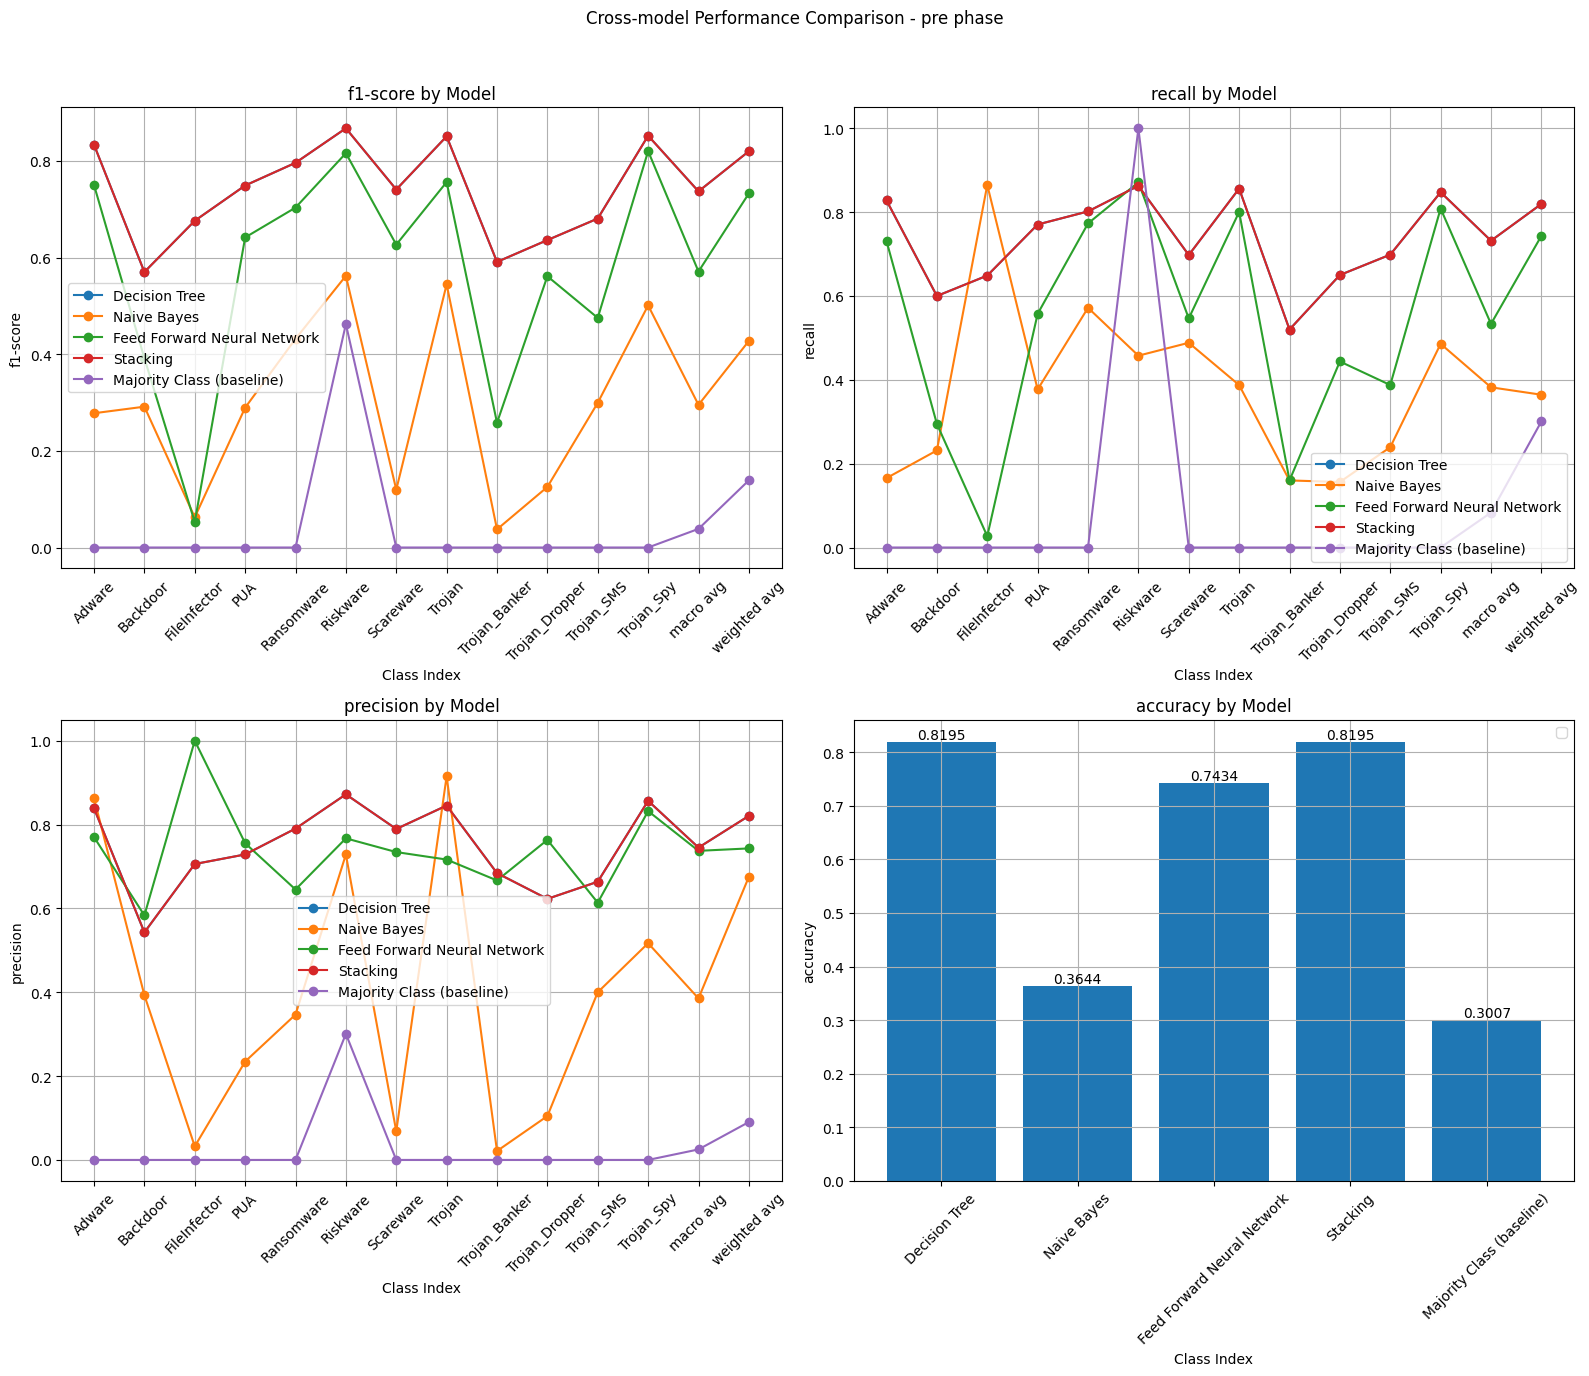

In [70]:
pipeline_manager.pipelines_analysis.plot_cross_model_comparison(metric=["f1-score", "recall", "precision", "accuracy"], save_plots=False, save_path="")


Metrics df:                                                   id            timeStamp  \
0  edfc481dab4a153f3c5b05c64623b6968a92f46b02e5c1...  2025-05-04 17:17:16   

                                 comments      modelName currentPhase  \
0  I know cate will not like this comment  Decision Tree          pre   

                                       features_used  \
0  [Memory_PssTotal, Memory_PssClean, Memory_Shar...   

                                     hyperParameters  timeToFit  \
0  {'ccp_alpha': 0.0, 'class_weight': None, 'crit...   4.393155   

   timeToPredict classification_report  accuracy_val  accuracy_test  \
0       0.047531                  None      0.819477             -1   

   precision_val  precision_test  recall_val  recall_test  f1-score_val  \
0       0.820768              -1    0.819477           -1      0.819902   

   f1-score_test  
0             -1  


/Users/javierdominguezsegura/Academics/College/Courses/2nd year/ML/finalProject/ml-final-project/library/pipeline/analysis/pipelines_analysis.py:304: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=metrics_df, x='modelName', y=metric, ax=ax, palette="viridis")
/Users/javierdominguezsegura/Academics/College/Courses/2nd year/ML/finalProject/ml-final-project/library/pipeline/analysis/pipelines_analysis.py:304: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=metrics_df, x='modelName', y=metric, ax=ax, palette="viridis")


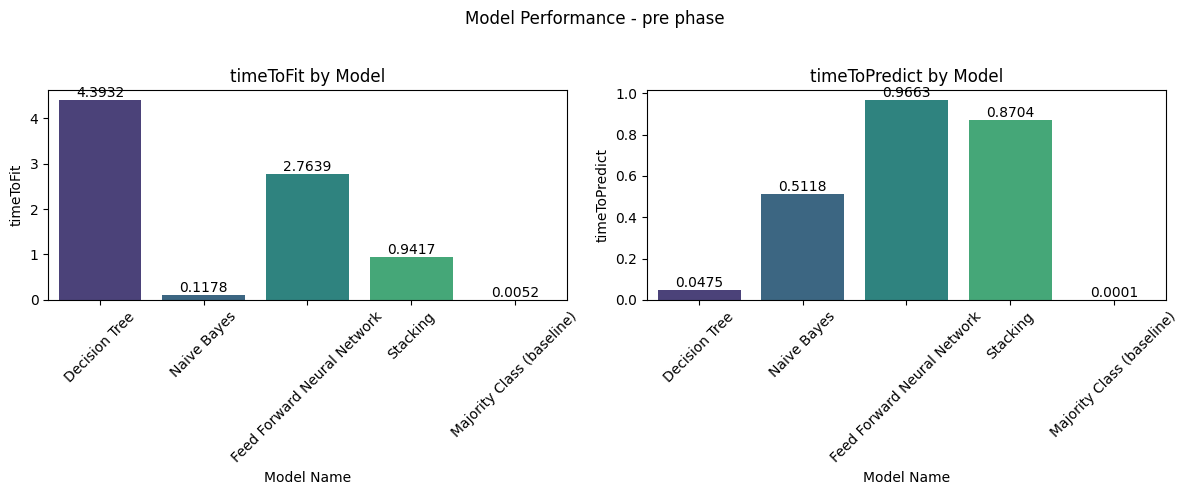

id            timeStamp  \
0  edfc481dab4a153f3c5b05c64623b6968a92f46b02e5c1...  2025-05-04 17:17:16   
0  7b8612217cc1dc2008f3d9f891155154d3be07f4ae7820...  2025-05-04 17:17:17   
0  dbbb5843411239cb9380b42acc3e6fe0724b371c4d5623...  2025-05-04 17:17:17   
0  78c8f24b98aac86c5ffb87fa19377574920a43769e61a3...  2025-05-04 17:17:17   
0  882c64283b0feb2722d60416f27770457df76340528664...  2025-05-04 17:17:17   

                                 comments                    modelName  \
0  I know cate will not like this comment                Decision Tree   
0  I know cate will not like this comment                  Naive Bayes   
0  I know cate will not like this comment  Feed Forward Neural Network   
0  I know cate will not like this comment                     Stacking   
0  I know cate will not like this comment    Majority Class (baseline)   

  currentPhase                                      features_used  \
0          pre  [Memory_PssTotal, Memory_PssClean, Memory_Shar...   
0          pre  [Memory_PssTotal, Memory_PssClean, Memory_Shar...   
0          pre  [Memory_PssTotal, Memory_PssClean, Memory_Shar...   
0          pre  [Memory_PssTotal, Memory_PssClean, Memory_Shar...   
0          pre  [Memory_PssTotal, Memory_PssClean, Memory_Shar...   

                                     hyperParameters  timeToFit  \
0  {'ccp_alpha': 0.0, 'class_weight': None, 'crit...   4.393155   
0           {'priors': None, 'var_smoothing': 1e-09}   0.117800   
0  {'num_features': 142, 'num_classes': 12, 'acti...   2.763879   
0  {'cv': 'prefit', 'estimators': [('Decision Tre...   0.941742   
0                                                 {}   0.005242   

   timeToPredict classification_report  accuracy_val  accuracy_test  \
0       0.047531                  None      0.819477             -1   
0       0.511835                  None      0.364448             -1   
0       0.966310                  None      0.743355             -1   
0       0.870412                  None      0.819477             -1   
0       0.000082                  None      0.300659             -1   

   precision_val  precision_test  recall_val  recall_test  f1-score_val  \
0       0.820768              -1    0.819477           -1      0.819902   
0       0.675410              -1    0.364448           -1      0.427402   
0       0.743120              -1    0.743355           -1      0.732640   
0       0.820768              -1    0.819477           -1      0.819902   
0       0.090396              -1    0.300659           -1      0.139000   

   f1-score_test  
0             -1  
0             -1  
0             -1  
0             -1  
0             -1

In [71]:
metrics_df = pipeline_manager.pipelines_analysis.plot_results_df(metrics=["timeToFit", "timeToPredict"], save_plots=False, save_path="")
metrics_df

### Results Summary Visualization

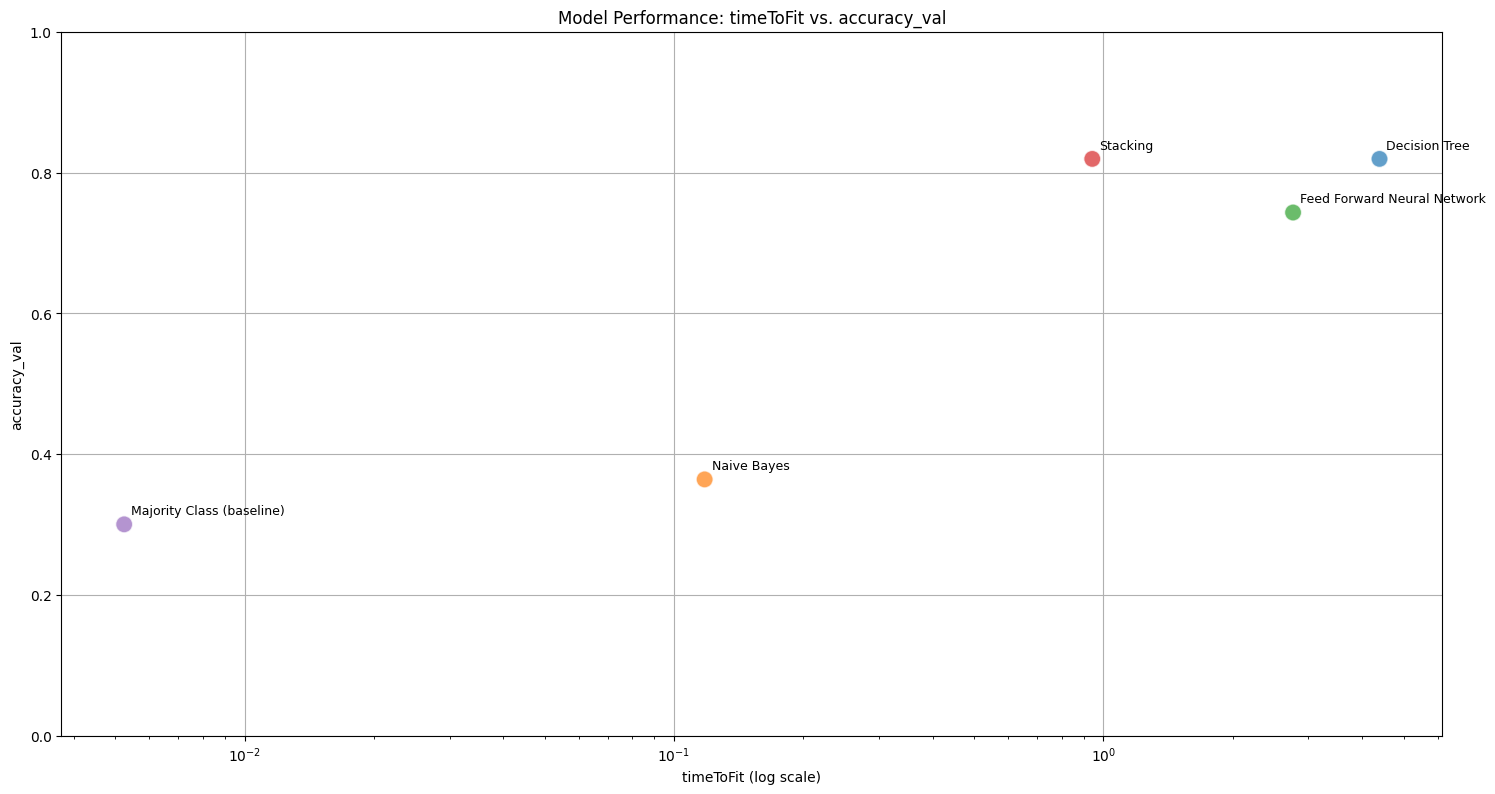

In [72]:
pipeline_manager.pipelines_analysis.plot_results_summary(training_metric="timeToFit", performance_metric="accuracy", save_plots=False, save_path="")

### Intra-model Evaluation (pre-tuning)
We plot 3 metrics (f1, recall and precision) for each model constrasting its performance between trainign and validation. It is not subject of interest cross-model evaluation, but rather, intra-model evaluation.

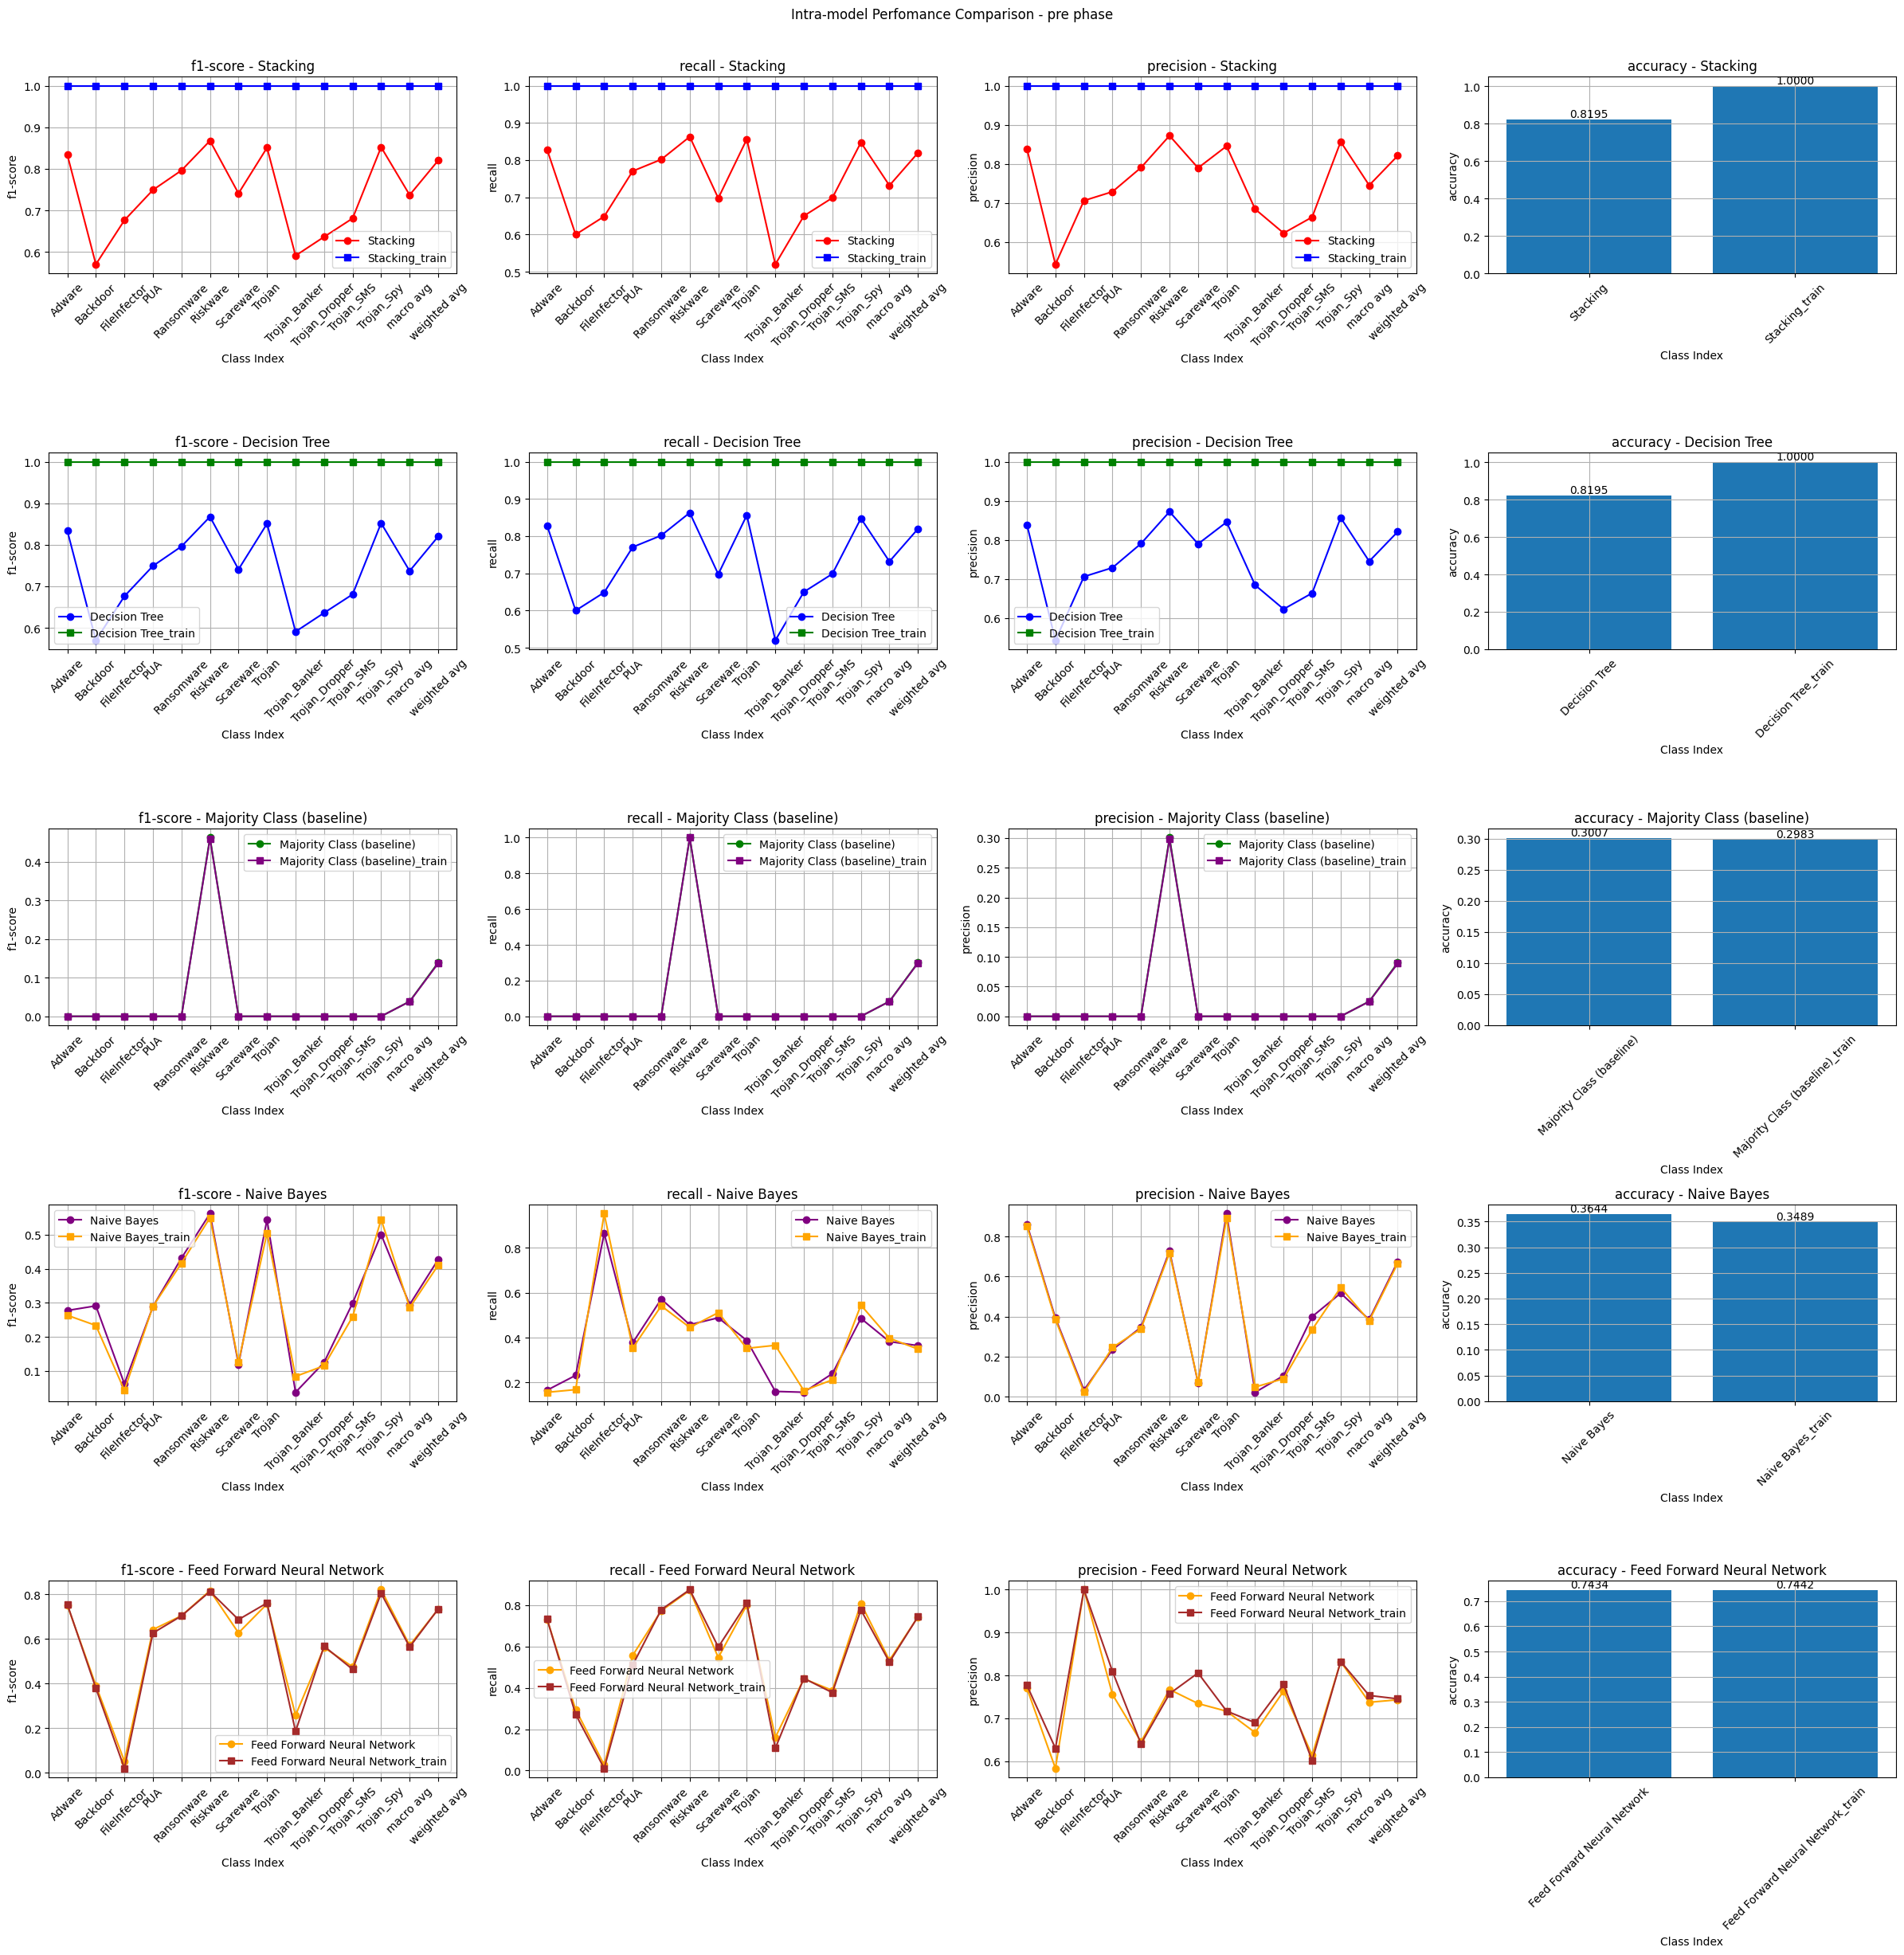

In [73]:
pipeline_manager.pipelines_analysis.plot_intra_model_comparison(metrics=["f1-score", "recall", "precision", "accuracy"], save_plots=False, save_path="")

We can also observe the progress per epoch so lets visualize that:

In [74]:
#pipeline_manager.pipelines["not_baseline"]["feed_forward_neural_network"].modelling.list_of_models["Feed Forward Neural Network"].tuning_states["pre"].assesment["model_sklearn"].history.history

In [75]:
#pipeline_manager.pipelines_analysis.plot_per_epoch_progress(metrics=["accuracy", "loss"], save_plots=False, save_path="")

### Residual analysis (pre-tuning)

This contains the confusion matrices (weighted and not weighted). 
It also returns the specific elements that were erroneously classified. The analysis of this residuals may be meaningful for further inspection (clustering analysis, EDA...)

Plotting: Decision Tree
Plotting: Naive Bayes
Plotting: Feed Forward Neural Network
Plotting: Stacking
Plotting: Majority Class (baseline)


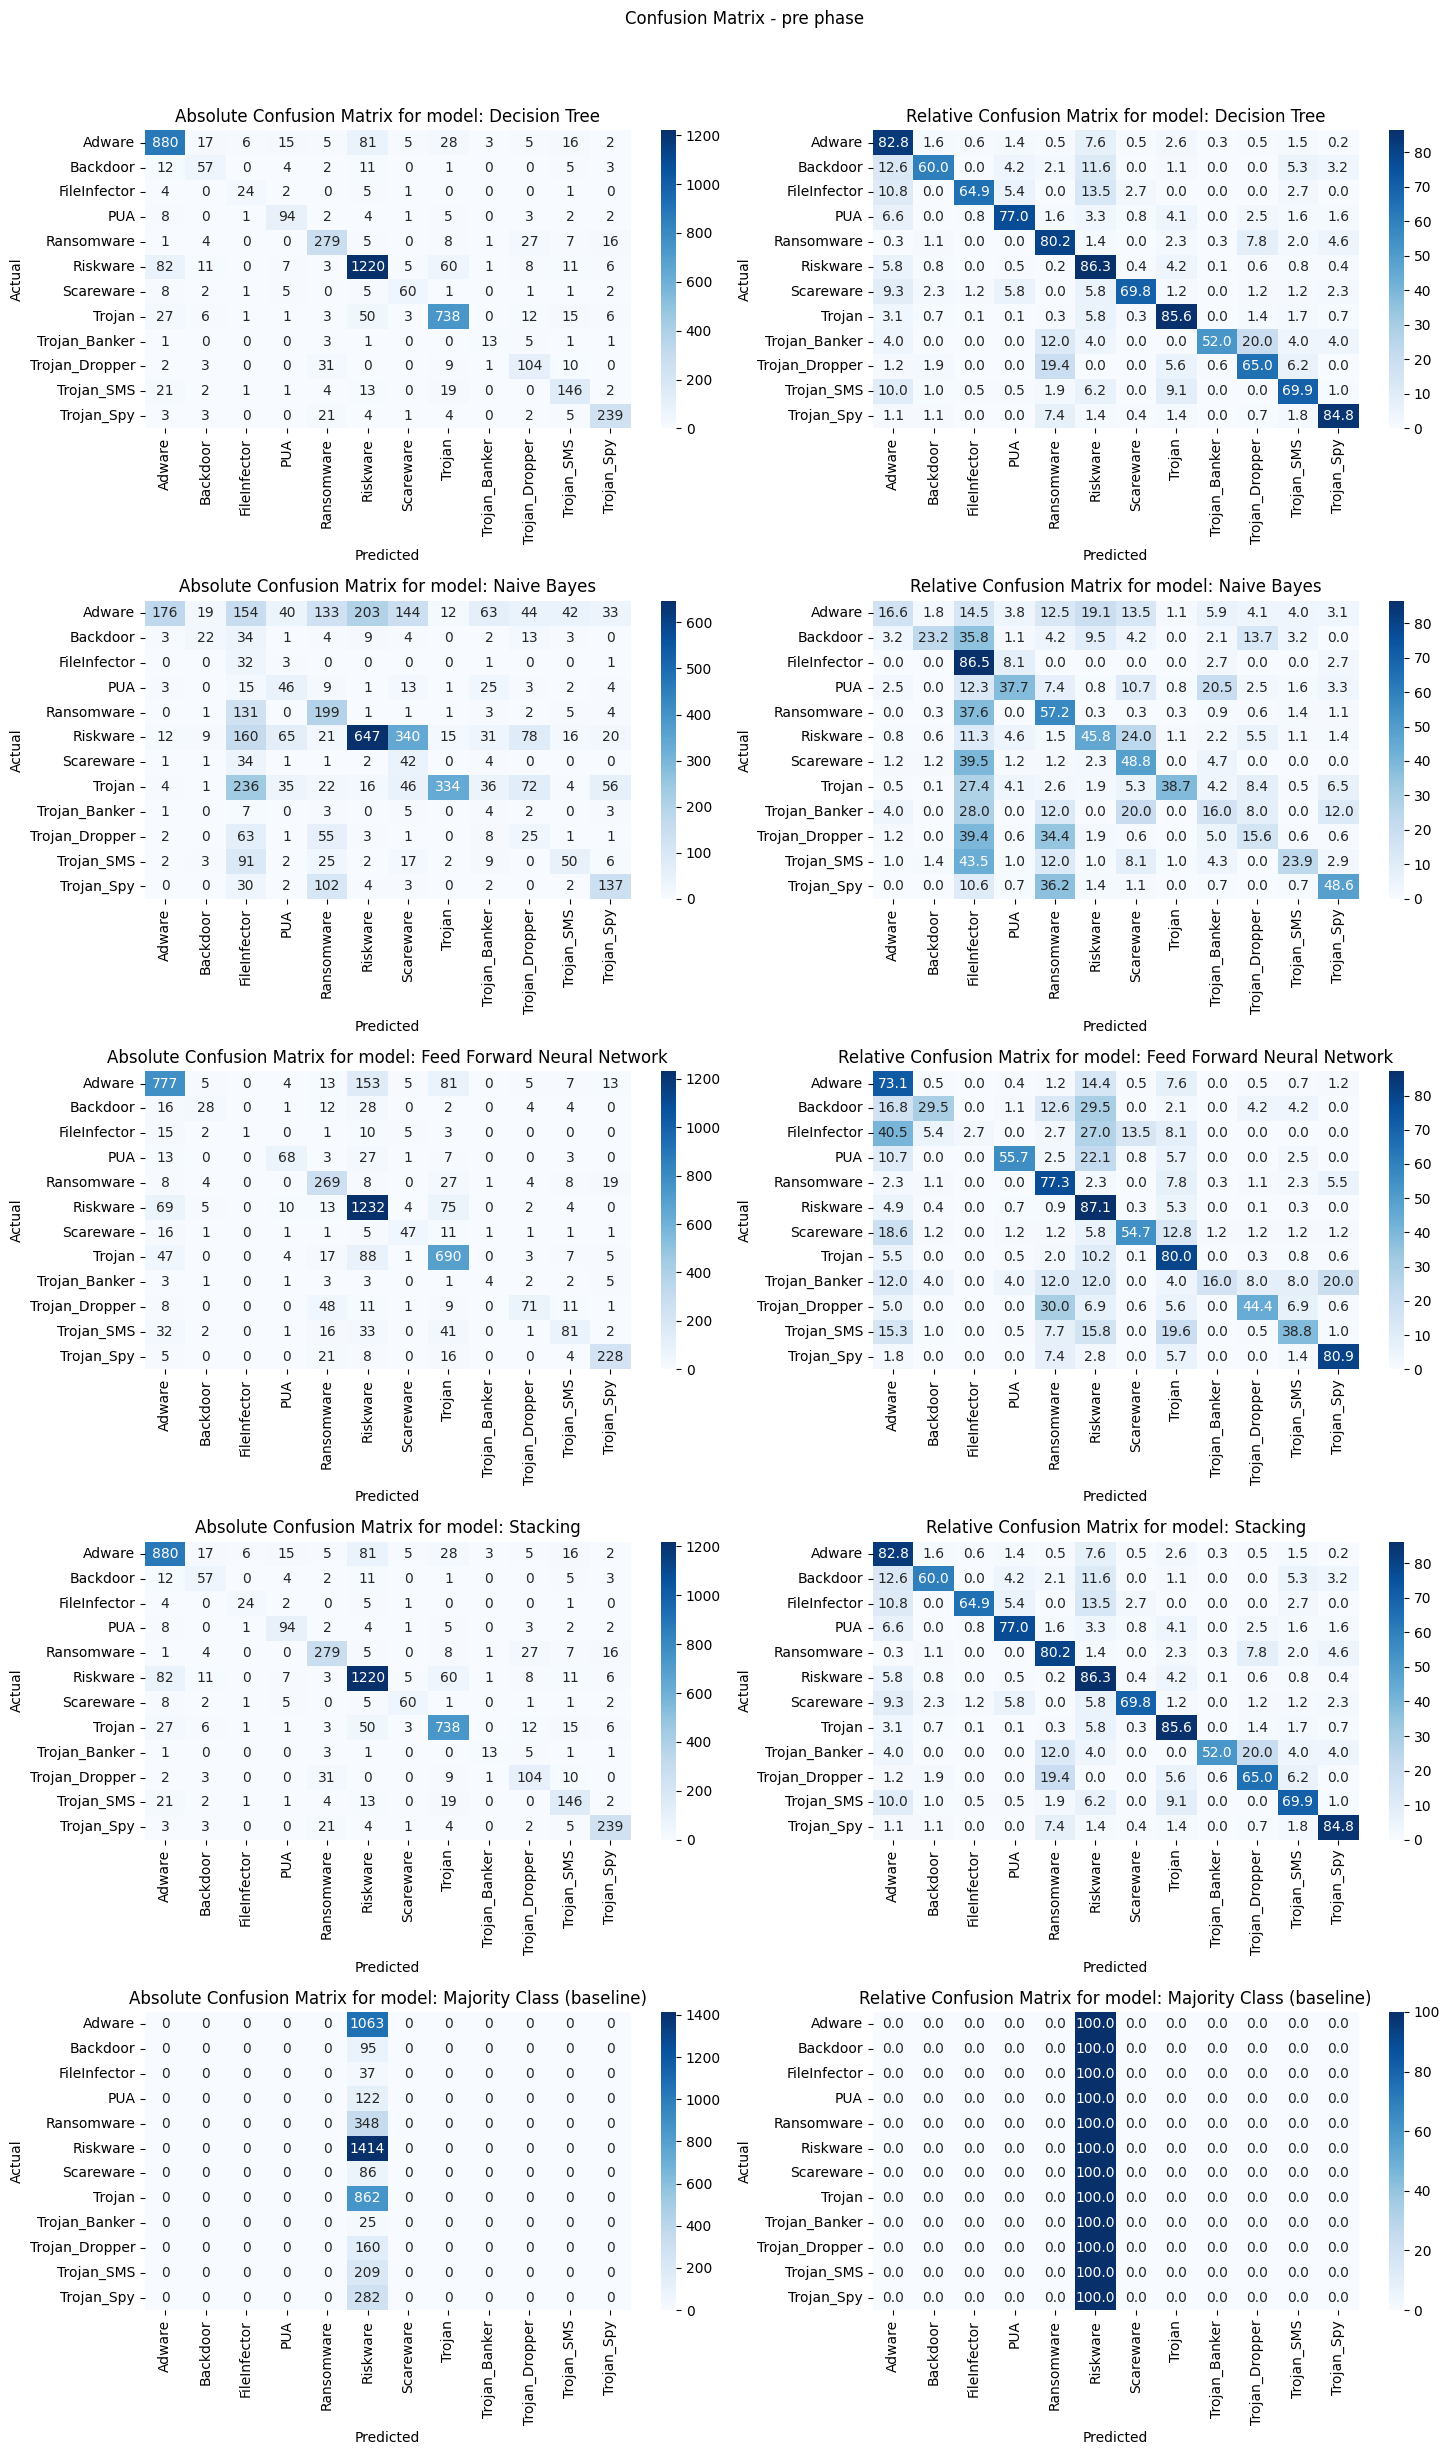

{'tree_based': 53099     3
 42114    11
 41946    10
 38536     5
 22423     5
          ..
 8398      0
 2906      0
 33099     7
 52857     3
 47610     7
 Length: 849, dtype: int64,
 'naive_bayes': 53099    3
 11712    0
 52498    3
 5763     0
 46186    7
         ..
 52857    3
 47610    7
 7212     0
 7612     0
 36519    5
 Length: 2989, dtype: int64,
 'feed_forward_neural_network': 53099     3
 46186     7
 41946    10
 50039     4
 7402      8
          ..
 49826     4
 1005     10
 2906      0
 33099     7
 52857     3
 Length: 1207, dtype: int64,
 'stacking': 53099     3
 42114    11
 41946    10
 38536     5
 22423     5
          ..
 8398      0
 2906      0
 33099     7
 52857     3
 47610     7
 Length: 849, dtype: int64,
 'baselines': 53099    3
 30660    7
 11712    0
 52498    3
 5763     0
         ..
 47610    7
 44394    7
 7212     0
 7612     0
 46313    7
 Length: 3289, dtype: int64}

In [76]:
residuals, confusion_matrices = pipeline_manager.pipelines_analysis.plot_confusion_matrix(save_plots=False, save_path="")
residuals

### Feature importances (pre-tuning)

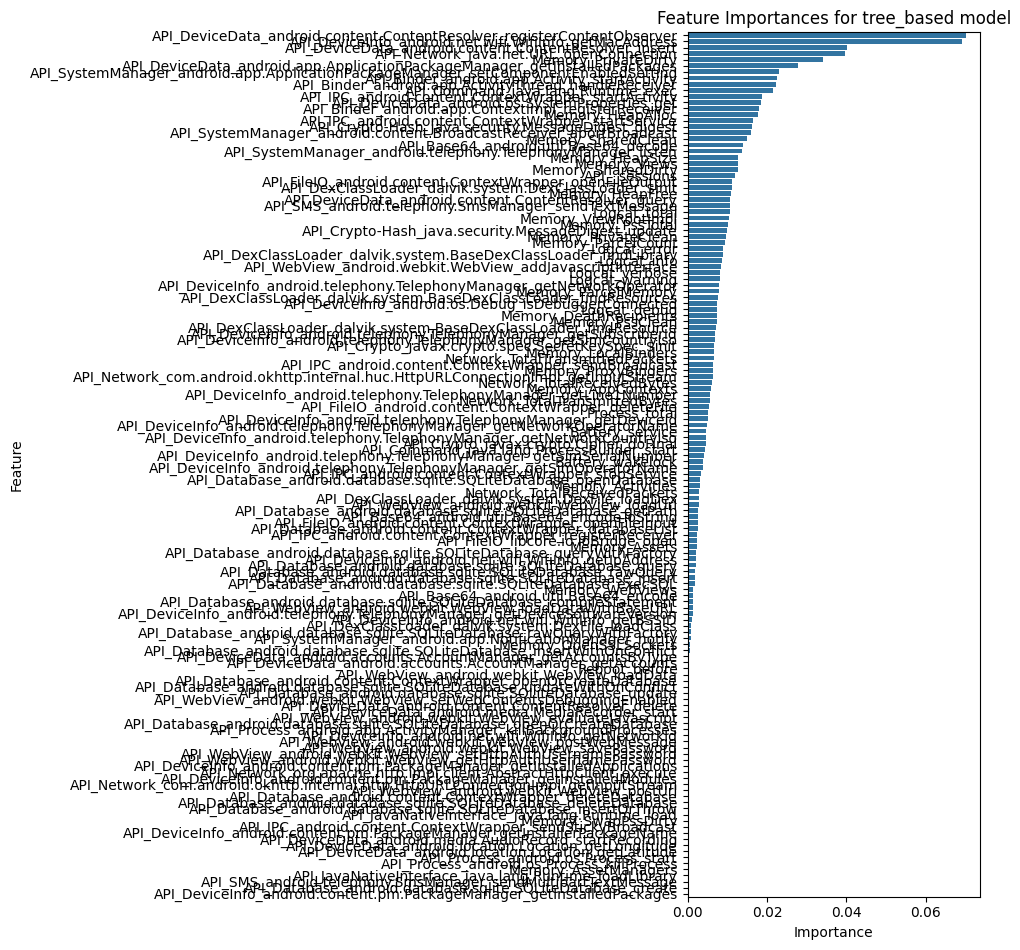

{'tree_based':                                                Feature  Importance
 116  API_DeviceData_android.content.ContentResolver...    0.070173
 83   API_DeviceInfo_android.net.wifi.WifiInfo_getMa...    0.069107
 117  API_DeviceData_android.content.ContentResolver...    0.040097
 96             API_Network_java.net.URL_openConnection    0.039771
 3                                  Memory_PrivateDirty    0.034230
 ..                                                 ...         ...
 15                                Memory_AssetManagers    0.000000
 28   API_JavaNativeInterface_java.lang.Runtime_load...    0.000000
 114  API_SMS_android.telephony.SmsManager_sendMulti...    0.000000
 63   API_Database_android.database.sqlite.SQLiteDat...    0.000000
 95   API_DeviceInfo_android.content.pm.PackageManag...    0.000000
 
 [142 rows x 2 columns]}

In [77]:
importances_dfs = pipeline_manager.pipelines_analysis.plot_feature_importance(save_plots=False, save_path="")
importances_dfs

## Hyperparameter Optimization
1. Bind the grids to each model in each pipeline
2. Start all optimizations in parallel

In [78]:
pipeline_manager.pipeline_state = "in"

In [79]:
rf_grid = {
      'n_estimators': [50, 100, 150, 200], 
      'max_depth': [None, 10, 20, 30], 
      'min_samples_split': [2, 5, 10], 
      'min_samples_leaf': [1, 2, 4,]
}

dt_grid = {
    'criterion': ['gini', 'entropy'],
    'max_depth': [None, 10, 20, 30],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 5],
    'max_features': [None, 'sqrt', 'log2'],
    'ccp_alpha': [0.0, 0.01, 0.1]

} 

gnb_grid = {
    'var_smoothing': Real(1e-12, 1e-6, prior='log-uniform')
}

In [80]:
modelNameToOptimizer = {
                  "Random Forest": {
                        "optimizer_type": "bayes",
                        "param_grid": rf_grid,
                        "max_iter": 1
                  },
                  "Decision Tree": {
                        "optimizer_type": "bayes",
                        "param_grid": dt_grid,
                        "max_iter": 1
                  },
                  "Naive Bayes": {
                        "optimizer_type": "bayes",
                        "param_grid": gnb_grid,
                        "max_iter": 1
                  },
                  "Feed Forward Neural Network": {
                        "optimizer_type": "bayes_nn",
                        "param_grid": None, # its hardcoded
                        "max_iter": 2,
                        "epochs": 2 
                  }
            }

In [81]:
optimized_models = pipeline_manager.all_pipelines_execute(methodName="modelling.fit_models", 
                                       exclude_pipeline_names=["stacking"],
                                       current_phase=pipeline_manager.pipeline_state,
                                       modelNameToOptimizer=modelNameToOptimizer)

Trial 2 Complete [00h 00m 03s]
val_accuracy: 0.743567943572998

Best val_accuracy So Far: 0.7650436162948608
Total elapsed time: 00h 00m 05s
 => FINISHED OPTIMIZATION FOR Feed Forward Neural Network
Best params: {'n_layers': 2, 'units_0': 256, 'act_0': 'relu', 'learning_rate': 0.0014568133071965574, 'units_1': 128, 'act_1': 'relu'}
=> Predicting Feed Forward Neural Network model
!> Started predicting Feed Forward Neural Network
Predicting training data
 248/1176 ━━━━━━━━━━━━━━━━━━━━ 0s 407us/step

/Users/javierdominguezsegura/Academics/College/Courses/2nd year/ML/finalProject/ml-final-project/.venv/lib/python3.11/site-packages/keras/src/saving/saving_lib.py:757: UserWarning: Skipping variable loading for optimizer 'adamw', because it has 2 variables whereas the saved optimizer has 14 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


1176/1176 ━━━━━━━━━━━━━━━━━━━━ 1s 418us/step
Predicting not training data
=> Fitting Decision Tree model
Model object: <library.phases.phases_implementation.modelling.shallow.model_definition.model_types.classifier.Classifier object at 0x2973e0f90> for Decision Tree
Model object: <library.phases.phases_implementation.modelling.shallow.model_definition.model_types.classifier.Classifier object at 0x2973e0f90>
=> Fitting Naive Bayes model
Model object: <library.phases.phases_implementation.modelling.shallow.model_definition.model_types.classifier.Classifier object at 0x2930d9610> for Naive Bayes
Model object: <library.phases.phases_implementation.modelling.shallow.model_definition.model_types.classifier.Classifier object at 0x2930d9610>
 => STARTING OPTIMIZATION FOR Naive Bayes
  1/147 ━━━━━━━━━━━━━━━━━━━━ 2s 14ms/stepFitting 5 folds for each of 1 candidates, totalling 5 fits
 => STARTING OPTIMIZATION FOR Decision Tree
Fitting 5 folds for each of 1 candidates, totalling 5 fits
147/147 ━━━

Lets visualize the resutls of the optimized models

In [82]:
pipeline_manager.pipelines["not_baseline"]["feed_forward_neural_network"].modelling.list_of_models

{'Feed Forward Neural Network': <library.phases.phases_implementation.modelling.shallow.model_definition.model_types.classifier.Classifier at 0x285955e90>}

In [83]:
optimized_models

{'not_baseline': {'support_vector_machine': {},
  'ensembled': {},
  'feed_forward_neural_network': {'Feed Forward Neural Network': FeedForwardNeuralNetwork(activations=['relu', 'relu'],
                            learning_rate=0.0014568133071965574, num_classes=12,
                            num_features=142)},
  'naive_bayes': {'Naive Bayes': GaussianNB(var_smoothing=2.888176653914472e-10)},
  'tree_based': {'Decision Tree': DecisionTreeClassifier(ccp_alpha=0.01, criterion='entropy', max_depth=30,
                          min_samples_leaf=5, min_samples_split=5)}},
 'baseline': {'baselines': {}}}

If you want to see the cross validation progress for a given model you just need to:

## Stacking Model: Training and Hyperparamter Optimization

In [84]:
estimators = []

for pipelineName, results in optimized_models["not_baseline"].items():
      if isinstance(results, dict):
            for modelName, modelObject in results.items():
                  estimators.append((modelName, modelObject))

estimators

[('Feed Forward Neural Network',
  FeedForwardNeuralNetwork(activations=['relu', 'relu'],
                           learning_rate=0.0014568133071965574, num_classes=12,
                           num_features=142)),
 ('Naive Bayes', GaussianNB(var_smoothing=2.888176653914472e-10)),
 ('Decision Tree',
  DecisionTreeClassifier(ccp_alpha=0.01, criterion='entropy', max_depth=30,
                         min_samples_leaf=5, min_samples_split=5))]

In [85]:
#Stacking model
stackingModel = StackingClassifier(
      estimators=estimators,
      final_estimator=DecisionTreeClassifier(),
      cv="prefit",
      verbose=3
)
stackingModel

StackingClassifier(cv='prefit',
                   estimators=[('Feed Forward Neural Network',
                                FeedForwardNeuralNetwork(activations=['relu',
                                                                      'relu'],
                                                         learning_rate=0.0014568133071965574,
                                                         num_classes=12,
                                                         num_features=142)),
                               ('Naive Bayes',
                                GaussianNB(var_smoothing=2.888176653914472e-10)),
                               ('Decision Tree',
                                DecisionTreeClassifier(ccp_alpha=0.01,
                                                       criterion='entropy',
                                                       max_depth=30,
                                                       min_samples_leaf=5,
                                                       min_samples_split=5))],
                   final_estimator=DecisionTreeClassifier(), verbose=3)

In [86]:
X_train = pipeline_manager.pipelines["not_baseline"]["stacking"].dataset.X_train
y_train = pipeline_manager.pipelines["not_baseline"]["stacking"].dataset.y_train
X_val = pipeline_manager.pipelines["not_baseline"]["stacking"].dataset.X_val


In [87]:
stackingModel.fit(X_train, y_train)

1176/1176 ━━━━━━━━━━━━━━━━━━━━ 0s 383us/step


StackingClassifier(cv='prefit',
                   estimators=[('Feed Forward Neural Network',
                                FeedForwardNeuralNetwork(activations=['relu',
                                                                      'relu'],
                                                         learning_rate=0.0014568133071965574,
                                                         num_classes=12,
                                                         num_features=142)),
                               ('Naive Bayes',
                                GaussianNB(var_smoothing=2.888176653914472e-10)),
                               ('Decision Tree',
                                DecisionTreeClassifier(ccp_alpha=0.01,
                                                       criterion='entropy',
                                                       max_depth=30,
                                                       min_samples_leaf=5,
                                                       min_samples_split=5))],
                   final_estimator=DecisionTreeClassifier(), verbose=3)

In [88]:
stackingModel.predict(X_val)
stackingModel

147/147 ━━━━━━━━━━━━━━━━━━━━ 0s 454us/step


StackingClassifier(cv='prefit',
                   estimators=[('Feed Forward Neural Network',
                                FeedForwardNeuralNetwork(activations=['relu',
                                                                      'relu'],
                                                         learning_rate=0.0014568133071965574,
                                                         num_classes=12,
                                                         num_features=142)),
                               ('Naive Bayes',
                                GaussianNB(var_smoothing=2.888176653914472e-10)),
                               ('Decision Tree',
                                DecisionTreeClassifier(ccp_alpha=0.01,
                                                       criterion='entropy',
                                                       max_depth=30,
                                                       min_samples_leaf=5,
                                                       min_samples_split=5))],
                   final_estimator=DecisionTreeClassifier(), verbose=3)

In [89]:
pipeline_manager.pipelines["not_baseline"]["stacking"].modelling.list_of_models["Stacking"].tuning_states["in"].assesment["model_sklearn"] = stackingModel
pipeline_manager.pipelines["not_baseline"]["stacking"].modelling.list_of_models["Stacking"].tuning_states["post"].assesment["model_sklearn"] = stackingModel

In [90]:
pipeline_manager.pipelines["not_baseline"]["stacking"].modelling.list_of_models["Stacking"].tuning_states["in"].model_sklearn = stackingModel
pipeline_manager.pipelines["not_baseline"]["stacking"].modelling.list_of_models["Stacking"].tuning_states["post"].model_sklearn = stackingModel


In [91]:
stackingModel.estimators

[('Feed Forward Neural Network',
  FeedForwardNeuralNetwork(activations=['relu', 'relu'],
                           learning_rate=0.0014568133071965574, num_classes=12,
                           num_features=142)),
 ('Naive Bayes', GaussianNB(var_smoothing=2.888176653914472e-10)),
 ('Decision Tree',
  DecisionTreeClassifier(ccp_alpha=0.01, criterion='entropy', max_depth=30,
                         min_samples_leaf=5, min_samples_split=5))]

In [92]:
pipeline_manager.pipelines["not_baseline"]["stacking"].modelling.list_of_models["Stacking"].tuning_states["in"].assesment["model_sklearn"]


StackingClassifier(cv='prefit',
                   estimators=[('Feed Forward Neural Network',
                                FeedForwardNeuralNetwork(activations=['relu',
                                                                      'relu'],
                                                         learning_rate=0.0014568133071965574,
                                                         num_classes=12,
                                                         num_features=142)),
                               ('Naive Bayes',
                                GaussianNB(var_smoothing=2.888176653914472e-10)),
                               ('Decision Tree',
                                DecisionTreeClassifier(ccp_alpha=0.01,
                                                       criterion='entropy',
                                                       max_depth=30,
                                                       min_samples_leaf=5,
                                                       min_samples_split=5))],
                   final_estimator=DecisionTreeClassifier(), verbose=3)

In [93]:
all_pipelines_to_exclude = []

for pipelineName, pipelineObject in pipeline_manager.pipelines["not_baseline"].items():
      if pipelineName == "stacking":
            continue
      all_pipelines_to_exclude.append(pipelineName)

all_pipelines_to_exclude


['ensembled',
 'tree_based',
 'support_vector_machine',
 'naive_bayes',
 'feed_forward_neural_network']

In [94]:
pipeline_manager.all_pipelines_execute(methodName="modelling.fit_models", 
                                       current_phase=pipeline_manager.pipeline_state,
                                       exclude_category="baseline",
                                       exclude_pipeline_names=all_pipelines_to_exclude
                                       )

Skipping pipeline ensembled in category not_baseline because it is in the exclude list
Skipping pipeline tree_based in category not_baseline because it is in the exclude list
Skipping pipeline support_vector_machine in category not_baseline because it is in the exclude list
Skipping pipeline naive_bayes in category not_baseline because it is in the exclude list
Skipping pipeline feed_forward_neural_network in category not_baseline because it is in the exclude list
Gonna start fitting models in in phase
=> Fitting Stacking model
Model object: None for Stacking
Sklearn model for stacking has predictors: [('Feed Forward Neural Network', FeedForwardNeuralNetwork(activations=['relu', 'relu'],
                         learning_rate=0.0014568133071965574, num_classes=12,
                         num_features=142)), ('Naive Bayes', GaussianNB(var_smoothing=2.888176653914472e-10)), ('Decision Tree', DecisionTreeClassifier(ccp_alpha=0.01, criterion='entropy', max_depth=30,
                      

{'not_baseline': {'stacking': None}}

## In-tuning evaluation

In [95]:
pipeline_manager.pipelines["not_baseline"]["stacking"].modelling.list_of_models["Stacking"].tuning_states["in"].assesment["model_sklearn"]

StackingClassifier(cv='prefit',
                   estimators=[('Feed Forward Neural Network',
                                FeedForwardNeuralNetwork(activations=['relu',
                                                                      'relu'],
                                                         learning_rate=0.0014568133071965574,
                                                         num_classes=12,
                                                         num_features=142)),
                               ('Naive Bayes',
                                GaussianNB(var_smoothing=2.888176653914472e-10)),
                               ('Decision Tree',
                                DecisionTreeClassifier(ccp_alpha=0.01,
                                                       criterion='entropy',
                                                       max_depth=30,
                                                       min_samples_leaf=5,
                                                       min_samples_split=5))],
                   final_estimator=DecisionTreeClassifier(), verbose=3)

In [96]:
model_results = pipeline_manager.all_pipelines_execute(methodName="modelling.evaluate_and_store_models", 
                                                       exclude_category="baseline",
                                                       comments=comments, 
                                                       current_phase=pipeline_manager.pipeline_state)

Evaluating model Feed Forward Neural Network
Evaluating Feed Forward Neural Network in in phase
METRIC RESULTS FOR Feed Forward Neural Network => F1: 0.7533034819438024, Precision: 0.7586031540855512, Recall: 0.765043589198384, Accuracy: 0.765043589198384


/Users/javierdominguezsegura/Academics/College/Courses/2nd year/ML/finalProject/ml-final-project/.venv/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/javierdominguezsegura/Academics/College/Courses/2nd year/ML/finalProject/ml-final-project/.venv/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/javierdominguezsegura/Academics/College/Courses/2nd year/ML/finalProject/ml-final-project/.venv/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1565: Undefined

Evaluating model Naive Bayes
Evaluating Naive Bayes in in phase
Evaluating model Decision Tree
Evaluating Decision Tree in in phase
METRIC RESULTS FOR Naive Bayes => F1: 0.42111415936925517, Precision: 0.6782847052729436, Recall: 0.35764405698490326, Accuracy: 0.35764405698490326
METRIC RESULTS FOR Decision Tree => F1: 0.6125515235728184, Precision: 0.6008532417688947, Recall: 0.6372528173506272, Accuracy: 0.6372528173506272
Evaluating model Stacking
Evaluating Stacking in in phase
METRIC RESULTS FOR Stacking => F1: 0.7737938109335357, Precision: 0.7744957674343207, Recall: 0.7739740591112056, Accuracy: 0.7739740591112056


/Users/javierdominguezsegura/Academics/College/Courses/2nd year/ML/finalProject/ml-final-project/.venv/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/javierdominguezsegura/Academics/College/Courses/2nd year/ML/finalProject/ml-final-project/.venv/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/javierdominguezsegura/Academics/College/Courses/2nd year/ML/finalProject/ml-final-project/.venv/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1565: Undefined

****WARNING****: A model with the same values already exists in the results. Results will not be saved. 
                               You tried to write {'id': 'e06dc18f115be574c0d7150125140b1583629b860275206f81df475ceebad8ec', 'timeStamp': '2025-05-04 17:17:59', 'comments': 'I know cate will not like this comment', 'modelName': 'Naive Bayes', 'currentPhase': 'in', 'features_used': ['Memory_PssTotal', 'Memory_PssClean', 'Memory_SharedDirty', 'Memory_PrivateDirty', 'Memory_SharedClean', 'Memory_PrivateClean', 'Memory_SwapPssDirty', 'Memory_HeapSize', 'Memory_HeapAlloc', 'Memory_HeapFree', 'Memory_Views', 'Memory_ViewRootImpl', 'Memory_AppContexts', 'Memory_Activities', 'Memory_Assets', 'Memory_AssetManagers', 'Memory_LocalBinders', 'Memory_ProxyBinders', 'Memory_ParcelMemory', 'Memory_ParcelCount', 'Memory_DeathRecipients', 'Memory_OpenSSLSockets', 'Memory_WebViews', 'API_Process_android.os.Process_start', 'API_Process_android.app.ActivityManager_killBackgroundProcesses', 'API_Process

### Cross-Model Evaluation (in-tuning)

In [97]:
pipeline_manager.pipelines_analysis._compute_classification_report().columns

Index(['precision', 'recall', 'f1-score', 'support', 'accuracy', 'precision',
       'recall', 'f1-score', 'support', 'accuracy', 'precision', 'recall',
       'f1-score', 'support', 'accuracy', 'precision', 'recall', 'f1-score',
       'support', 'accuracy'],
      dtype='object')

In [98]:
import math

PLOTTING CROSS MODEL COMPARISON FOR in PHASE
Plotting: f1-score
Plotting: recall
Plotting: precision
Plotting: accuracy


/Users/javierdominguezsegura/Academics/College/Courses/2nd year/ML/finalProject/ml-final-project/library/pipeline/analysis/pipelines_analysis.py:163: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  ax.legend()


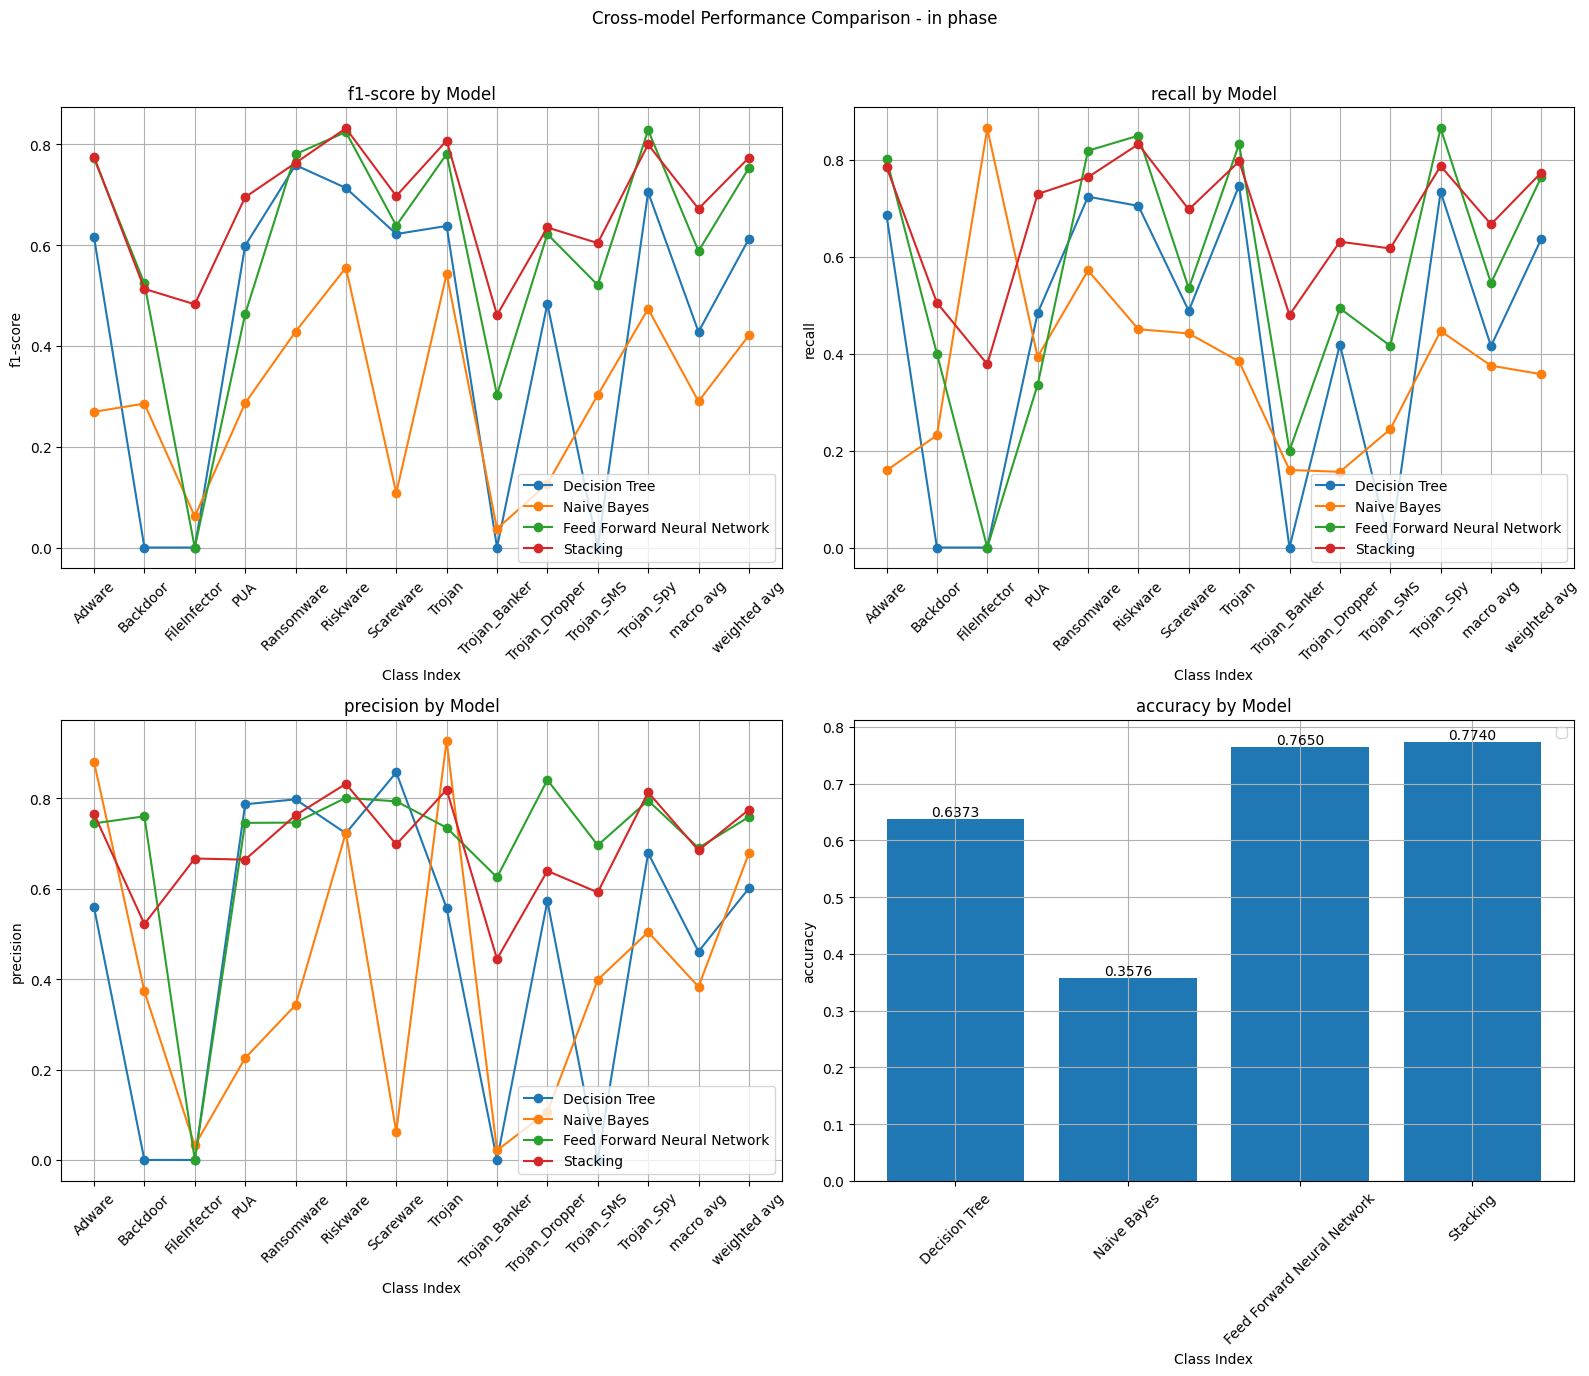

In [99]:
pipeline_manager.pipelines_analysis.plot_cross_model_comparison( metric=["f1-score", "recall", "precision", "accuracy"], save_plots=False, save_path="")

Metrics df:                                                   id            timeStamp  \
0  d376dd27b2c203d14941129df56325a29a77bb8c3520e8...  2025-05-04 17:17:59   

                                 comments      modelName currentPhase  \
0  I know cate will not like this comment  Decision Tree           in   

                                       features_used  \
0  [Memory_PssTotal, Memory_PssClean, Memory_Shar...   

                                     hyperParameters  timeToFit  \
0  {'ccp_alpha': 0.01, 'class_weight': None, 'cri...  12.942963   

   timeToPredict classification_report  accuracy_val  accuracy_test  \
0       0.017423                  None      0.637253             -1   

   precision_val  precision_test  recall_val  recall_test  f1-score_val  \
0       0.600853              -1    0.637253           -1      0.612552   

   f1-score_test  
0             -1  


/Users/javierdominguezsegura/Academics/College/Courses/2nd year/ML/finalProject/ml-final-project/library/pipeline/analysis/pipelines_analysis.py:304: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=metrics_df, x='modelName', y=metric, ax=ax, palette="viridis")
/Users/javierdominguezsegura/Academics/College/Courses/2nd year/ML/finalProject/ml-final-project/library/pipeline/analysis/pipelines_analysis.py:304: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=metrics_df, x='modelName', y=metric, ax=ax, palette="viridis")


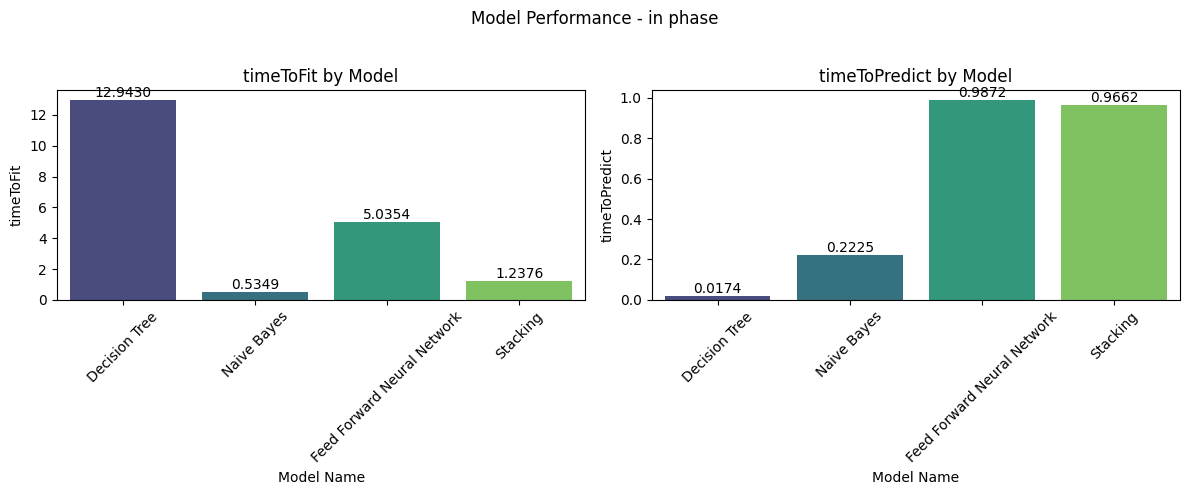

id            timeStamp  \
0  d376dd27b2c203d14941129df56325a29a77bb8c3520e8...  2025-05-04 17:17:59   
0  e06dc18f115be574c0d7150125140b1583629b86027520...  2025-05-04 17:17:59   
0  e6680f9641bace3175dabd82ce373ae427198499b75f7e...  2025-05-04 17:17:51   
0  4d5ee9ce34b22d58756822b35bdecbd237ae083cec2585...  2025-05-04 17:17:59   

                                 comments                    modelName  \
0  I know cate will not like this comment                Decision Tree   
0  I know cate will not like this comment                  Naive Bayes   
0  I know cate will not like this comment  Feed Forward Neural Network   
0  I know cate will not like this comment                     Stacking   

  currentPhase                                      features_used  \
0           in  [Memory_PssTotal, Memory_PssClean, Memory_Shar...   
0           in  [Memory_PssTotal, Memory_PssClean, Memory_Shar...   
0           in  [Memory_PssTotal, Memory_PssClean, Memory_Shar...   
0           in  [Memory_PssTotal, Memory_PssClean, Memory_Shar...   

                                     hyperParameters  timeToFit  \
0  {'ccp_alpha': 0.01, 'class_weight': None, 'cri...  12.942963   
0  {'priors': None, 'var_smoothing': 2.8881766539...   0.534939   
0  {'num_features': 142, 'num_classes': 12, 'acti...   5.035389   
0  {'cv': 'prefit', 'estimators': [('Feed Forward...   1.237567   

   timeToPredict classification_report  accuracy_val  accuracy_test  \
0       0.017423                  None      0.637253             -1   
0       0.222463                  None      0.357644             -1   
0       0.987191                  None      0.765044             -1   
0       0.966184                  None      0.773974             -1   

   precision_val  precision_test  recall_val  recall_test  f1-score_val  \
0       0.600853              -1    0.637253           -1      0.612552   
0       0.678285              -1    0.357644           -1      0.421114   
0       0.758603              -1    0.765044           -1      0.753303   
0       0.774496              -1    0.773974           -1      0.773794   

   f1-score_test  
0             -1  
0             -1  
0             -1  
0             -1

In [100]:
pipeline_manager.pipelines_analysis.plot_results_df(metrics=["timeToFit", "timeToPredict"], save_plots=False, save_path="")
# Note I still have not added a way to extract the fitting time from the in-tuning phase

### Results Summary Visualization

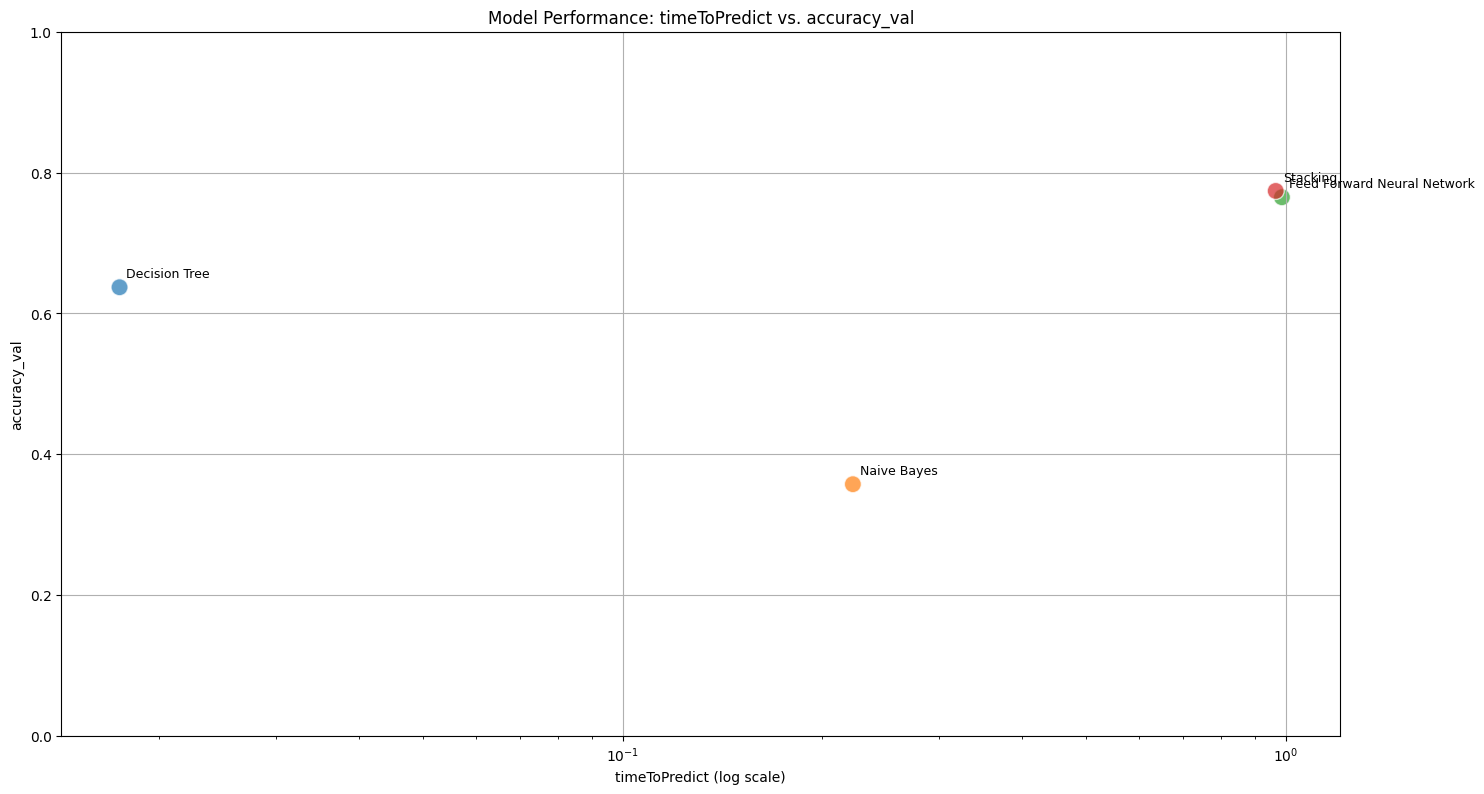

In [101]:
pipeline_manager.pipelines_analysis.plot_results_summary(training_metric="timeToPredict", performance_metric="accuracy", save_plots=False, save_path="")

### Intra-model Evaluation (in-tuning)
We plot 3 metrics (f1, recall and precision) for each model constrasting its performance between trainign and validation. It is not subject of interest cross-model evaluation, but rather, intra-model evaluation.

** EVALUATE HERE THE NOT OPTIMIZED VERSION TOO **

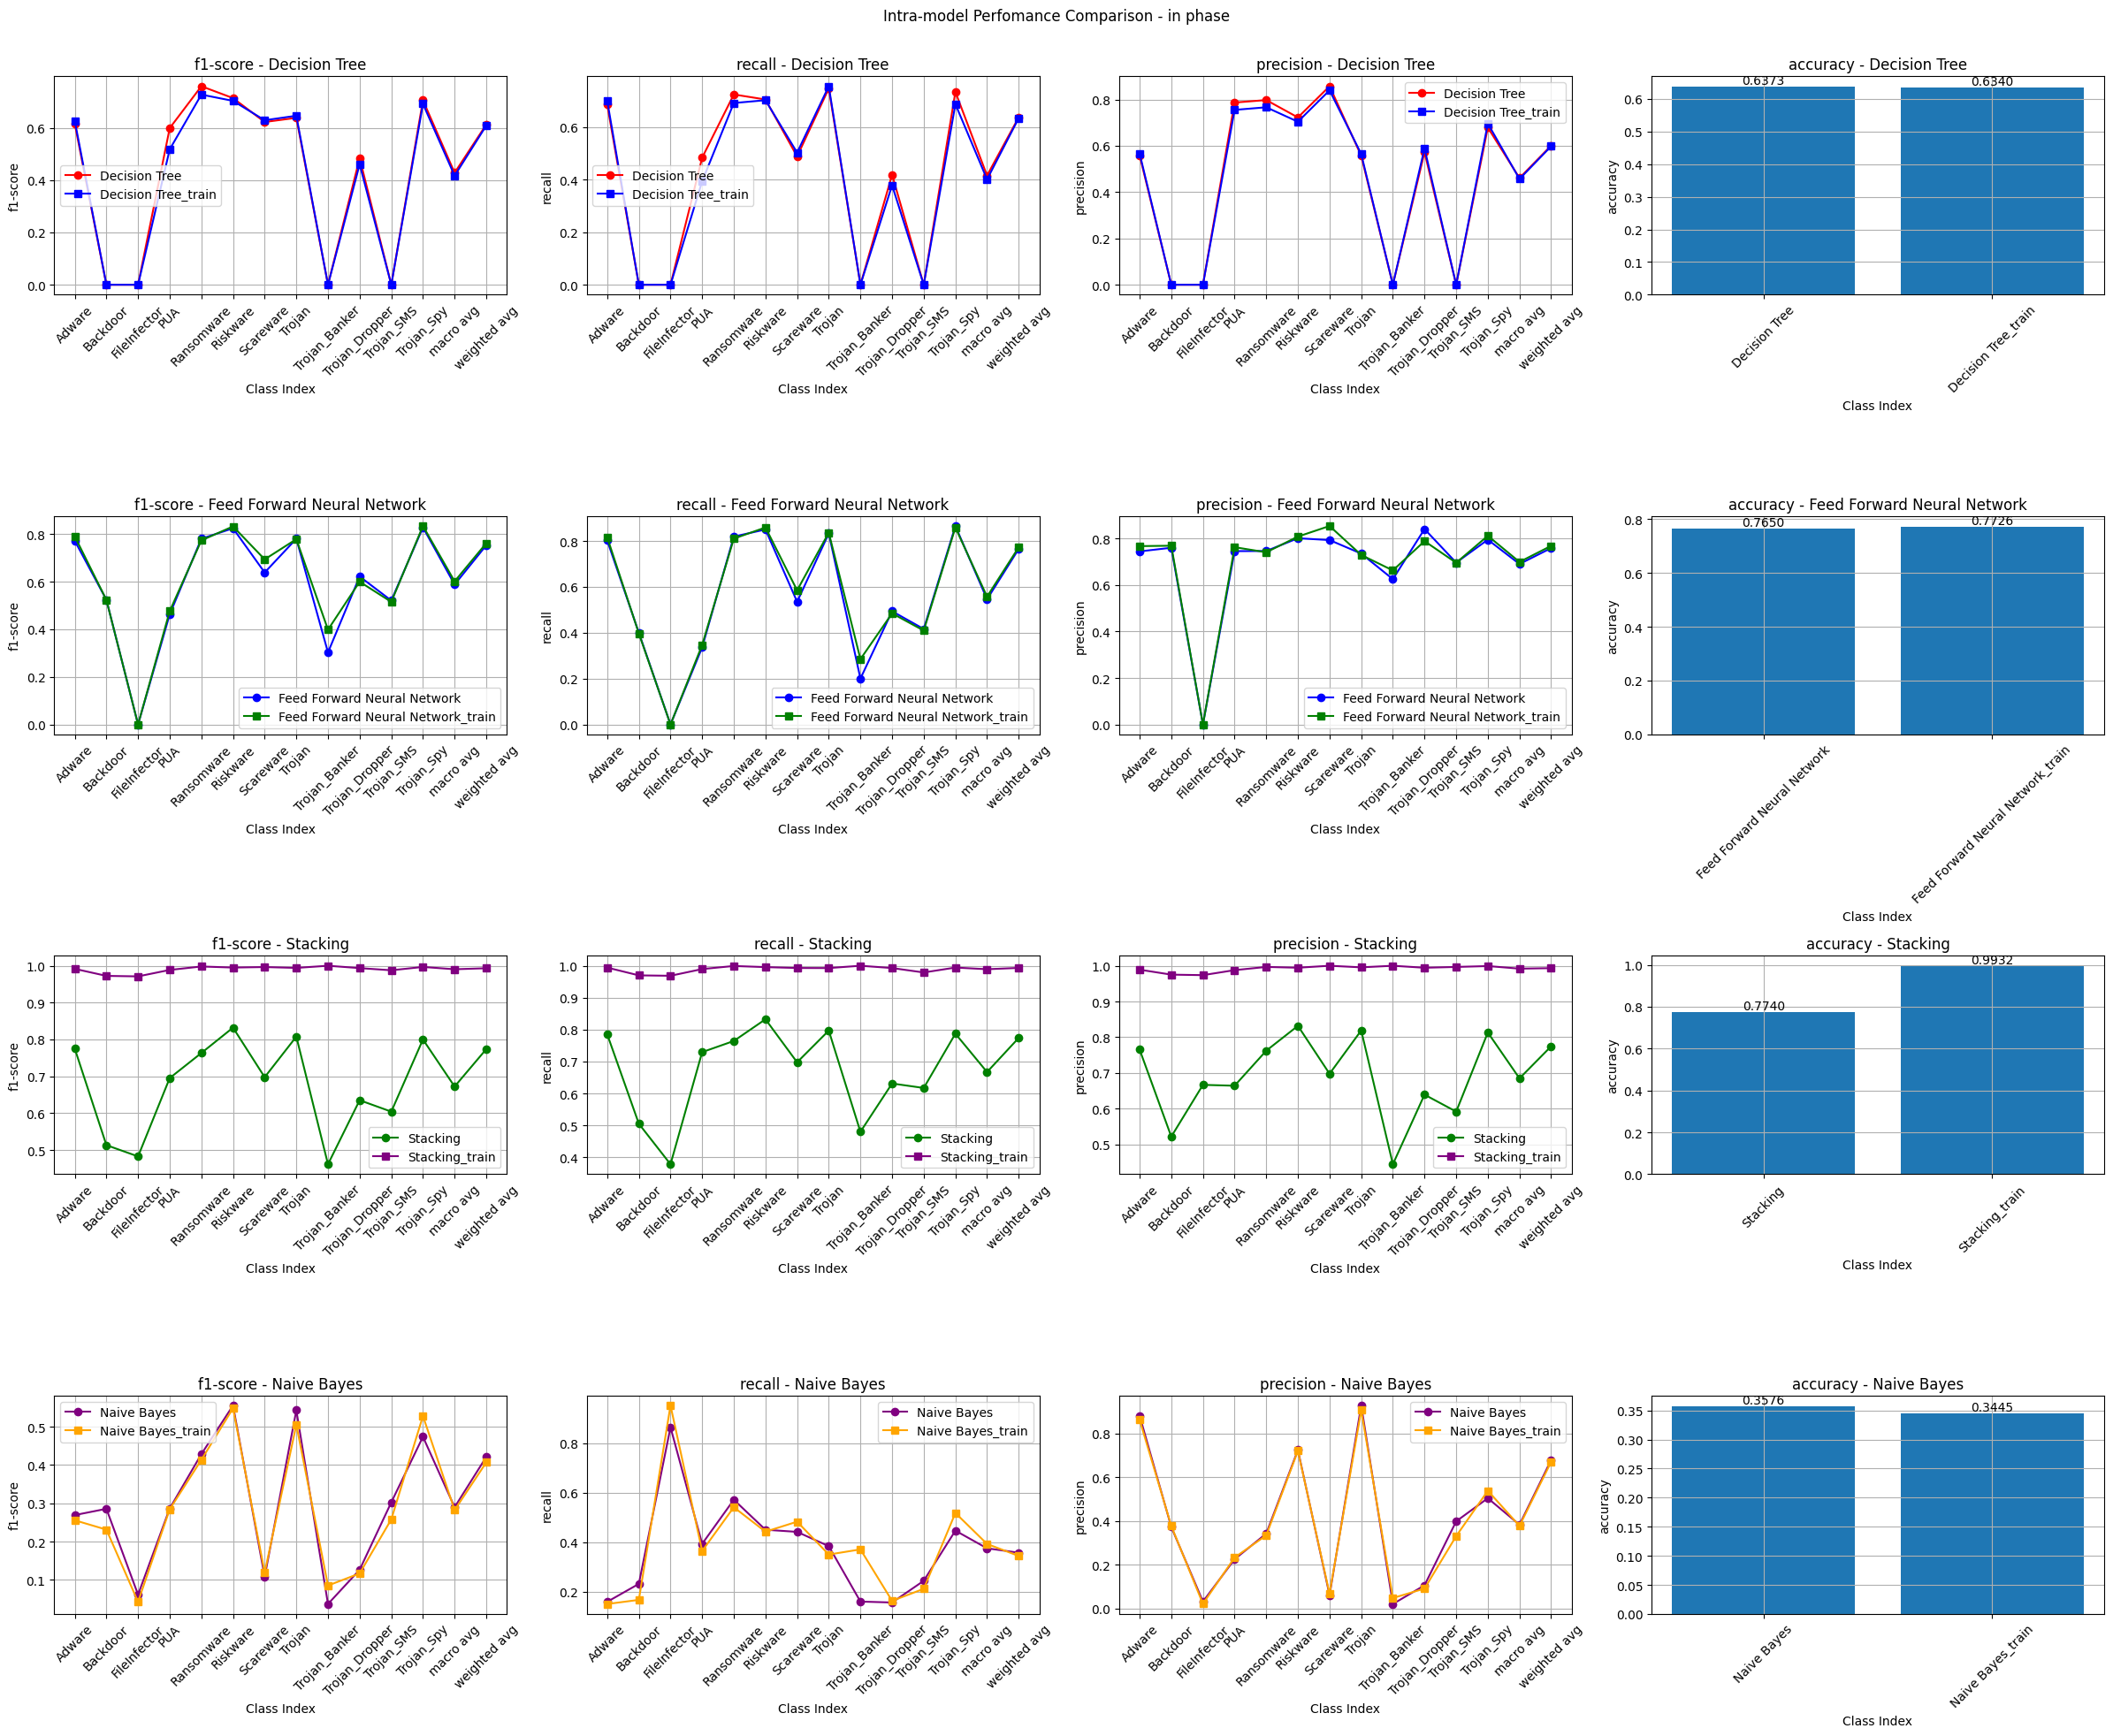

In [102]:
pipeline_manager.pipelines_analysis.plot_intra_model_comparison(metrics=["f1-score", "recall", "precision", "accuracy"], save_plots=False, save_path="")

Unfortunately, keras does not store the per-epoch data when doing Bayesian hyperparemter optimization

In [103]:
#pipeline_manager.pipelines_analysis.plot_per_epoch_progress(metrics=["accuracy", "loss"])

### Residual analysis (in-tuning)

This contains the confusion matrices (weighted and not weighted). 
It also returns the specific elements that were erroneously classified. The analysis of this residuals may be meaningful for further inspection (clustering analysis, EDA...)

Plotting: Decision Tree
Plotting: Naive Bayes
Plotting: Feed Forward Neural Network
Plotting: Stacking


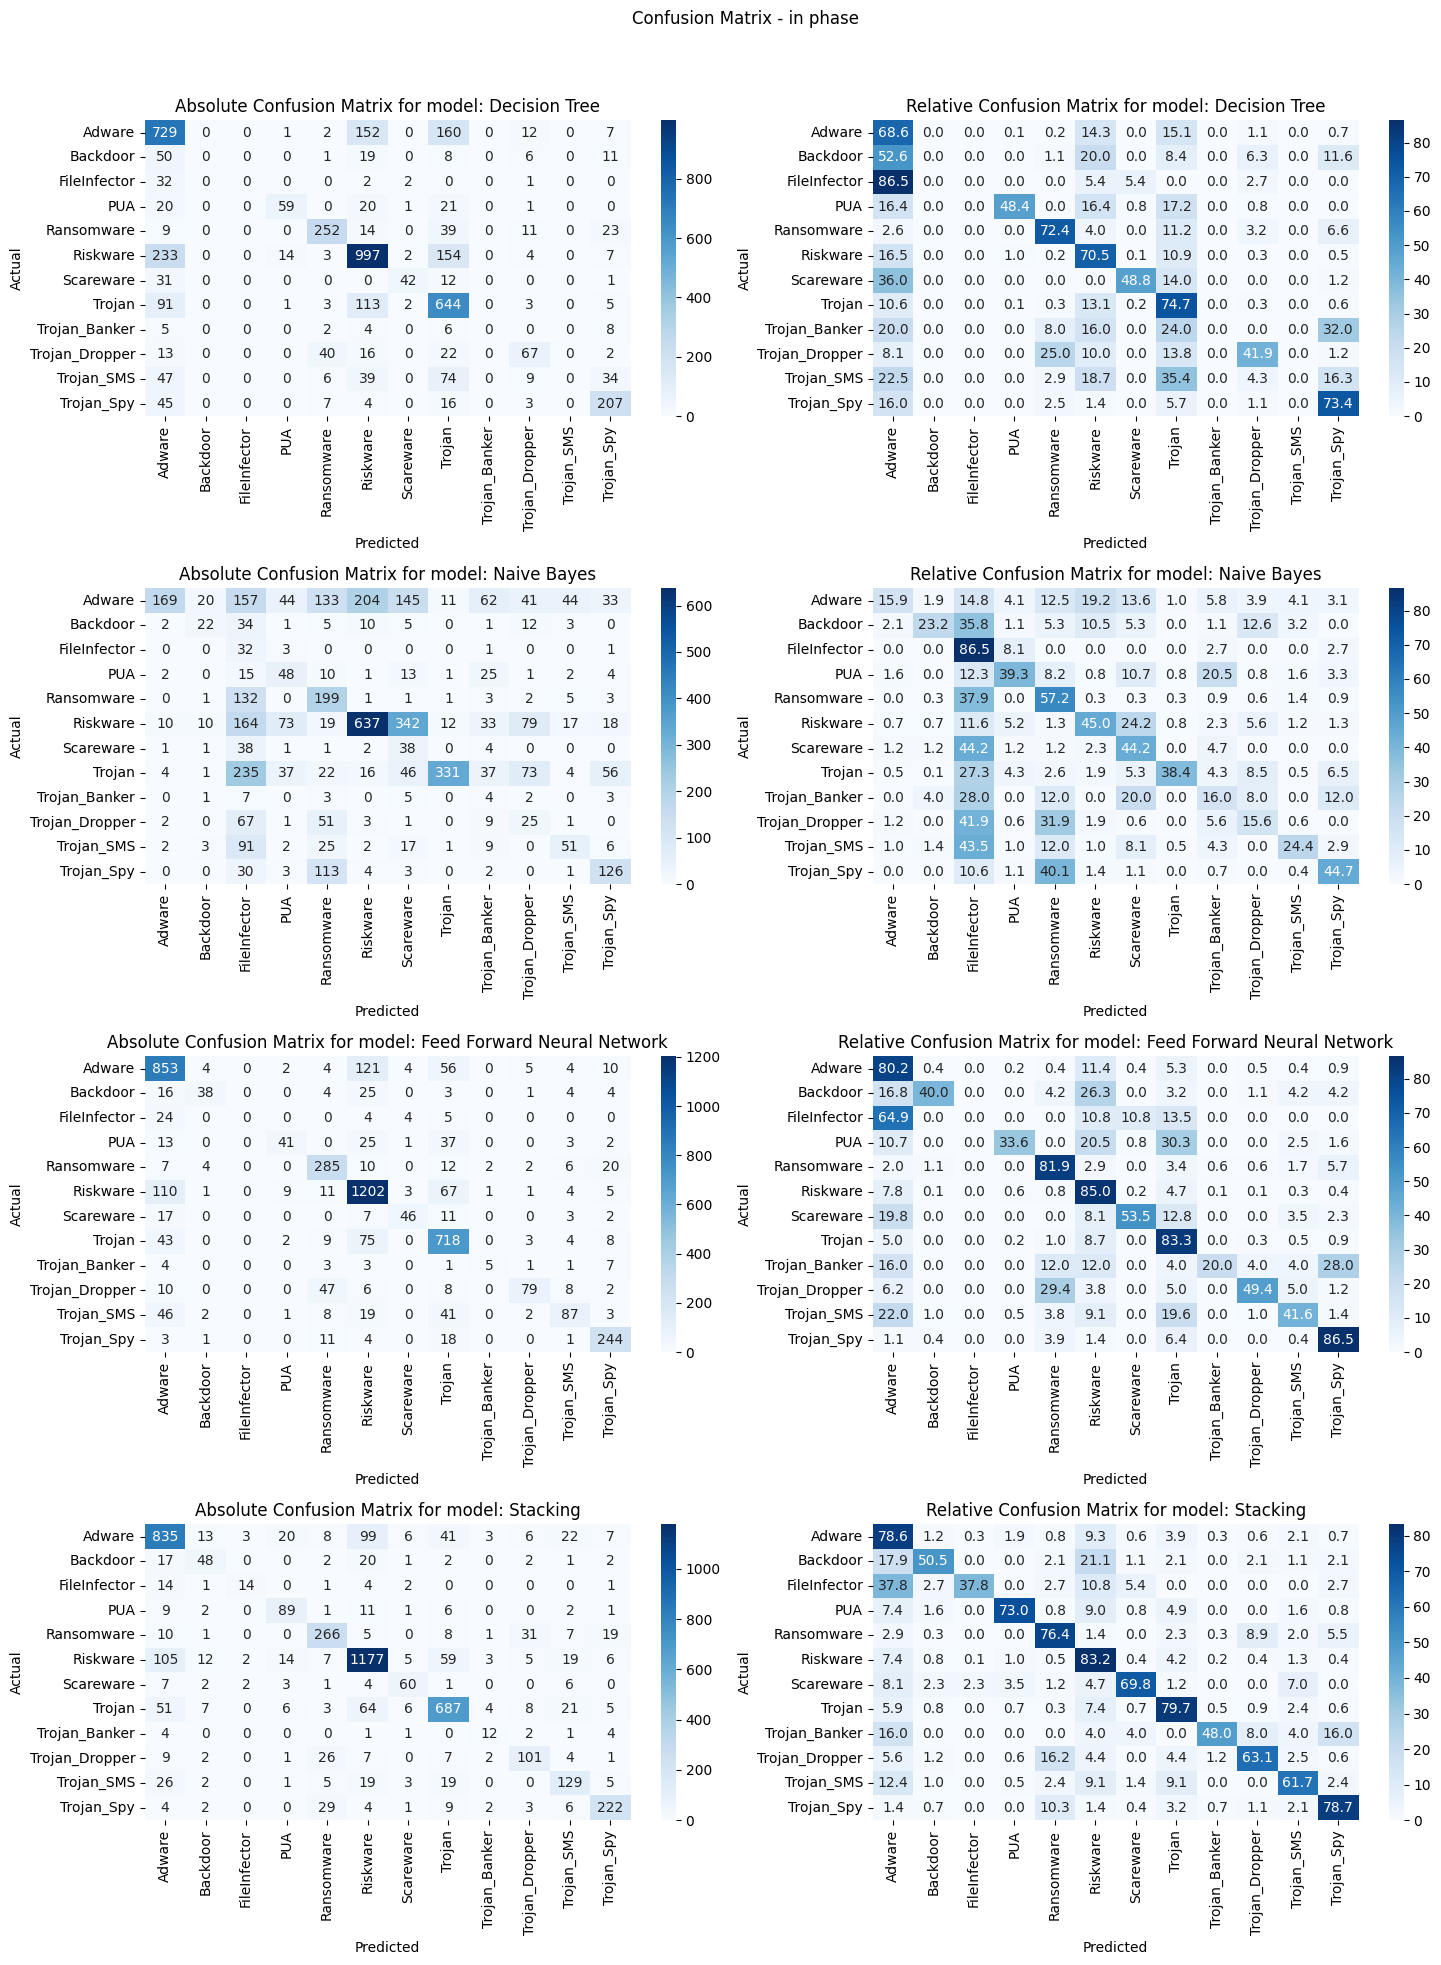

{'tree_based': 53099     3
 11712     0
 52498     3
 41946    10
 2662      0
          ..
 1005     10
 36413     5
 17232     9
 33099     7
 36519     5
 Length: 1706, dtype: int64,
 'naive_bayes': 53099    3
 11712    0
 52498    3
 5763     0
 46186    7
         ..
 52857    3
 47610    7
 7212     0
 7612     0
 36519    5
 Length: 3021, dtype: int64,
 'feed_forward_neural_network': 53099     3
 46186     7
 41946    10
 12505     0
 22423     5
          ..
 8398      0
 49826     4
 1005     10
 33099     7
 52857     3
 Length: 1105, dtype: int64,
 'stacking': 53099     3
 5763      0
 46186     7
 41946    10
 12505     0
          ..
 1005     10
 33099     7
 52857     3
 7612      0
 36519     5
 Length: 1063, dtype: int64}

In [104]:
residuals, confusion_matrices = pipeline_manager.pipelines_analysis.plot_confusion_matrix(save_plots=False, save_path="")
residuals

### Feature importances (in-tuning)

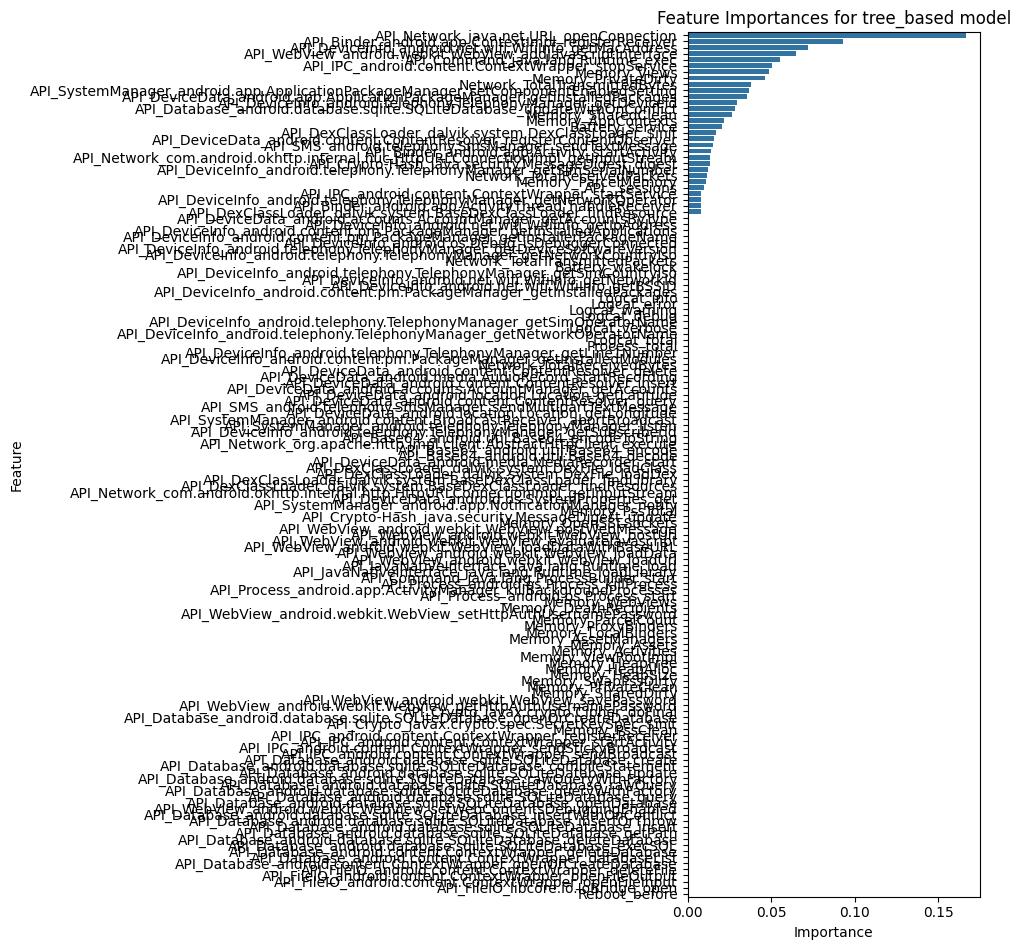

{'tree_based':                                                Feature  Importance
 96             API_Network_java.net.URL_openConnection    0.166737
 70   API_Binder_android.app.ContextImpl_registerRec...    0.093089
 83   API_DeviceInfo_android.net.wifi.WifiInfo_getMa...    0.072120
 33   API_WebView_android.webkit.WebView_addJavascri...    0.064848
 26                  API_Command_java.lang.Runtime_exec    0.055039
 ..                                                 ...         ...
 44   API_FileIO_android.content.ContextWrapper_dele...    0.000000
 43   API_FileIO_android.content.ContextWrapper_open...    0.000000
 42   API_FileIO_android.content.ContextWrapper_open...    0.000000
 41                 API_FileIO_libcore.io.IoBridge_open    0.000000
 141                                      Reboot_before    0.000000
 
 [142 rows x 2 columns]}

In [105]:
importances_dfs = pipeline_manager.pipelines_analysis.plot_feature_importance(save_plots=False, save_path="")
importances_dfs

## Optimizer Covergance
Before we proceed, note that you can access the optimizser object (grid, random or bayes) as per shown in the following example. You may see more detailed information on the tuning process there. For now, we limit ourselves to solely plot the convergence map of the bayes optimizer

Questions:
- what can further be analyzed from this process in order to get better insights?

In [106]:
pipeline_manager.pipelines["not_baseline"]["ensembled"].modelling.list_of_models["Random Forest"].tuning_states["in"].assesment # just an example

{'id': None,
 'timeStamp': None,
 'comments': None,
 'modelName': 'Random Forest',
 'currentPhase': None,
 'features_used': None,
 'hyperParameters': None,
 'timeToFit': None,
 'timeToPredict': None,
 'classification_report': None,
 'accuracy': None,
 'precision': None,
 'recall': None,
 'f1-score': None,
 'predictions_val': None,
 'predictions_train': None,
 'predictions_test': None,
 'model_sklearn': None}

In [107]:
#pipeline_manager.all_pipelines_execute(methodName="modelling.plot_convergence")

In [108]:
pipeline_manager.pipelines["baseline"]["baselines"].modelling.list_of_models["Majority Class (baseline)"].tuning_states["post"].assesment # just an example

{'id': None,
 'timeStamp': None,
 'comments': None,
 'modelName': 'Majority Class (baseline)',
 'currentPhase': None,
 'features_used': None,
 'hyperParameters': None,
 'timeToFit': None,
 'timeToPredict': None,
 'classification_report': None,
 'accuracy': None,
 'precision': None,
 'recall': None,
 'f1-score': None,
 'predictions_val': None,
 'predictions_train': None,
 'predictions_test': None,
 'model_sklearn': None}

In [109]:
pipeline_manager.pipelines["not_baseline"]["feed_forward_neural_network"].modelling.list_of_models["Feed Forward Neural Network"].tuning_states["post"].assesment # just an example


{'id': None,
 'timeStamp': None,
 'comments': None,
 'modelName': 'Feed Forward Neural Network',
 'currentPhase': None,
 'features_used': None,
 'hyperParameters': None,
 'timeToFit': None,
 'timeToPredict': None,
 'classification_report': None,
 'accuracy': None,
 'precision': None,
 'recall': None,
 'f1-score': None,
 'predictions_val': None,
 'predictions_train': None,
 'predictions_test': None,
 'model_sklearn': FeedForwardNeuralNetwork(activations=['relu', 'relu'],
                          learning_rate=0.0014568133071965574, num_classes=12,
                          num_features=142)}

In [110]:
pipeline_manager.pipelines["not_baseline"]["feed_forward_neural_network"].modelling.list_of_models["Feed Forward Neural Network"].tuning_states["post"].assesment # just an example

{'id': None,
 'timeStamp': None,
 'comments': None,
 'modelName': 'Feed Forward Neural Network',
 'currentPhase': None,
 'features_used': None,
 'hyperParameters': None,
 'timeToFit': None,
 'timeToPredict': None,
 'classification_report': None,
 'accuracy': None,
 'precision': None,
 'recall': None,
 'f1-score': None,
 'predictions_val': None,
 'predictions_train': None,
 'predictions_test': None,
 'model_sklearn': FeedForwardNeuralNetwork(activations=['relu', 'relu'],
                          learning_rate=0.0014568133071965574, num_classes=12,
                          num_features=142)}

# Post-tuning Evaluation
Lets start off by selecting the best perfoming model

In [111]:
best_model, best_score = pipeline_manager.select_best_performing_model(metric="f1-score")

Best performing model: Stacking with f1-score 0.7738


In [112]:
pipeline_manager.fit_final_models()

Gonna start fitting models in post phase
=> Fitting Stacking model
Sklearn model: StackingClassifier(cv='prefit',
                   estimators=[('Feed Forward Neural Network',
                                FeedForwardNeuralNetwork(activations=['relu',
                                                                      'relu'],
                                                         learning_rate=0.0014568133071965574,
                                                         num_classes=12,
                                                         num_features=142)),
                               ('Naive Bayes',
                                GaussianNB(var_smoothing=2.888176653914472e-10)),
                               ('Decision Tree',
                                DecisionTreeClassifier(ccp_alpha=0.01,
                                                       criterion='entropy',
                                                       max_depth=30,
                            

/Users/javierdominguezsegura/Academics/College/Courses/2nd year/ML/finalProject/ml-final-project/.venv/lib/python3.11/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but GaussianNB was fitted with feature names
  warnings.warn(
/Users/javierdominguezsegura/Academics/College/Courses/2nd year/ML/finalProject/ml-final-project/.venv/lib/python3.11/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but DecisionTreeClassifier was fitted with feature names
  warnings.warn(


		 => Fitted Stacking. Took 1.5118567943572998 seconds
=> Predicting Stacking model
!> Started predicting Stacking
1323/1323 ━━━━━━━━━━━━━━━━━━━━ 0s 351us/step


/Users/javierdominguezsegura/Academics/College/Courses/2nd year/ML/finalProject/ml-final-project/.venv/lib/python3.11/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but GaussianNB was fitted with feature names
  warnings.warn(
/Users/javierdominguezsegura/Academics/College/Courses/2nd year/ML/finalProject/ml-final-project/.venv/lib/python3.11/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but DecisionTreeClassifier was fitted with feature names
  warnings.warn(


147/147 ━━━━━━━━━━━━━━━━━━━━ 0s 416us/step
		 => Predicted Stacking. Took 1.0355849266052246 seconds
Fitted and predicted model Stacking
Gonna start fitting models in post phase
=> Fitting Majority Class (baseline) model
Sklearn model: <library.utils.ownModels.majorityClassModel.MajorityClassClassifier object at 0x166cf83d0>
!> Started fitting Majority Class (baseline)
X_train_combined: (42328, 142)
Lenght of X_data: 42328
		 => Fitted Majority Class (baseline). Took 0.020349979400634766 seconds
=> Predicting Majority Class (baseline) model
!> Started predicting Majority Class (baseline)
		 => Predicted Majority Class (baseline). Took 5.7220458984375e-05 seconds
Fitted and predicted model Majority Class (baseline)


In [113]:
pipeline_manager.evaluate_store_final_models()

Evaluating model Stacking
Evaluating Stacking in post phase
METRIC RESULTS FOR Stacking => F1: 0.774558249881899, Precision: 0.7748284670983002, Recall: 0.7748724489795918, Accuracy: 0.7748724489795918
Evaluating model Majority Class (baseline)
Evaluating Majority Class (baseline) in post phase
METRIC RESULTS FOR Majority Class (baseline) => F1: 0.13946974395051273, Precision: 0.09074131619059188, Recall: 0.3012329931972789, Accuracy: 0.3012329931972789


/Users/javierdominguezsegura/Academics/College/Courses/2nd year/ML/finalProject/ml-final-project/.venv/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/javierdominguezsegura/Academics/College/Courses/2nd year/ML/finalProject/ml-final-project/.venv/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/javierdominguezsegura/Academics/College/Courses/2nd year/ML/finalProject/ml-final-project/.venv/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1565: Undefined

****WARNING****: A model with the same values already exists in the results. Results will not be saved. 
                               You tried to write {'id': 'ab84c38d9fcb87b0d040dca5ccfc4f4bc586b18b878d5d906c2ea8bd7e51038c', 'timeStamp': '2025-05-04 17:18:36', 'comments': 'I know cate will not like this comment', 'modelName': 'Majority Class (baseline)', 'currentPhase': 'post', 'features_used': ['Memory_PssTotal', 'Memory_PssClean', 'Memory_SharedDirty', 'Memory_PrivateDirty', 'Memory_SharedClean', 'Memory_PrivateClean', 'Memory_SwapPssDirty', 'Memory_HeapSize', 'Memory_HeapAlloc', 'Memory_HeapFree', 'Memory_Views', 'Memory_ViewRootImpl', 'Memory_AppContexts', 'Memory_Activities', 'Memory_Assets', 'Memory_AssetManagers', 'Memory_LocalBinders', 'Memory_ProxyBinders', 'Memory_ParcelMemory', 'Memory_ParcelCount', 'Memory_DeathRecipients', 'Memory_OpenSSLSockets', 'Memory_WebViews', 'API_Process_android.os.Process_start', 'API_Process_android.app.ActivityManager_killBackgroundProcesse

### Metric Evaluation

In [114]:
pipeline_manager.pipeline_state = "post"

### Cross-Model Evaluation (post-tuning)

In [115]:
class_report_df = pipeline_manager.pipelines_analysis._compute_classification_report(include_training=True)
class_report_df

precision    recall  f1-score   support  accuracy  \
Adware          0.785714  0.784259  0.784986    1080.0  0.774872   
Backdoor         0.60396  0.539823  0.570093     113.0  0.774872   
FileInfector     0.40625      0.65       0.5      20.0  0.774872   
PUA             0.692982  0.705357  0.699115     112.0  0.774872   
Ransomware      0.767507  0.750685  0.759003     365.0  0.774872   
Riskware        0.827875  0.838391    0.8331    1417.0  0.774872   
Scareware       0.829268   0.73913  0.781609      92.0  0.774872   
Trojan          0.790168  0.789222  0.789694     835.0  0.774872   
Trojan_Banker   0.555556       0.5  0.526316      30.0  0.774872   
Trojan_Dropper  0.590361  0.601227  0.595745     163.0  0.774872   
Trojan_SMS       0.61194  0.577465  0.594203     213.0  0.774872   
Trojan_Spy      0.794224  0.833333  0.813309     264.0  0.774872   
macro avg       0.687984  0.692408  0.687264    4704.0  0.774872   
weighted avg    0.774828  0.774872  0.774558    4704.0  0.774872   
modelName       Stacking  Stacking  Stacking  Stacking  Stacking   

                     precision          recall        f1-score  \
Adware                0.989532         0.99303        0.991278   
Backdoor              0.975369        0.966797        0.971064   
FileInfector          0.969027        0.960526        0.964758   
PUA                   0.986441        0.988115        0.987277   
Ransomware            0.997378        0.999015        0.998196   
Riskware              0.993917        0.995647        0.994781   
Scareware                  1.0        0.992443        0.996207   
Trojan                0.995513        0.992239        0.993873   
Trojan_Banker              1.0             1.0             1.0   
Trojan_Dropper        0.995011        0.992182        0.993594   
Trojan_SMS            0.987202        0.983198        0.985196   
Trojan_Spy             0.99922        0.994953        0.997082   
macro avg             0.990717        0.988179        0.989442   
weighted avg          0.992866        0.992865        0.992863   
modelName       Stacking_train  Stacking_train  Stacking_train   

                       support        accuracy                  precision  \
Adware                  9900.0        0.992865                        0.0   
Backdoor                1024.0        0.992865                        0.0   
FileInfector             228.0        0.992865                        0.0   
PUA                     1178.0        0.992865                        0.0   
Ransomware              3046.0        0.992865                        0.0   
Riskware               12636.0        0.992865                   0.301233   
Scareware                794.0        0.992865                        0.0   
Trojan                  7602.0        0.992865                        0.0   
Trojan_Banker            211.0        0.992865                        0.0   
Trojan_Dropper          1407.0        0.992865                        0.0   
Trojan_SMS              1726.0        0.992865                        0.0   
Trojan_Spy              2576.0        0.992865                        0.0   
macro avg              42328.0        0.992865                   0.025103   
weighted avg           42328.0        0.992865                   0.090741   
modelName       Stacking_train  Stacking_train  Majority Class (baseline)   

                                   recall                   f1-score  \
Adware                                0.0                        0.0   
Backdoor                              0.0                        0.0   
FileInfector                          0.0                        0.0   
PUA                                   0.0                        0.0   
Ransomware                            0.0                        0.0   
Riskware                              1.0                   0.462996   
Scareware                             0.0                        0.0   
Trojan                                0.0                   

PLOTTING CROSS MODEL COMPARISON FOR post PHASE
Plotting: f1-score
Plotting: recall
Plotting: precision
Plotting: accuracy


/Users/javierdominguezsegura/Academics/College/Courses/2nd year/ML/finalProject/ml-final-project/library/pipeline/analysis/pipelines_analysis.py:163: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  ax.legend()


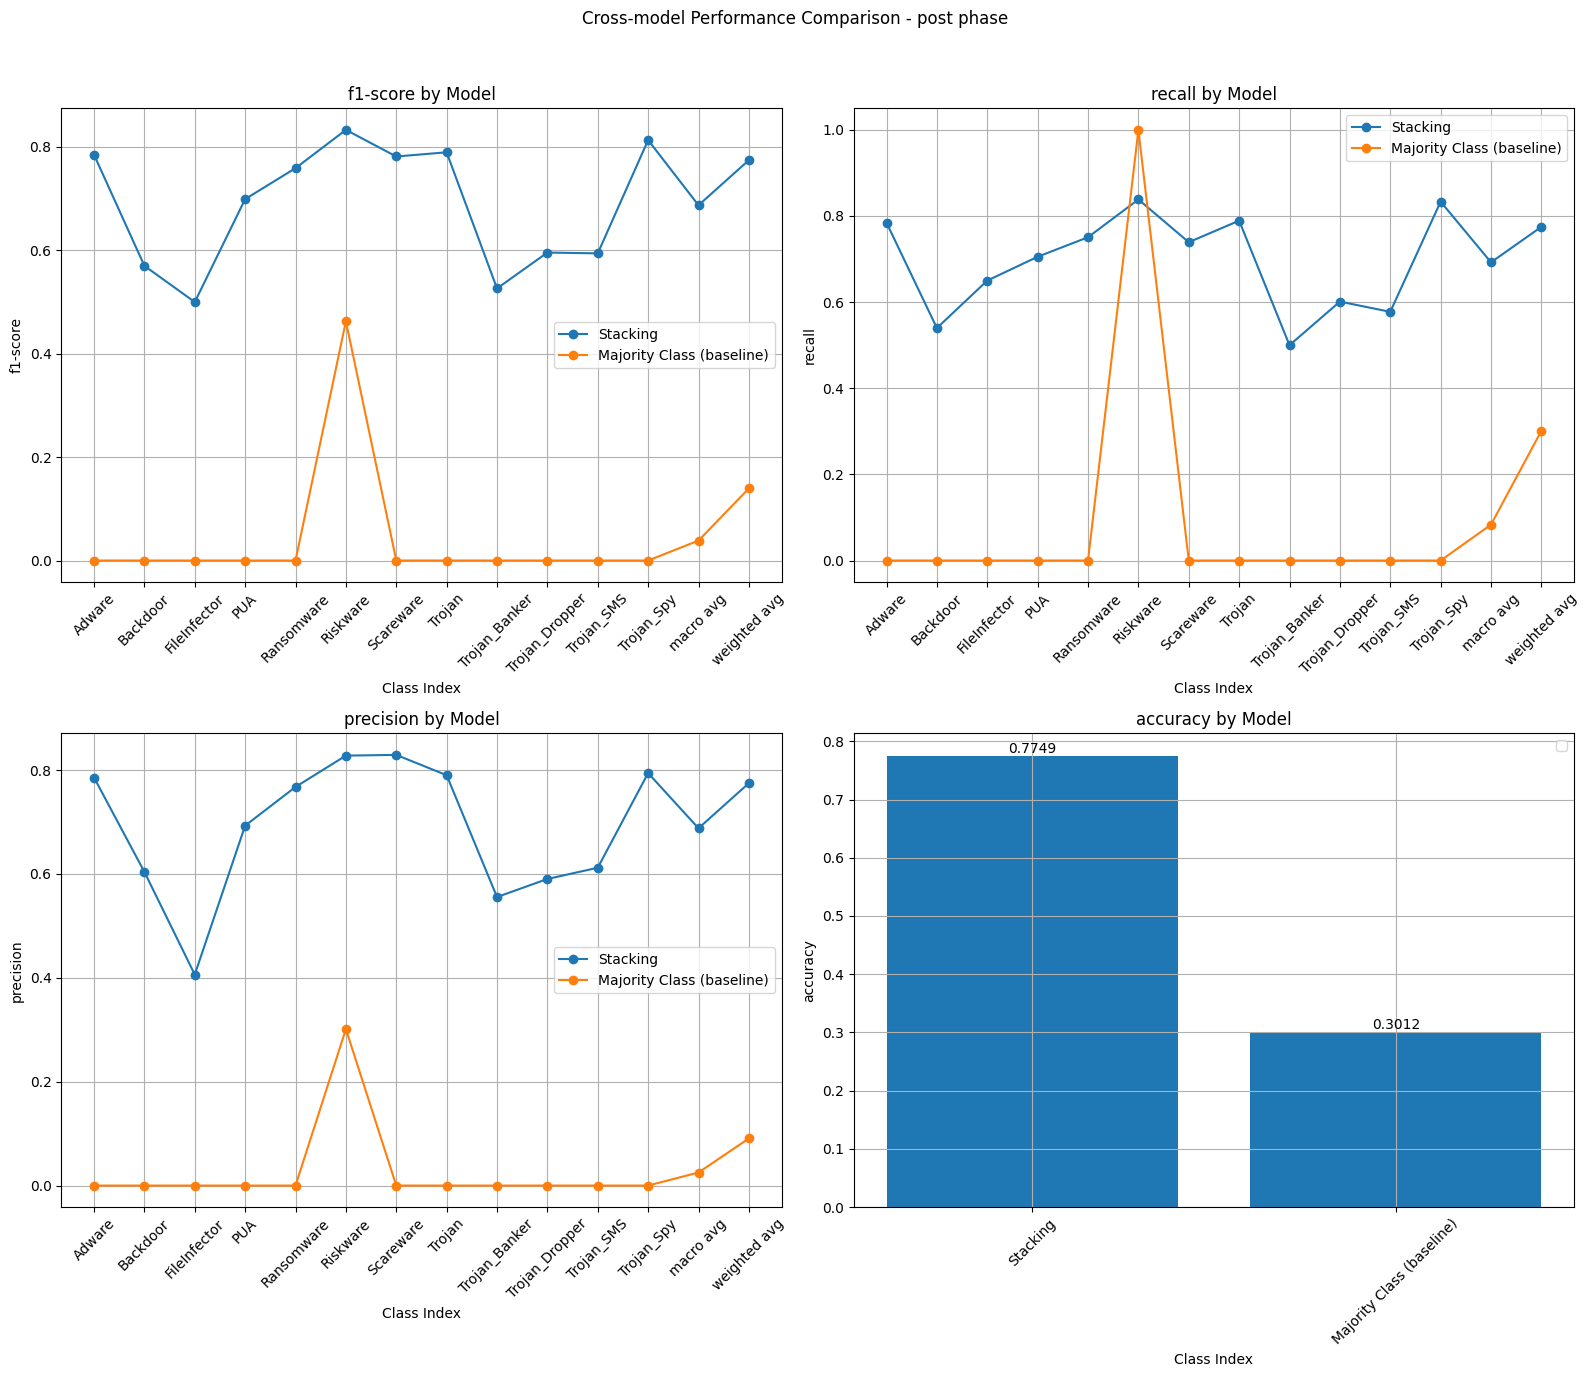

In [116]:
pipeline_manager.pipelines_analysis.plot_cross_model_comparison(metric=["f1-score", "recall", "precision", "accuracy"], save_plots=False, save_path="")

Metrics df:                                                   id            timeStamp  \
0  23c64e9f352b87530ac3f9fec4f30c4a044ec868635ce0...  2025-05-04 17:18:29   

                                 comments modelName currentPhase  \
0  I know cate will not like this comment  Stacking         post   

                                       features_used  \
0  [Memory_PssTotal, Memory_PssClean, Memory_Shar...   

                                     hyperParameters  timeToFit  \
0  {'cv': 'prefit', 'estimators': [('Feed Forward...   1.511857   

   timeToPredict classification_report  accuracy_test  accuracy_val  \
0       1.035585                  None       0.774872            -1   

   precision_test  precision_val  recall_test  recall_val  f1-score_test  \
0        0.774828             -1     0.774872          -1       0.774558   

   f1-score_val  
0            -1  


/Users/javierdominguezsegura/Academics/College/Courses/2nd year/ML/finalProject/ml-final-project/library/pipeline/analysis/pipelines_analysis.py:304: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=metrics_df, x='modelName', y=metric, ax=ax, palette="viridis")
/Users/javierdominguezsegura/Academics/College/Courses/2nd year/ML/finalProject/ml-final-project/library/pipeline/analysis/pipelines_analysis.py:304: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=metrics_df, x='modelName', y=metric, ax=ax, palette="viridis")


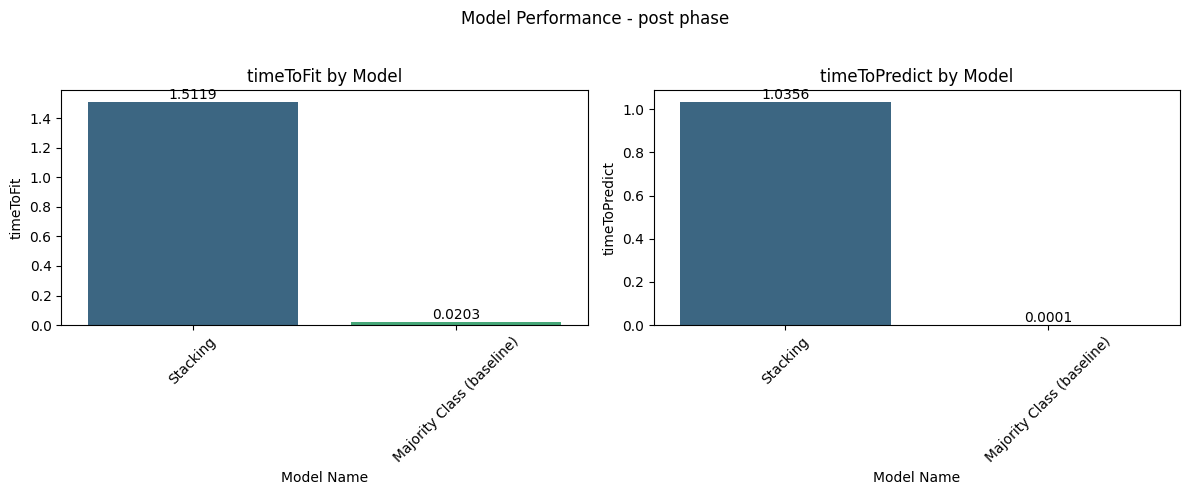

id            timeStamp  \
0  23c64e9f352b87530ac3f9fec4f30c4a044ec868635ce0...  2025-05-04 17:18:29   
0  ab84c38d9fcb87b0d040dca5ccfc4f4bc586b18b878d5d...  2025-05-04 17:18:36   

                                 comments                  modelName  \
0  I know cate will not like this comment                   Stacking   
0  I know cate will not like this comment  Majority Class (baseline)   

  currentPhase                                      features_used  \
0         post  [Memory_PssTotal, Memory_PssClean, Memory_Shar...   
0         post  [Memory_PssTotal, Memory_PssClean, Memory_Shar...   

                                     hyperParameters  timeToFit  \
0  {'cv': 'prefit', 'estimators': [('Feed Forward...   1.511857   
0                                                 {}   0.020350   

   timeToPredict classification_report  accuracy_test  accuracy_val  \
0       1.035585                  None       0.774872            -1   
0       0.000057                  None       0.301233            -1   

   precision_test  precision_val  recall_test  recall_val  f1-score_test  \
0        0.774828             -1     0.774872          -1       0.774558   
0        0.090741             -1     0.301233          -1       0.139470   

   f1-score_val  
0            -1  
0            -1

In [117]:
pipeline_manager.pipelines_analysis.plot_results_df(metrics=["timeToFit", "timeToPredict"], save_plots=False, save_path="")

### Results Summary Visualization

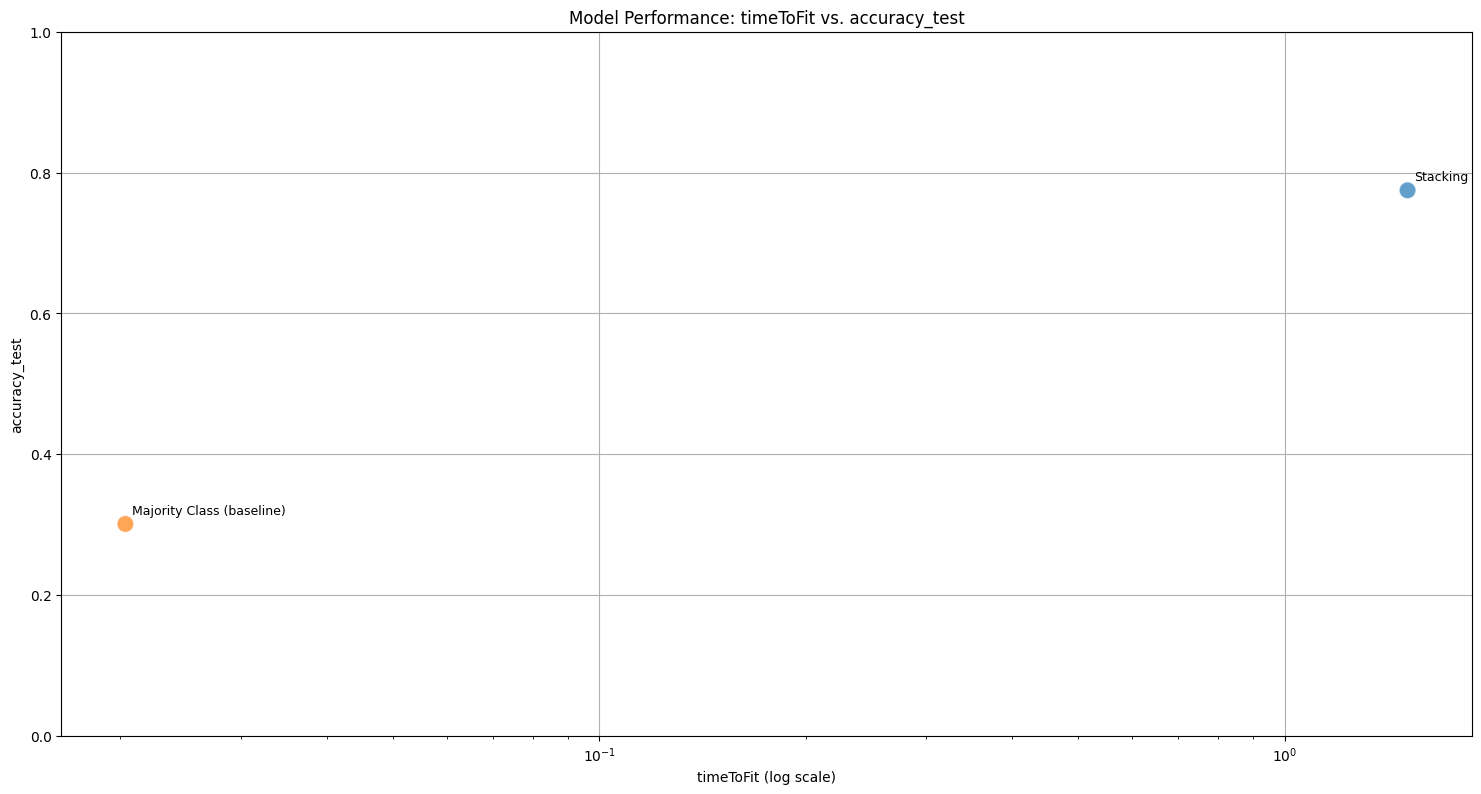

In [118]:
pipeline_manager.pipelines_analysis.plot_results_summary(training_metric="timeToFit", performance_metric="accuracy", save_plots=False, save_path="")

### Intra-model Evaluation (post-tuning)
We plot 3 metrics (f1, recall and precision) for each model constrasting its performance between trainign and validation. It is not subject of interest cross-model evaluation, but rather, intra-model evaluation.

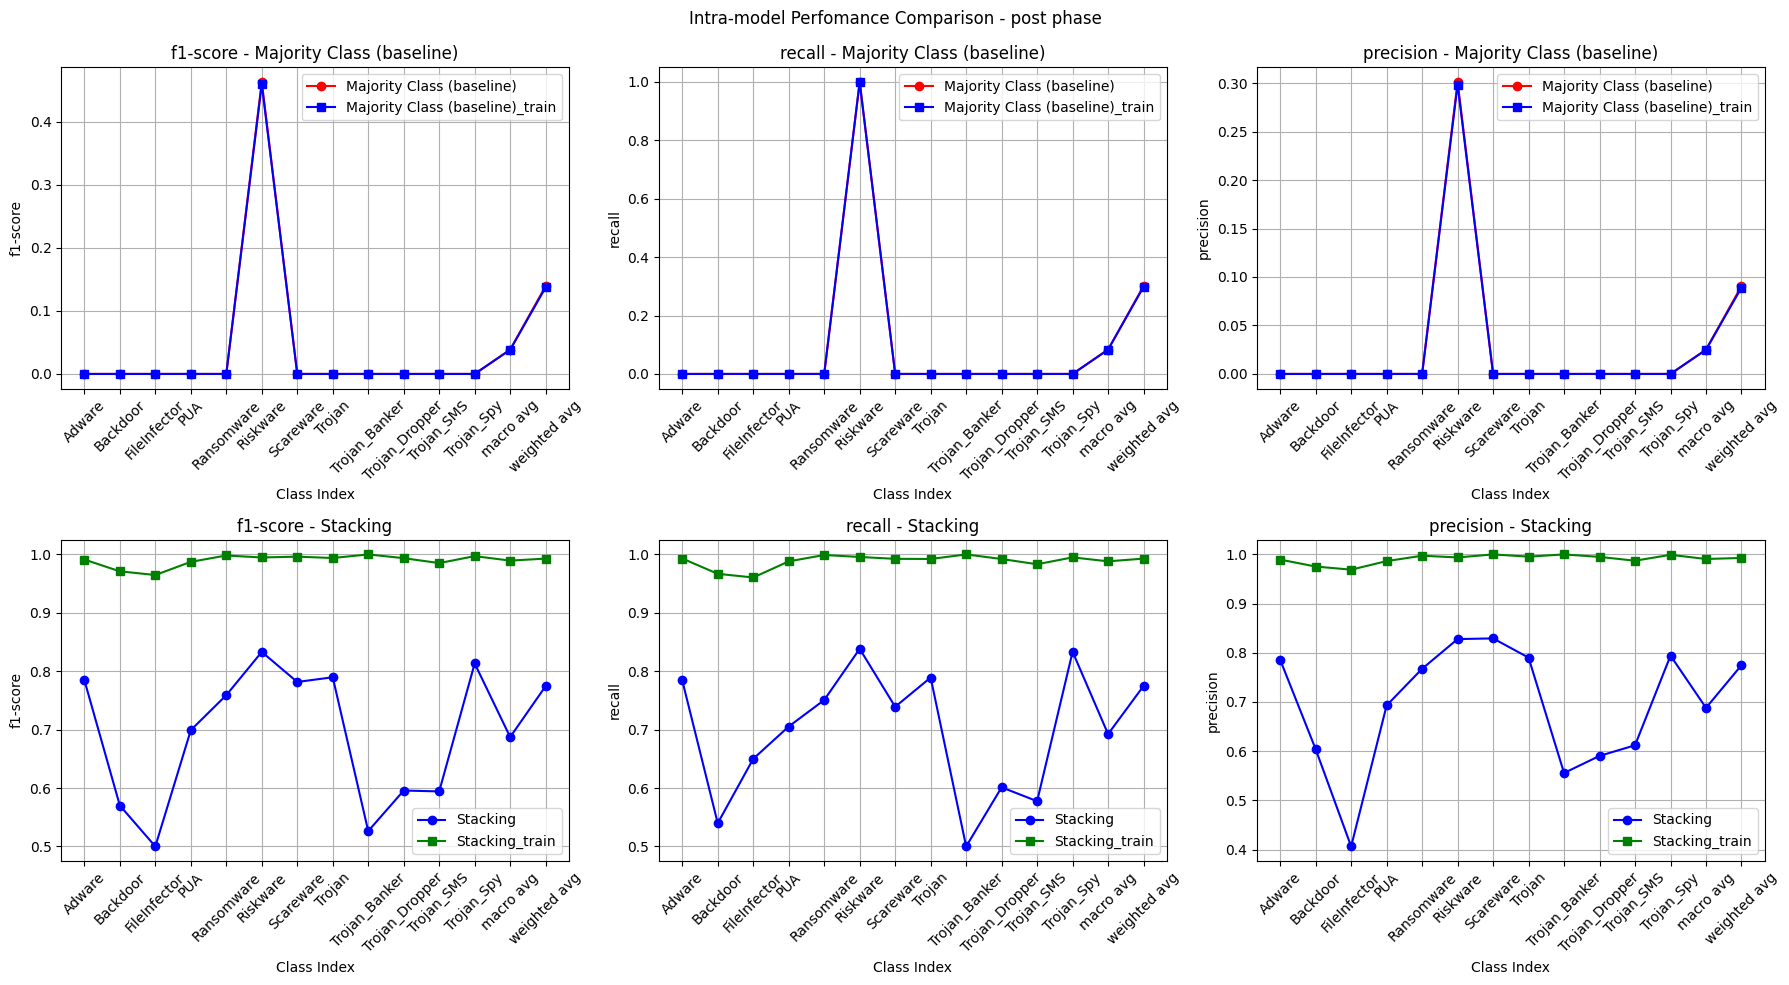

In [119]:
pipeline_manager.pipelines_analysis.plot_intra_model_comparison(metrics=["f1-score", "recall", "precision"], save_plots=False, save_path="")


Lets see the progress of the NN

In [120]:
#pipeline_manager.pipelines_analysis.plot_per_epoch_progress(metrics=["accuracy", "loss"])

### Residual analysis (post-tuning)

This contains the confusion matrices (weighted and not weighted). 
It also returns the specific elements that were erroneously classified. The analysis of this residuals may be meaningful for further inspection (clustering analysis, EDA...)

Plotting: Stacking
Plotting: Majority Class (baseline)


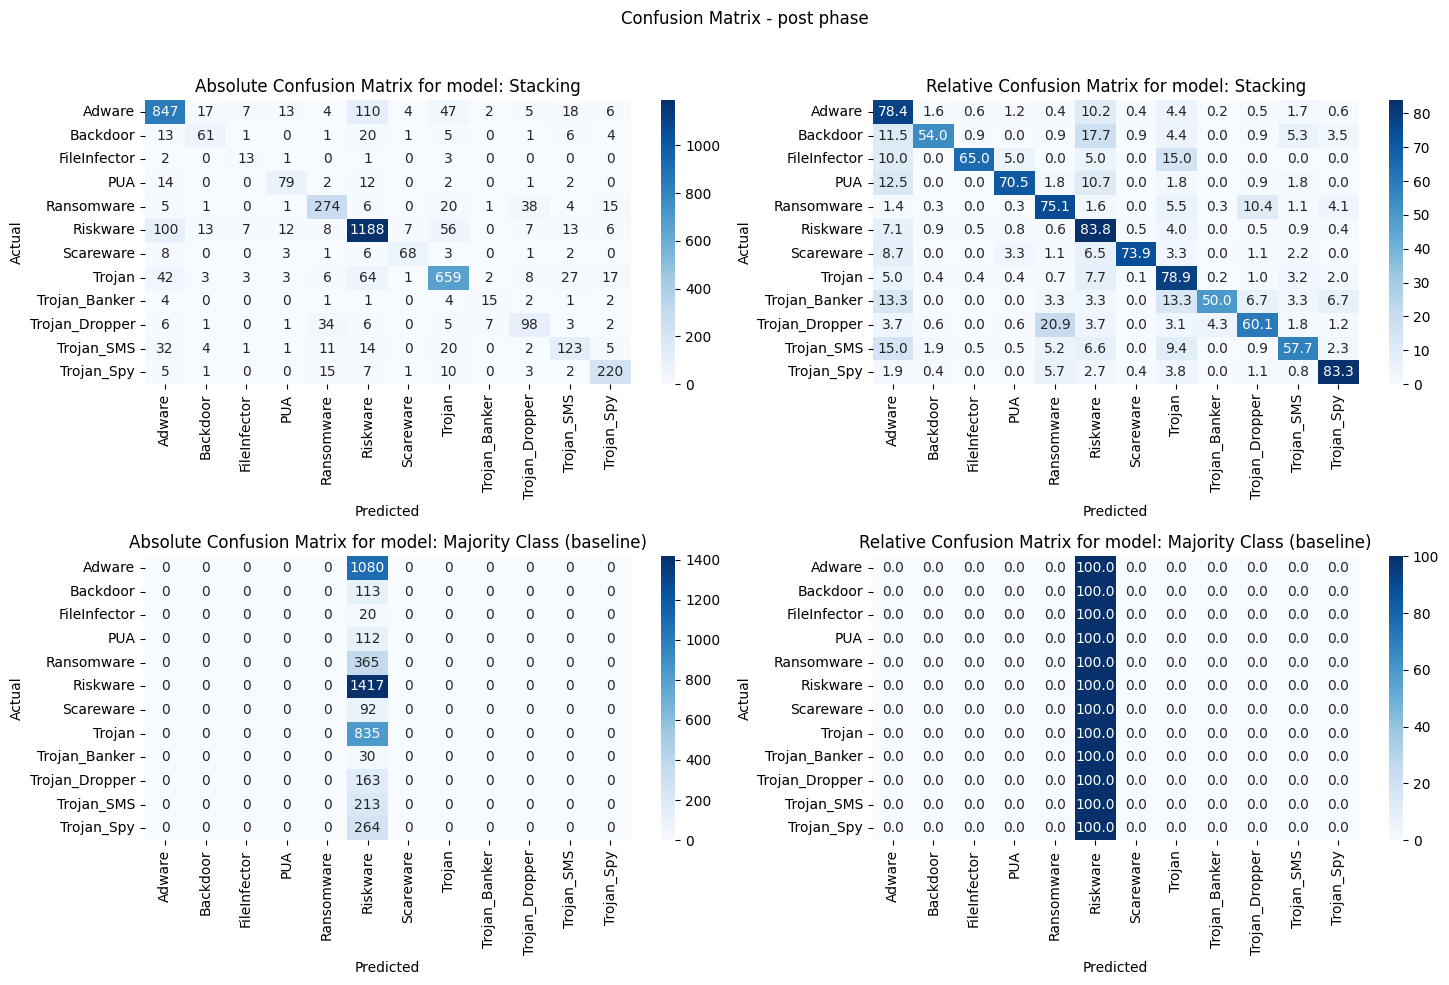

{'stacking': 51708    11
 41662    10
 5338      0
 34312     2
 39848     5
          ..
 47772     7
 8609      0
 36889     5
 15442     1
 10913     0
 Length: 1059, dtype: int64,
 'baselines': 15929     9
 8975      0
 155      10
 51708    11
 1482      6
          ..
 10913     0
 52384     3
 32109     7
 42424    11
 5520      0
 Length: 3287, dtype: int64}

In [121]:
residuals, confusion_matrices = pipeline_manager.pipelines_analysis.plot_confusion_matrix(save_plots=False, save_path="")
residuals

### Feature importances (post-tuning)

In [122]:
importances_dfs = pipeline_manager.pipelines_analysis.plot_feature_importance(save_plots=False, save_path="")
importances_dfs

{}

## Saving Best Model

In [123]:
#pipeline_manager.serialize_models(models_to_serialize=["Majority Class (baseline)"])

In [124]:
#pipeline_manager.serialize_pipelines(pipelines_to_serialize=["naive-bayes"])